# Построение бейзлайна для классификации токсичных комментариев

### Подгрузка необходимых библиотек

In [1]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [41]:
# Базовые библиотеки
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
random.seed(42)
np.random.seed(42)

# Библиотеки ML

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Подбор гиперпараметров, метрики, преобразование переменных
import optuna
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier

# Дополнительные библиотеки
from functools import partial
from IPython.display import display, HTML
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

nltk.download('vader_lexicon')

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/vlad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Данные

In [13]:
df = pd.read_csv('modified_train.csv', parse_dates=['created_date'], date_format='ISO8601')
# Удаление из данных отрезков времени, в которых слишком мало данных
df = df[df['created_date'] >= '2016-04-01']
# Сортировка данных для дальнейшего разделения по временной метке для дальнейшего деления на train/val/test
df = df.sort_values('created_date').reset_index(drop=True)
# Заполнение N/A значений в обработанных комментариях без стоп слов
df['ctws'] = df['ctws'].fillna('')
# Размерность данных
print(f'Dataset shape: {df.shape}')
print(f'Dataset (Only ordinary class) shape: {df[df.toxicity_b == 0].shape}')
print(f'Dataset (Only toxic class) shape: {df[df.toxicity_b == 1].shape}')
print('Процентное соотношение значений ' + str(df['toxicity_b'].value_counts(normalize=True) * 100))

Dataset shape: (1785308, 39)
Dataset (Only ordinary class) shape: (1585541, 39)
Dataset (Only toxic class) shape: (199767, 39)
Процентное соотношение значений toxicity_b
0   88.81
1   11.19
Name: proportion, dtype: float64


Как можно было заметить ещё на этапе EDA в данных наблюдается довольно-таки сильный дисбаланс классов. Если грубо округлять, то у нас примерно 90% обычных комментариев и 10% токсичных комментариев. В ходе построения моделей хотелось бы как минимизировать ложные срабатывания модели, на которые указывает метрика Precision, так и минимизировать пропуски в классификации токсичных комментариев, на которые указывает метрика Recall. Поэтому одной из основных метрик, на которую мы будем полагаться, при оценивании моделей, будет являться гармоническое среднее между метриками Precision и Recall - F1.

## Тривиальные модели

In [14]:
X = df['ctws']
y = df['toxicity_b']

def save_metrics_to_dataframe(model_name, dataset_name, metrics, s, df=None):
    """
    Сохраняет метрики классификации в DataFrame с указанием модели и выборки.

    :param model_name: Название модели (str)
    :param dataset_name: Название выборки (str)
    :param metrics: Словарь с метриками
    :param df: DataFrame для сохранения метрик (опционально)
    :return: Обновленный DataFrame
    """

    if 'ROC AUC' not in metrics:
        metrics['ROC AUC'] = np.nan

    # Создаем строку для добавления
    row = {'Model': model_name, 'Dataset': dataset_name, 'Stage': s, **metrics}

    # Если DataFrame не передан, создаем новый
    if df is None:
        df = pd.DataFrame(columns=row.keys())

    # Добавляем строку в DataFrame
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

    return df

def show_baseline_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f'Accuracy: {accuracy:.2f}\t\tPrecision: {precision:.2f}\t\tRecall: {recall:.2f}\t\tF1: {f1:.2f}')

    cm = confusion_matrix(y_true, y_pred, normalize='all')
    labels = ['Non-Toxic (0)', 'Toxic (1)']
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    sns.heatmap(cm_df, annot=True, fmt=".2%", cmap='twilight_shifted')
    plt.title(f'Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

def classification_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Выводит метрики классификации: accuracy, precision, recall, f1, roc_auc (при наличии вероятностей).

    :param y_true: Список истинных меток классов
    :param y_pred: Список предсказанных меток классов
    :param y_pred_proba: Список предсказанных вероятностей для положительного класса (опционально)
    :return: Словарь с метриками
    """
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1 Score': f1_score(y_true, y_pred, zero_division=0)
    }

    if y_pred_proba is not None:
        try:
            metrics['ROC AUC'] = roc_auc_score(y_true, y_pred_proba)
        except ValueError:
            metrics['ROC AUC'] = 'Not computable (check input data)'


    return metrics

### Случайное предсказание

Accuracy: 0.50		Precision: 0.11		Recall: 0.50		F1: 0.18


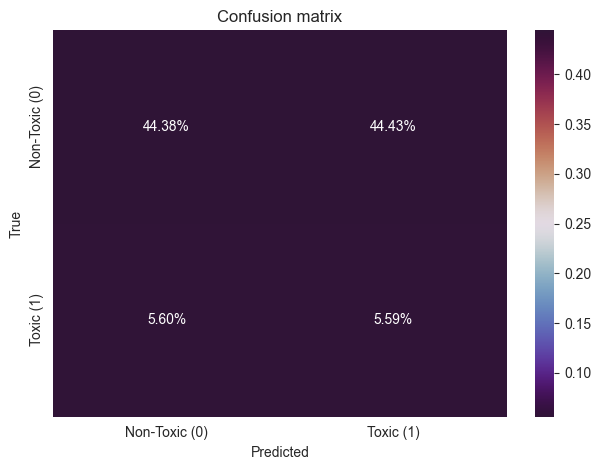

In [9]:
def random_prediction(texts):
    return [random.choice([0, 1]) for _ in texts]

show_baseline_metrics(y, random_prediction(X))

Случайное предсказание просто поделило метки пополам

In [10]:
model_name = "Random_Classifier"
dataset_name = "Dataset"
stage = 'Simple models'
metrics = classification_metrics(y, random_prediction(X))
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage)

### Предсказание самого частого класса

Accuracy: 0.89		Precision: 0.00		Recall: 0.00		F1: 0.00


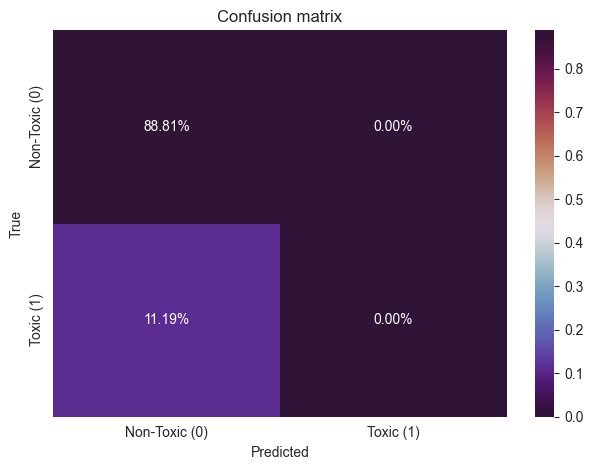

In [11]:
from collections import Counter

def most_frequent_class_prediction(labels, texts):
    most_common_class = Counter(labels).most_common(1)[0][0]
    return [most_common_class] * len(texts)

show_baseline_metrics(y, most_frequent_class_prediction(y, X))

Взглянув на метрику `Accuracy` можно подумать, что модель справляется хорошо, но это не так, потому что классы в датасете несбалансированы, и нетоксичных комментариев сильно больше.

Поэтому данный метод присваивает всем текстам отрицательный класс (это также видно по матрице ошибок), из-за чего метрики точности, полноты и F1 зануляются.

In [12]:
model_name = "Most_Frequent_Class"
dataset_name = "Dataset"
stage = 'Simple models'
metrics = classification_metrics(y, most_frequent_class_prediction(y, X))
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### Предсказание с фиксированной вероятностью

In [14]:
%%time
# clf_dummy = DummyClassifier(strategy='stratified', random_state=42)
# clf_dummy.fit(X_train, y_train['toxicity'])

CPU times: user 1e+03 ns, sys: 12 µs, total: 13 µs
Wall time: 15 µs


In [15]:
# plot_metrics_single(clf_dummy, 'DummyClassifier', 'toxicity', X_train, y_train['toxicity'], X_val, y_val['toxicity'], 'TRAIN', 'VALIDATION')

### Lexicon-based подход

Также можно попробовать lexicon-based подход с определением тональности текстов

In [16]:
df_lb = df.copy()

sia = SentimentIntensityAnalyzer()

def extract_vader_features(text):
    scores = sia.polarity_scores(text)
    return pd.Series([scores['neg'], scores['neu'], scores['pos'], scores['compound']])

vader_features = df_lb['ctws'].parallel_apply(extract_vader_features)
vader_features.columns = ['neg', 'neu', 'pos', 'compound']

df_lb = pd.concat([df_lb, vader_features], axis=1)

Accuracy: 0.70		Precision: 0.20		Recall: 0.57		F1: 0.30


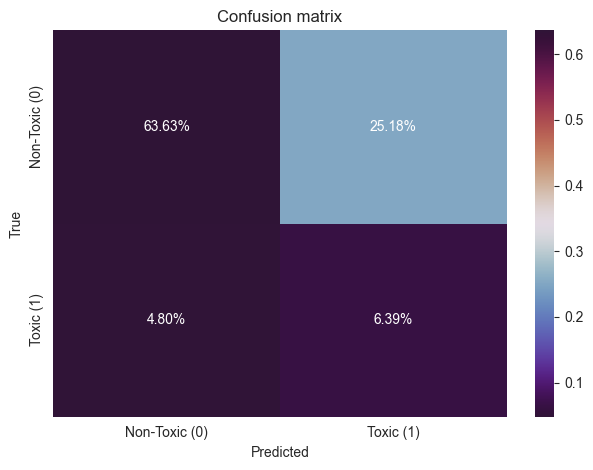

In [17]:
def classify_sentiment(score):
    if score <= -0.2:
        return 1
    return 0

show_baseline_metrics(y, df_lb['compound'].apply(classify_sentiment))

Классификация на основе тональности текста показывает себя уже лучше, но помечает много нетоксичных комментариев как токсичные (был взят порог, который ипользовался для составления столбца "toxicity" (0.4) и переведен в шкалу от -1 до 1 (-0.2))

In [18]:
model_name = "Sentiment_Classifier"
dataset_name = "Dataset"
stage = 'Simple models'
metrics = classification_metrics(y, df_lb['compound'].apply(classify_sentiment))
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [31]:
df_metrics

Model  Dataset          Stage  Accuracy  Precision  Recall  \
0     Random_Classifier  Dataset  Simple models      0.50       0.11    0.50   
1   Most_Frequent_Class  Dataset  Simple models      0.89       0.00    0.00   
2  Sentiment_Classifier  Dataset  Simple models      0.70       0.20    0.57   

   F1 Score  ROC AUC  
0      0.18      NaN  
1      0.00      NaN  
2      0.30      NaN

# Обучение моделей без гиперпараметров

В предыдущем разделе была продемонстрированна работа тривиальных моделей на всем датасете. Как можно заметить исходя из полученных метрик наилучшей моделью по метрикам `recall`, `precision` и `F-1` является модель построенная на словараях для определения тональности текста. Однако данные модели не строятся на классических подходах ML и скорее всего классические модели дадут лучший результат. Для начала посмотрим на что эти модели способны без какого-либо подбора гиперпараметров обученных при помощи BoW и TF-IDF.

### Предобработка данных и построение необходимых для анализа и обучения моделей функций

In [15]:
split_date = df.iloc[int(len(df) * 0.8)]['created_date']
split_date

Timestamp('2017-09-03 13:54:26.194849+0000', tz='UTC')

In [16]:
train_val_df = df[df['created_date'] <= split_date]
test_df = df[df['created_date'] > split_date]

In [22]:
X_test = test_df['ctws']
y_test = test_df['toxicity_b']

In [17]:
split_date = train_val_df.iloc[int(len(train_val_df) * 0.8)]['created_date']
split_date

Timestamp('2017-07-06 03:02:41.334553+0000', tz='UTC')

In [19]:
train_df = train_val_df[train_val_df['created_date'] <= split_date]
val_df = train_val_df[train_val_df['created_date'] > split_date]

In [20]:
X_train = train_df['ctws']
y_train = train_df['toxicity_b']

X_val = val_df['ctws']
y_val= val_df['toxicity_b']

In [ ]:
y_train.mean(), y_test.mean(), y_val.mean()

(0.10893507602848947, 0.11765776716023313, 0.11653112736260235)

In [10]:
# Функция обучения модели и предсказания и визуализации результатов
def train_and_predict_toxicity(model, X_train, X_val, X_test, y_train):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        # Вероятности для положительного класса
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_val = model.predict_proba(X_val)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_pred_proba_train = model.decision_function(X_train)
        y_pred_proba_val = model.decision_function(X_val)
        y_pred_proba_test = model.decision_function(X_test)
    else:
        y_pred_proba_train = None
        y_pred_proba_val = None
        y_pred_proba_test = None

    return y_pred_train, y_pred_val, y_pred_test, y_pred_proba_train, y_pred_proba_val, y_pred_proba_test

# Функция для отображения метрик
def show_metrics(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, y_pred_proba_train, y_pred_proba_val, y_pred_proba_test, title):
    precision_train = precision_score(y_train, y_pred_train)
    precision_val = precision_score(y_val, y_pred_val)
    precision_test = precision_score(y_test, y_pred_test)

    recall_train = recall_score(y_train, y_pred_train)
    recall_val = recall_score(y_val, y_pred_val)
    recall_test = recall_score(y_test, y_pred_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_val = f1_score(y_val, y_pred_val)
    f1_test = f1_score(y_test, y_pred_test)

    print(title + '\n')

    print('Precision\t\tRecall\t\t\tF1\n')
    print(f'Train: {precision_train:.2f}\t\tTrain: {recall_train:.2f}\t\tTrain: {f1_train:.2f}')
    print(f'Val: {precision_val:.2f}\t\tVal: {recall_val:.2f}\t\tVal: {f1_val:.2f}')
    print(f'Test: {precision_test:.2f}\t\tTest: {recall_test:.2f}\t\tTest: {f1_test:.2f}')

    def show_confusion_matrix(y_true, y_pred, sample_name, ax):
        cm = confusion_matrix(y_true, y_pred, normalize='all')
        labels = ['Non-Toxic (0)', 'Toxic (1)']
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)

        sns.heatmap(cm_df, annot=True, fmt=".2%", cmap='twilight_shifted', ax=ax)
        ax.set_title(f'Confusion matrix ({sample_name})')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    def show_roc_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        auc = roc_auc_score(y_true, y_pred_proba)

        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'{model_name} ({sample_name}) ROC (AUC = {auc:.2f})')
        ax.grid(True)

    def show_pr_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        auc_pr = auc(recall, precision)

        ax.plot(recall, precision)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'{model_name} ({sample_name}) Precision-Recall Curve (AUC = {auc_pr:.2f})')
        ax.grid(True)

    if y_pred_proba_train is not None and y_pred_proba_test is not None:
        _, axs = plt.subplots(3, 3, figsize=(18, 16))

        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0, 0])
        show_confusion_matrix(y_val, y_pred_val, 'Val', axs[0, 1])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[0, 2])

        show_roc_curve(y_train, y_pred_proba_train, title, 'Train', axs[1, 0])
        show_roc_curve(y_val, y_pred_proba_val, title, 'Val', axs[1, 1])
        show_roc_curve(y_test, y_pred_proba_test, title, 'Test', axs[1, 2])

        show_pr_curve(y_train, y_pred_proba_train, title, 'Train', axs[2, 0])
        show_pr_curve(y_val, y_pred_proba_val, title, 'Val', axs[2, 1])
        show_pr_curve(y_test, y_pred_proba_test, title, 'Test', axs[2, 2])
    else:
        _, axs = plt.subplots(1, 3, figsize=(14, 6))

        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0])
        show_confusion_matrix(y_val, y_pred_val, 'Val', axs[1])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[2])

    plt.tight_layout()
    plt.show()

In [8]:
# Функция получеия мешка слов
def get_bows(X_train, X_val, X_test, ngram_range=(1, 1)):
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_val), vectorizer.transform(X_test)


# Векторизация  TF-IDF
def get_tfidf(X_train, X_val, X_test, ngram_range=(1, 1)):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range, min_df=0.0001)
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_val), vectorizer.transform(X_test)

## Обучение моделей с мешком слов

In [23]:
X_train_bow, X_val_bow, X_test_bow = get_bows(X_train, X_val, X_test)

### Логистическая регрессия

In [ ]:
X_train_bow.shape

(1142598, 199333)

In [ ]:
(y_log_reg_bow_pred_train,
 y_log_reg_bow_pred_val,
 y_log_reg_bow_pred_test,
 y_log_reg_bow_pred_proba_train,
 y_log_reg_bow_pred_proba_val,
 y_log_reg_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

LogisticRegression BoW

Precision		Recall			F1

Train: 0.79		Train: 0.52		Train: 0.63
Val: 0.75		Val: 0.48		Val: 0.59
Test: 0.75		Test: 0.48		Test: 0.58


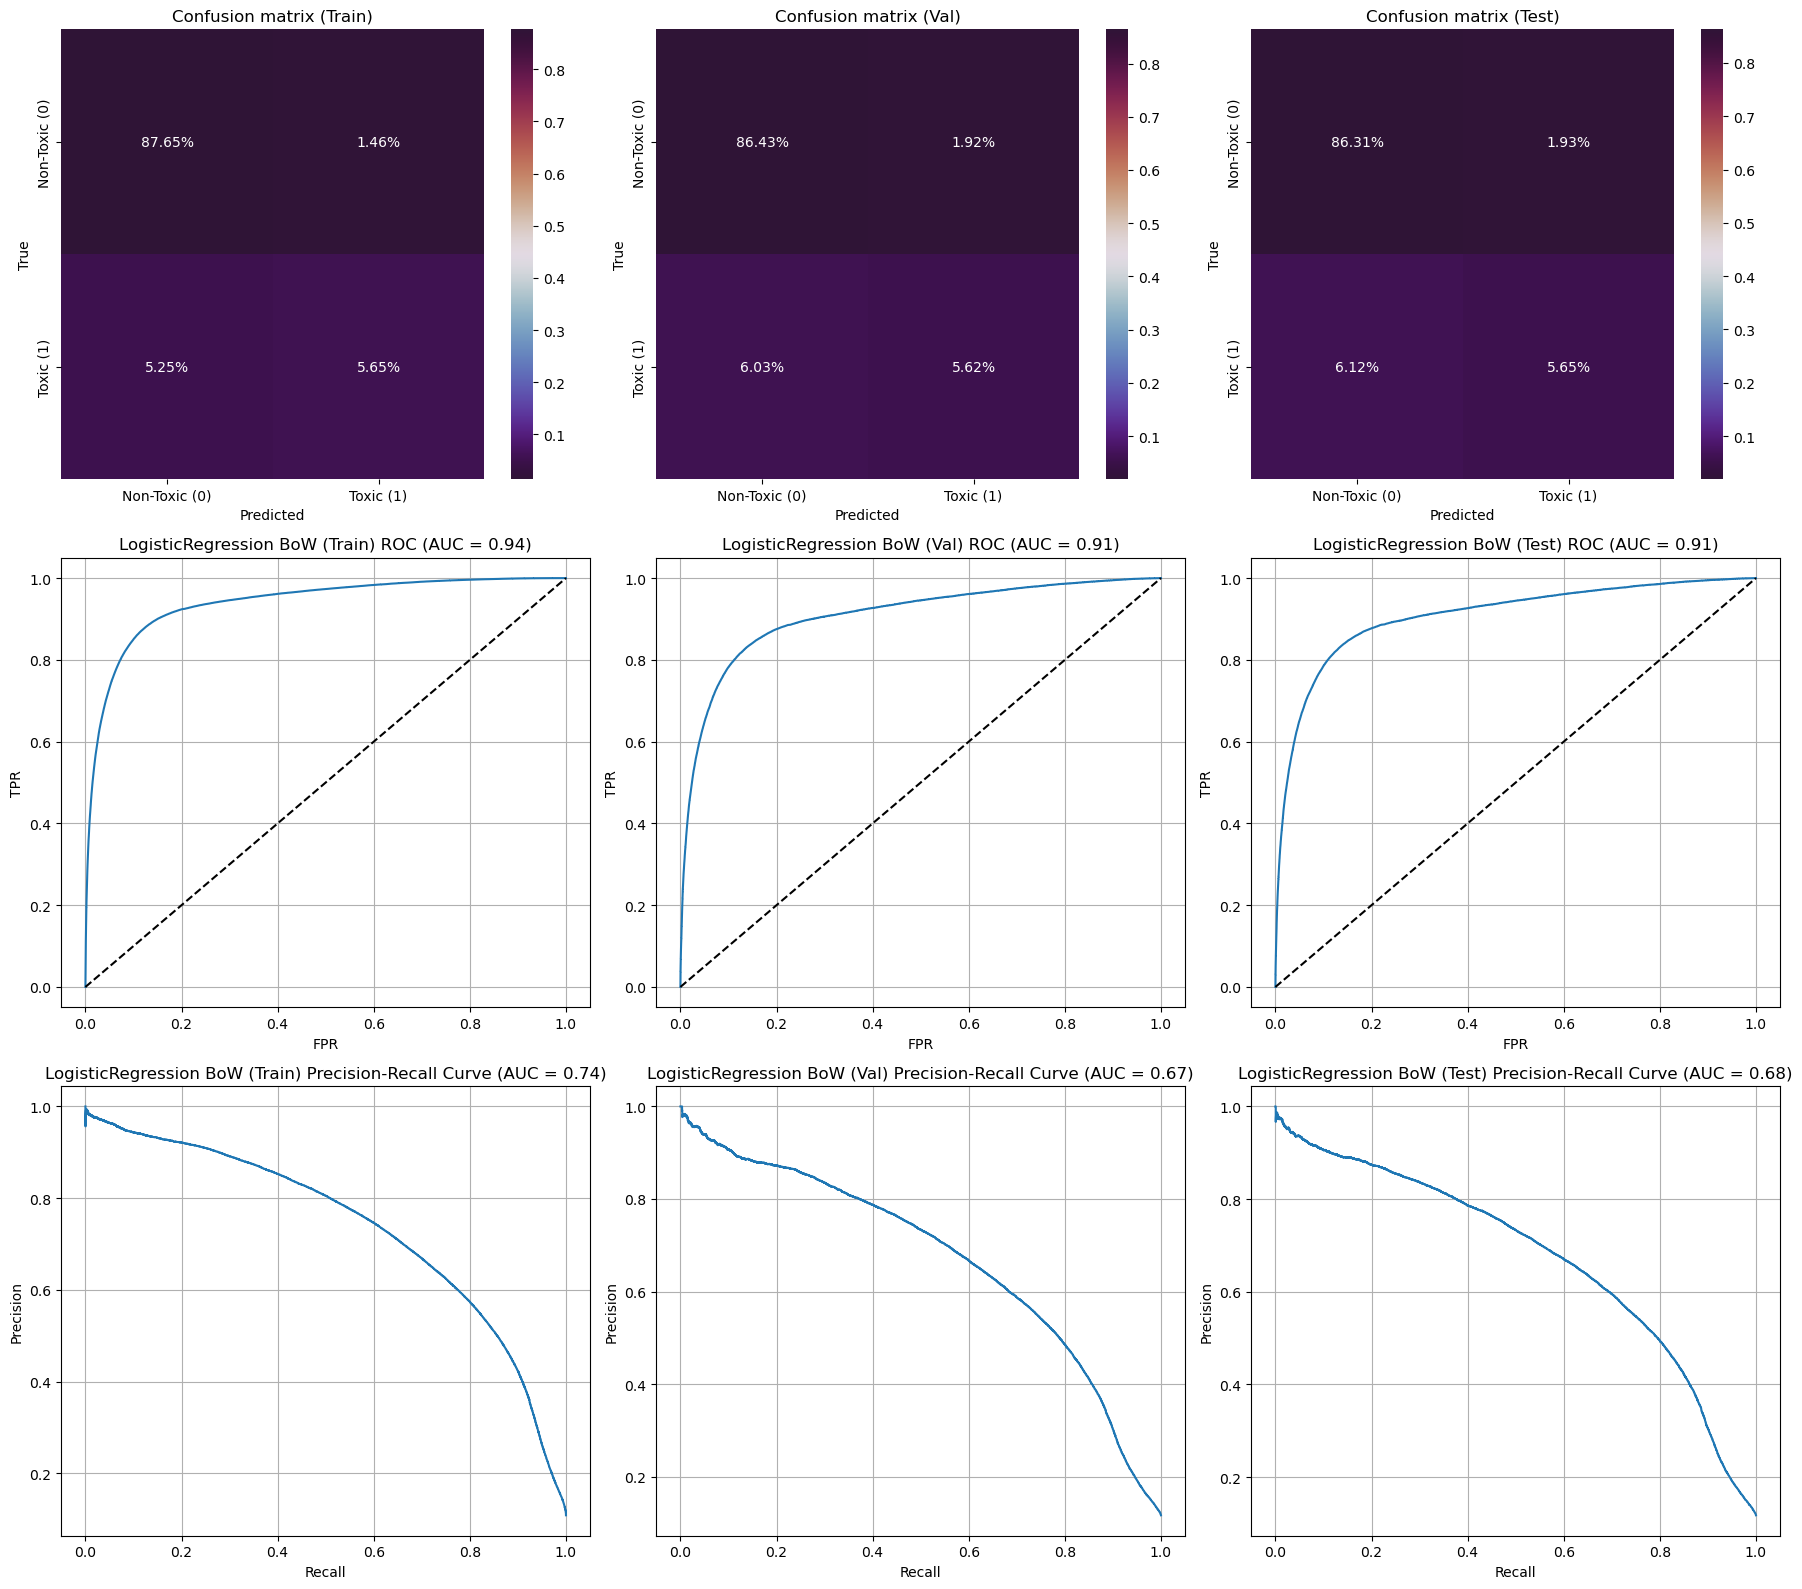

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_bow_pred_train,
    y_pred_val=y_log_reg_bow_pred_val,
    y_pred_test=y_log_reg_bow_pred_test,
    y_pred_proba_train=y_log_reg_bow_pred_proba_train,
    y_pred_proba_val=y_log_reg_bow_pred_proba_val,
    y_pred_proba_test=y_log_reg_bow_pred_proba_test,
    title='LogisticRegression BoW'
)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Train_Bow"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_train, y_log_reg_bow_pred_train, y_log_reg_bow_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Val_Bow"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_val, y_log_reg_bow_pred_val, y_log_reg_bow_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Test_Bow"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_test, y_log_reg_bow_pred_test, y_log_reg_bow_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
df_metrics

Model            Dataset                        Stage  \
0     Random_Classifier            Dataset                Simple models   
1   Most_Frequent_Class            Dataset                Simple models   
2  Sentiment_Classifier            Dataset                Simple models   
3   Logistic_Regression  Dataset_Train_Bow  ML models w/o hyperparamets   
4   Logistic_Regression    Dataset_Val_Bow  ML models w/o hyperparamets   
5   Logistic_Regression   Dataset_Test_Bow  ML models w/o hyperparamets   

   Accuracy  Precision  Recall  F1 Score  ROC AUC  
0      0.50       0.11    0.50      0.18      NaN  
1      0.89       0.00    0.00      0.00      NaN  
2      0.70       0.20    0.57      0.30      NaN  
3      0.93       0.79    0.52      0.63     0.94  
4      0.92       0.75    0.48      0.59     0.91  
5      0.92       0.75    0.48      0.58     0.91

### SVM

Хоть и говорилось, что модели будут обучаться без гиперпараметров, но в случае SVM модель крайне долго работает. Поэтому для обучения была взята оптмизированная модель `LinearSVM` с гиперпараметром `dual = False`, чтобы не решать двойственную задачу. Её в нашем случае решать не обязательно, так как количество переменных меньше количества наблюдений.

In [ ]:
(y_linear_svc_bow_pred_train,
 y_linear_svc_bow_pred_val,
 y_linear_svc_bow_pred_test,
 y_linear_svc_bow_pred_proba_train,
 y_linear_svc_bow_pred_proba_val,
 y_linear_svc_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LinearSVC(dual=False),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

SVM BoW

Precision		Recall			F1

Train: 0.86		Train: 0.60		Train: 0.71
Val: 0.72		Val: 0.48		Val: 0.58
Test: 0.71		Test: 0.48		Test: 0.57


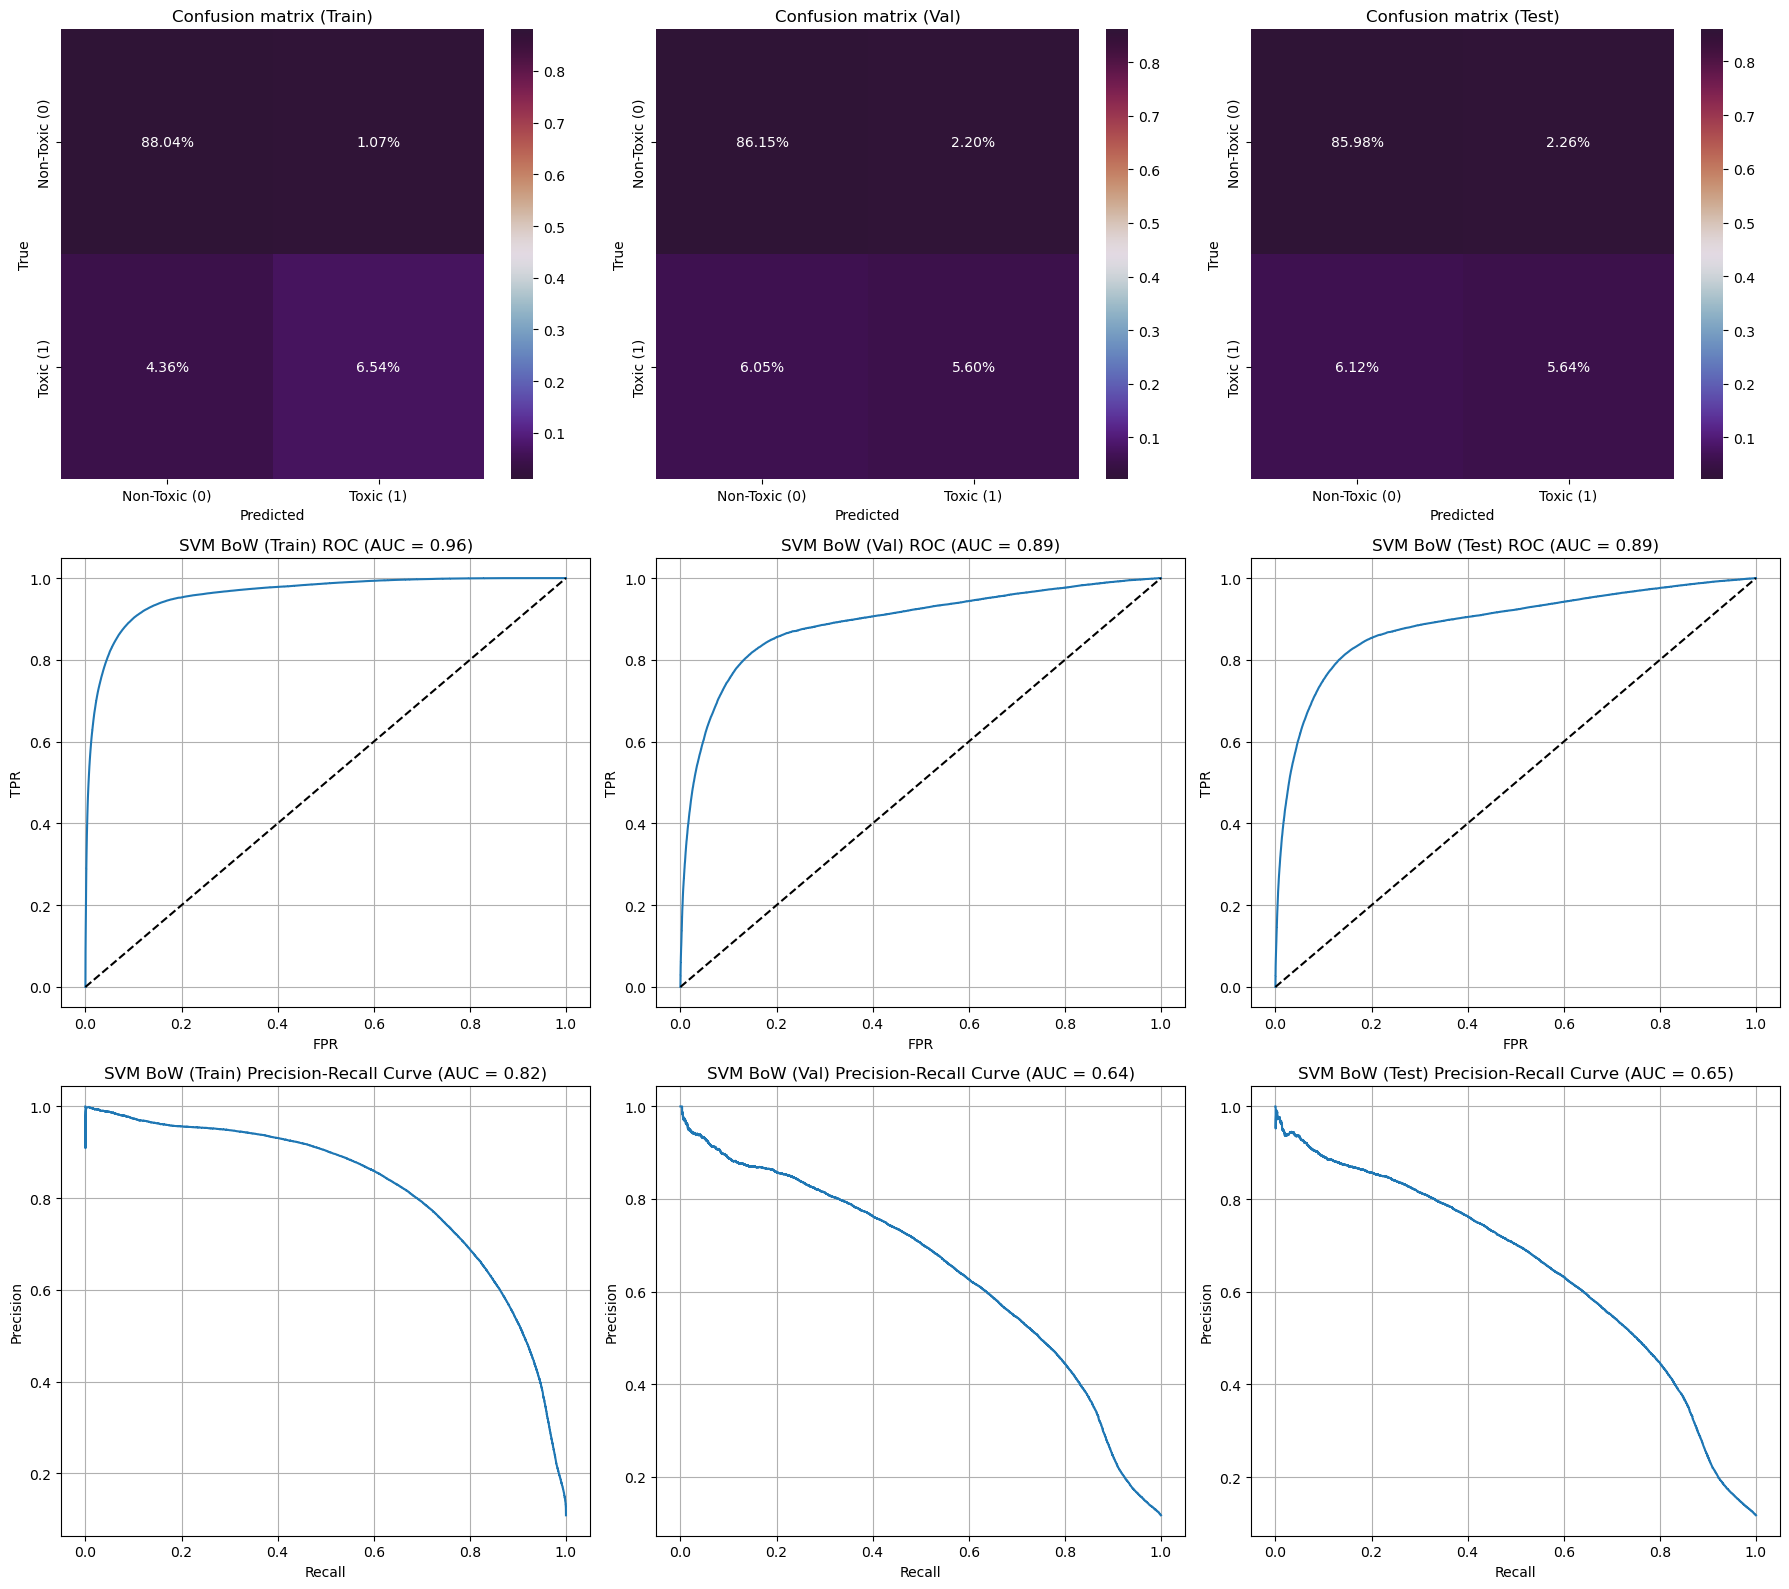

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_bow_pred_train,
    y_pred_val=y_linear_svc_bow_pred_val,
    y_pred_test=y_linear_svc_bow_pred_test,
    y_pred_proba_train=y_linear_svc_bow_pred_proba_train,
    y_pred_proba_val=y_linear_svc_bow_pred_proba_val,
    y_pred_proba_test=y_linear_svc_bow_pred_proba_test,
    title='SVM BoW'
)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Train_Bow"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_train, y_linear_svc_bow_pred_train, y_linear_svc_bow_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Val_Bow"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_val, y_linear_svc_bow_pred_val, y_linear_svc_bow_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Test_Bow"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_test, y_linear_svc_bow_pred_test, y_linear_svc_bow_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### Наивный Байес

#### Слова

In [ ]:
(y_nb_bow_pred_train,
 y_nb_bow_pred_val,
 y_nb_bow_pred_test,
 y_nb_bow_pred_proba_train,
 y_nb_bow_pred_proba_val,
 y_nb_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

MultinomialNB BoW

Precision		Recall			F1

Train: 0.50		Train: 0.63		Train: 0.56
Val: 0.48		Val: 0.61		Val: 0.54
Test: 0.51		Test: 0.59		Test: 0.54


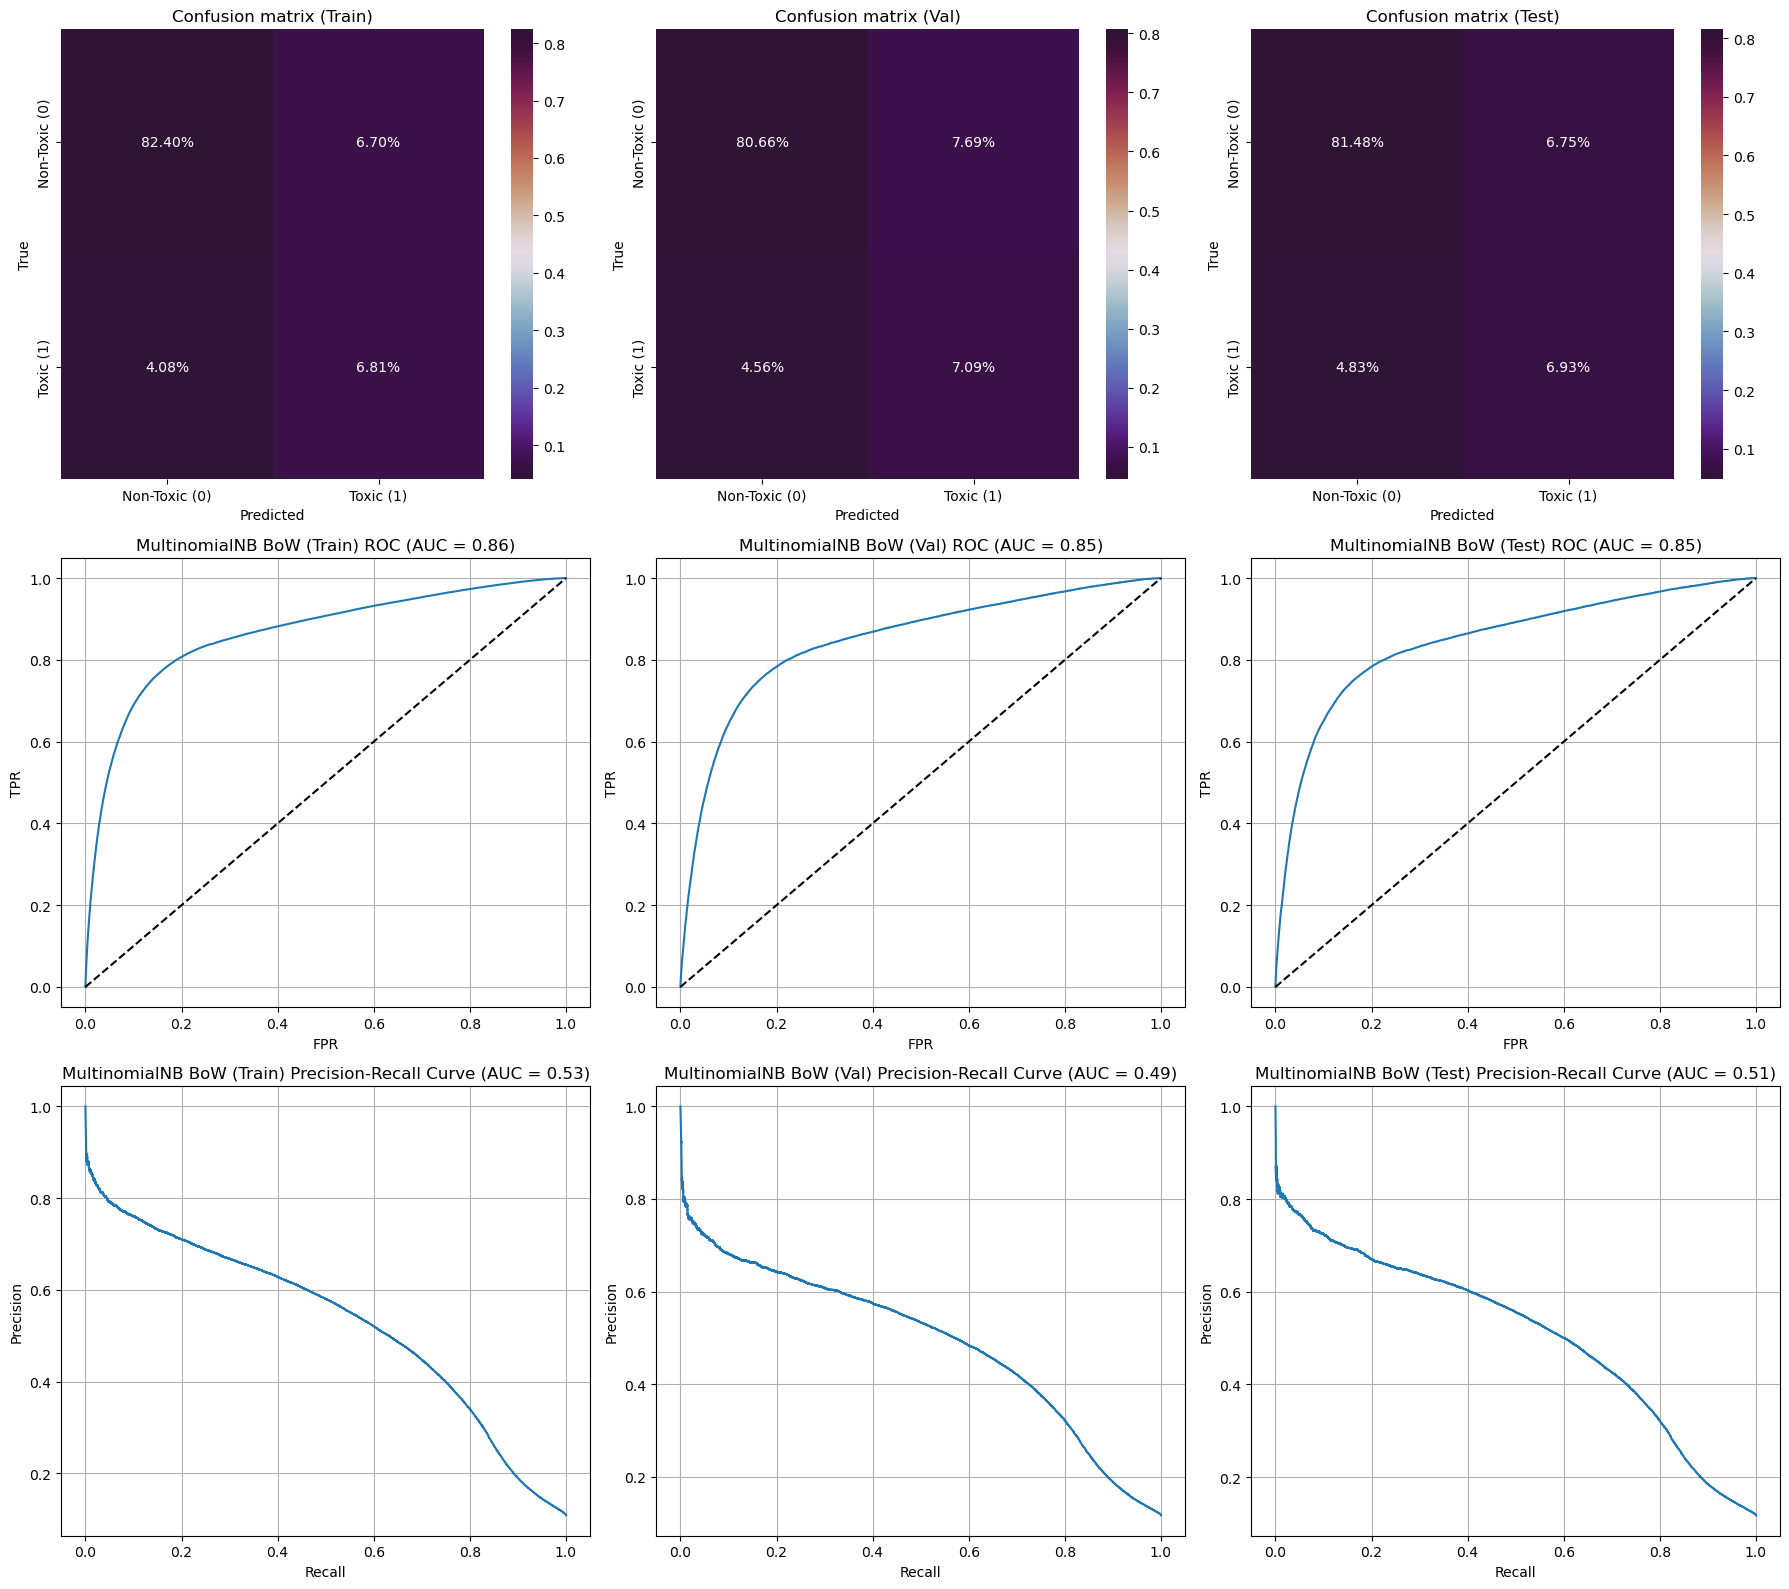

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_bow_pred_train,
    y_pred_val=y_nb_bow_pred_val,
    y_pred_test=y_nb_bow_pred_test,
    y_pred_proba_train=y_nb_bow_pred_proba_train,
    y_pred_proba_val=y_nb_bow_pred_proba_val,
    y_pred_proba_test=y_nb_bow_pred_proba_test,
    title='MultinomialNB BoW'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_Bow"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_train, y_nb_bow_pred_train, y_nb_bow_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Val_Bow"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_val, y_nb_bow_pred_val, y_nb_bow_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Test_Bow"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_test, y_nb_bow_pred_test, y_nb_bow_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

#### Биграммы

In [ ]:
X_train_bow_ngrams, X_val_bow_ngrams, X_test_bow_ngrams = get_bows(X_train, X_val, X_test, ngram_range=(1, 2))

In [ ]:
(
    y_nb_bow_ngrams_pred_train,
    y_nb_bow_ngrams_pred_val,
    y_nb_bow_ngrams_pred_test,
    y_nb_bow_ngrams_pred_proba_train,
    y_nb_bow_ngrams_pred_proba_val,
    y_nb_bow_ngrams_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(),
    X_train=X_train_bow_ngrams,
    X_val=X_val_bow_ngrams,
    X_test=X_test_bow_ngrams,
    y_train=y_train,
)

MultinomialNB BoW

Precision		Recall			F1

Train: 0.95		Train: 0.55		Train: 0.70
Val: 0.85		Val: 0.12		Val: 0.21
Test: 0.87		Test: 0.11		Test: 0.20


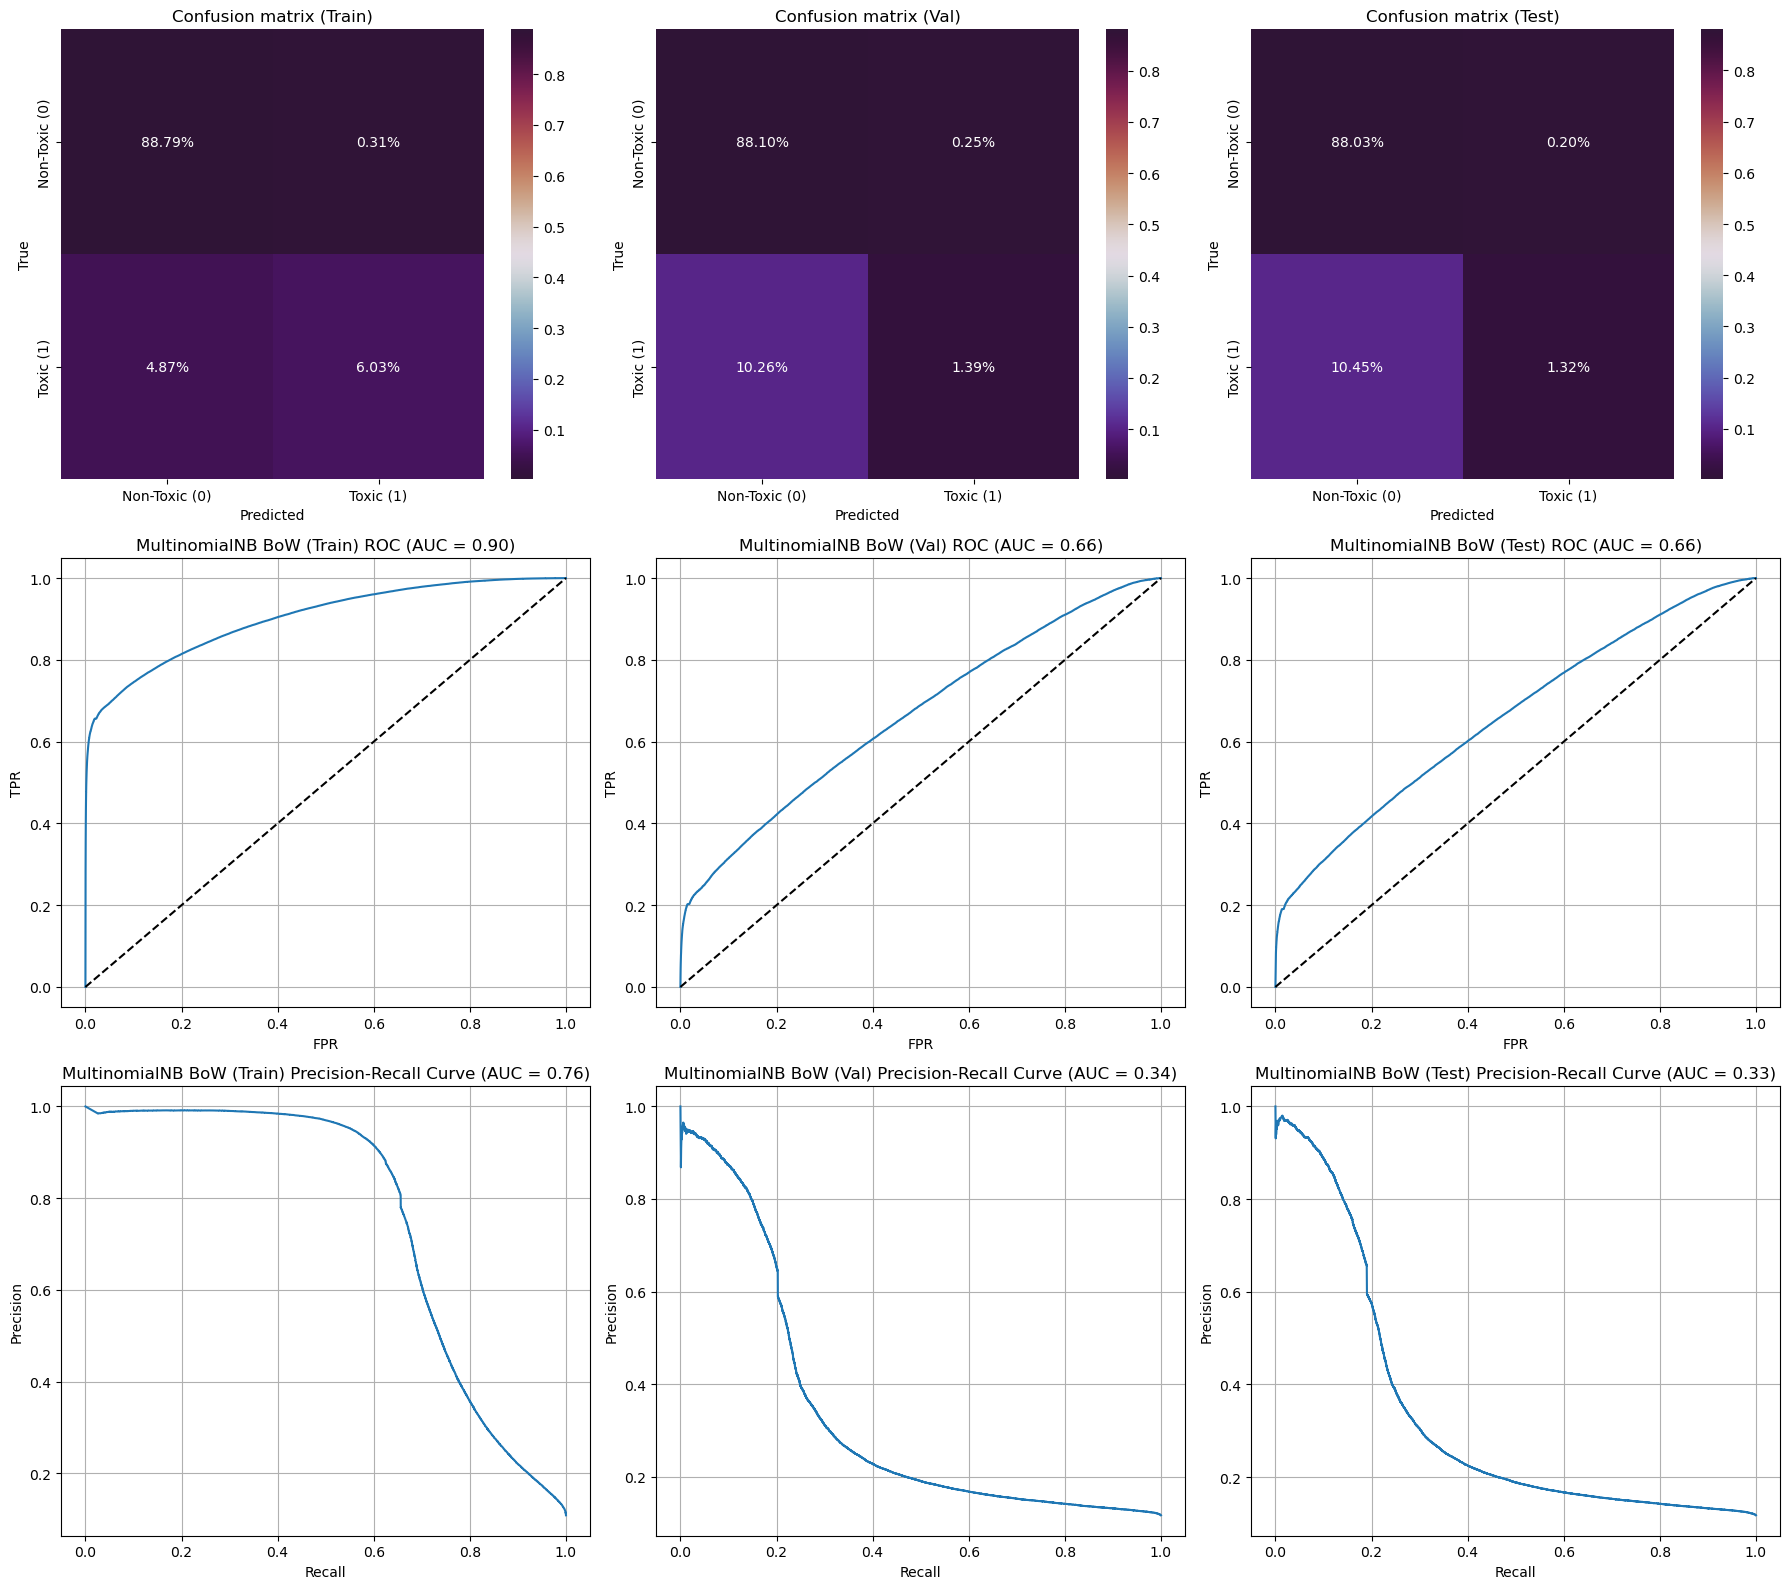

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_bow_ngrams_pred_train,
    y_pred_val=y_nb_bow_ngrams_pred_val,
    y_pred_test=y_nb_bow_ngrams_pred_test,
    y_pred_proba_train=y_nb_bow_ngrams_pred_proba_train,
    y_pred_proba_val=y_nb_bow_ngrams_pred_proba_val,
    y_pred_proba_test=y_nb_bow_ngrams_pred_proba_test,
    title='MultinomialNB BoW'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_Bow_Bigrams"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_train, y_nb_bow_ngrams_pred_train, y_nb_bow_ngrams_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Val_Bow_Bigrams"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_val, y_nb_bow_ngrams_pred_val, y_nb_bow_ngrams_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Test_Bow_Bigrams"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_test, y_nb_bow_ngrams_pred_test, y_nb_bow_ngrams_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
df_metrics[df_metrics.Stage == 'ML models w/o hyperparamets']

Model                    Dataset  \
3   Logistic_Regression          Dataset_Train_Bow   
4   Logistic_Regression            Dataset_Val_Bow   
5   Logistic_Regression           Dataset_Test_Bow   
6                   SVM          Dataset_Train_Bow   
7                   SVM            Dataset_Val_Bow   
8                   SVM           Dataset_Test_Bow   
9         MultinomialNB          Dataset_Train_Bow   
10        MultinomialNB            Dataset_Val_Bow   
11        MultinomialNB           Dataset_Test_Bow   
12        MultinomialNB  Dataset_Train_Bow_Bigrams   
13        MultinomialNB    Dataset_Val_Bow_Bigrams   
14        MultinomialNB   Dataset_Test_Bow_Bigrams   

                          Stage  Accuracy  Precision  Recall  F1 Score  \
3   ML models w/o hyperparamets      0.93       0.79    0.52      0.63   
4   ML models w/o hyperparamets      0.92       0.75    0.48      0.59   
5   ML models w/o hyperparamets      0.92       0.75    0.48      0.58   
6   ML models w/o hyperparamets      0.95       0.86    0.60      0.71   
7   ML models w/o hyperparamets      0.92       0.72    0.48      0.58   
8   ML models w/o hyperparamets      0.92       0.71    0.48      0.57   
9   ML models w/o hyperparamets      0.89       0.50    0.63      0.56   
10  ML models w/o hyperparamets      0.88       0.48    0.61      0.54   
11  ML models w/o hyperparamets      0.88       0.51    0.59      0.54   
12  ML models w/o hyperparamets      0.95       0.95    0.55      0.70   
13  ML models w/o hyperparamets      0.89       0.85    0.12      0.21   
14  ML models w/o hyperparamets      0.89       0.87    0.11      0.20   

    ROC AUC  
3      0.94  
4      0.91  
5      0.91  
6      0.96  
7      0.89  
8      0.89  
9      0.86  
10     0.85  
11     0.85  
12     0.90  
13     0.66  
14     0.66

Как можно заметить без подбора гиперпараметров лучше всего по метрике `F1` дает предсказания на валидационной и тестовой выборках модель `Logistic_Regression`. Второй наилучшей моделью является `Linear_SVC`, а затем уже идут модели `MultinomialNB` обученные на простом мешке слов и мешке слов с биграммами. Стоит отметить, что хуже всего с задачей предсказаний справляется `MultinomialNB` обученная на мешке слов с биграммами. Она переобучается на тренировочных данных, а затем выдает довольно плохие предсказания на валидационной и тестовой выборках, выдавая в качестве предсказания по большей части самый частый класс. Стоит также отметить, что у большинства обученных моделей идет перекос в сторону больших значений метрики `precision`, что говорит о том, что модели испытывают сложности с распознованием класса toxic.

## Обучение моделей с TF-IDF

In [36]:
X_train_tfidf, X_val_tfidf, X_test_tfidf = get_tfidf(X_train, X_val, X_test)

### Логистическая регрессия

In [ ]:
(y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_val,
    y_log_reg_tfidf_pred_test,
    y_log_reg_tfidf_pred_proba_train,
    y_log_reg_tfidf_pred_proba_val,
    y_log_reg_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

LogisticRegression TF-IDF

Precision		Recall			F1

Train: 0.79		Train: 0.49		Train: 0.60
Val: 0.78		Val: 0.48		Val: 0.59
Test: 0.78		Test: 0.48		Test: 0.59


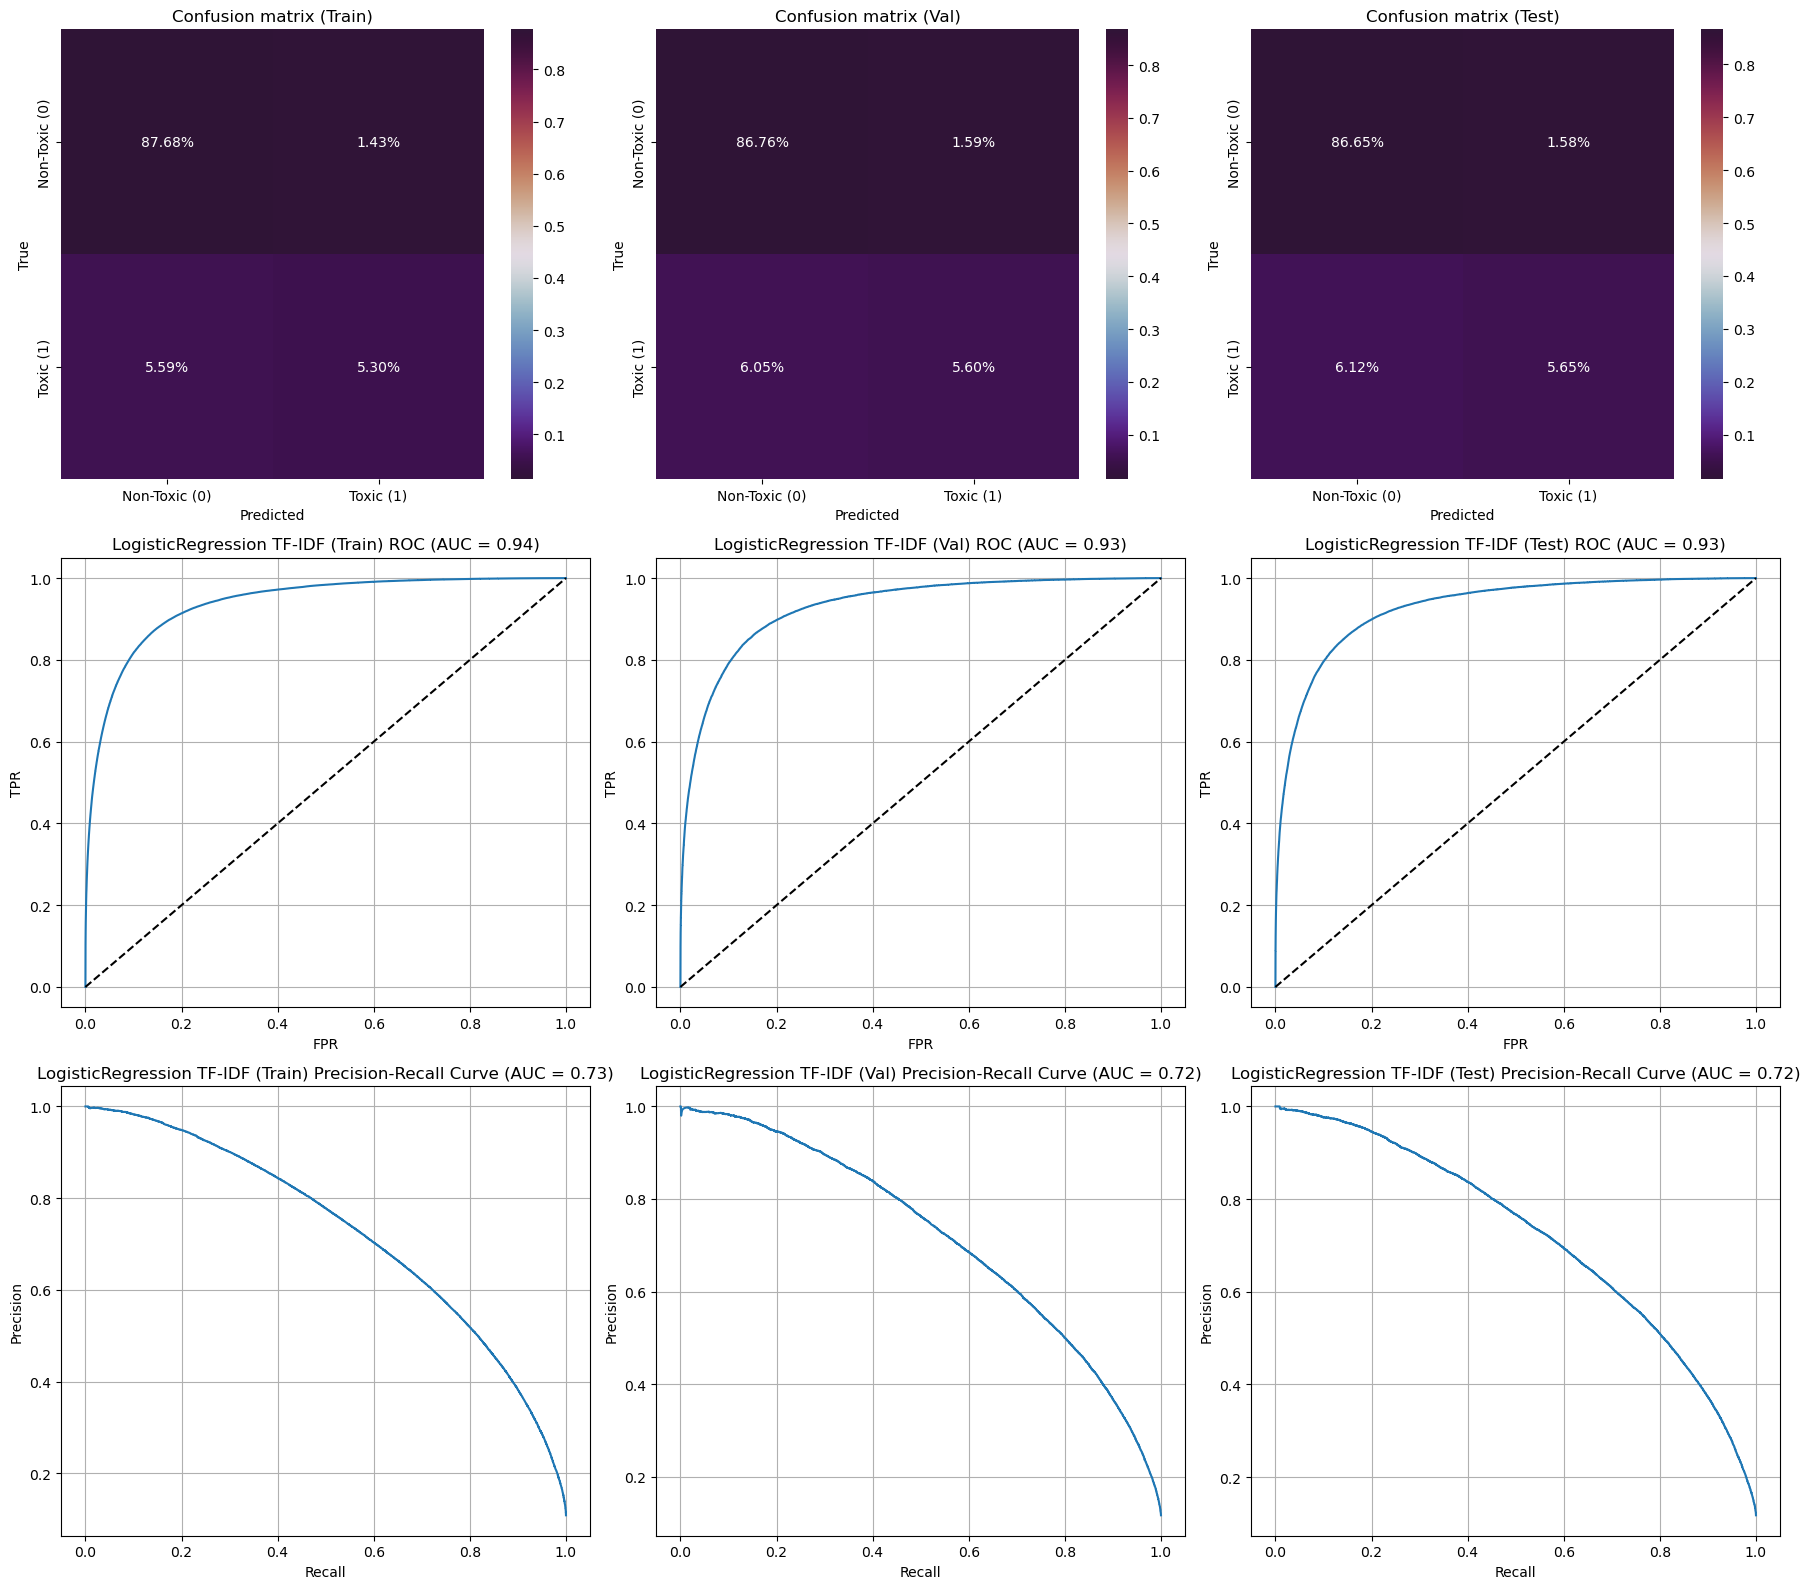

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_tfidf_pred_train,
    y_pred_val=y_log_reg_tfidf_pred_val,
    y_pred_test=y_log_reg_tfidf_pred_test,
    y_pred_proba_train=y_log_reg_tfidf_pred_proba_train,
    y_pred_proba_val=y_log_reg_tfidf_pred_proba_val,
    y_pred_proba_test=y_log_reg_tfidf_pred_proba_test,
    title='LogisticRegression TF-IDF'
)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Train_TF-IDF"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_train, y_log_reg_tfidf_pred_train, y_log_reg_tfidf_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Val_TF-IDF"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_val, y_log_reg_tfidf_pred_val, y_log_reg_tfidf_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Test_TF-IDF"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_test, y_log_reg_tfidf_pred_test, y_log_reg_tfidf_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### SVM

In [ ]:
(y_linear_svc_tfidf_pred_train,
    y_linear_svc_tfidf_pred_val,
    y_linear_svc_tfidf_pred_test,
    y_linear_svc_tfidf_pred_proba_train,
    y_linear_svc_tfidf_pred_proba_val,
    y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(model=LinearSVC(dual=False),
                               X_train=X_train_tfidf,
                               X_val=X_val_tfidf,
                               X_test=X_test_tfidf,
                               y_train=y_train)

SVM TF-IDF

Precision		Recall			F1

Train: 0.80		Train: 0.49		Train: 0.61
Val: 0.79		Val: 0.48		Val: 0.59
Test: 0.79		Test: 0.48		Test: 0.60


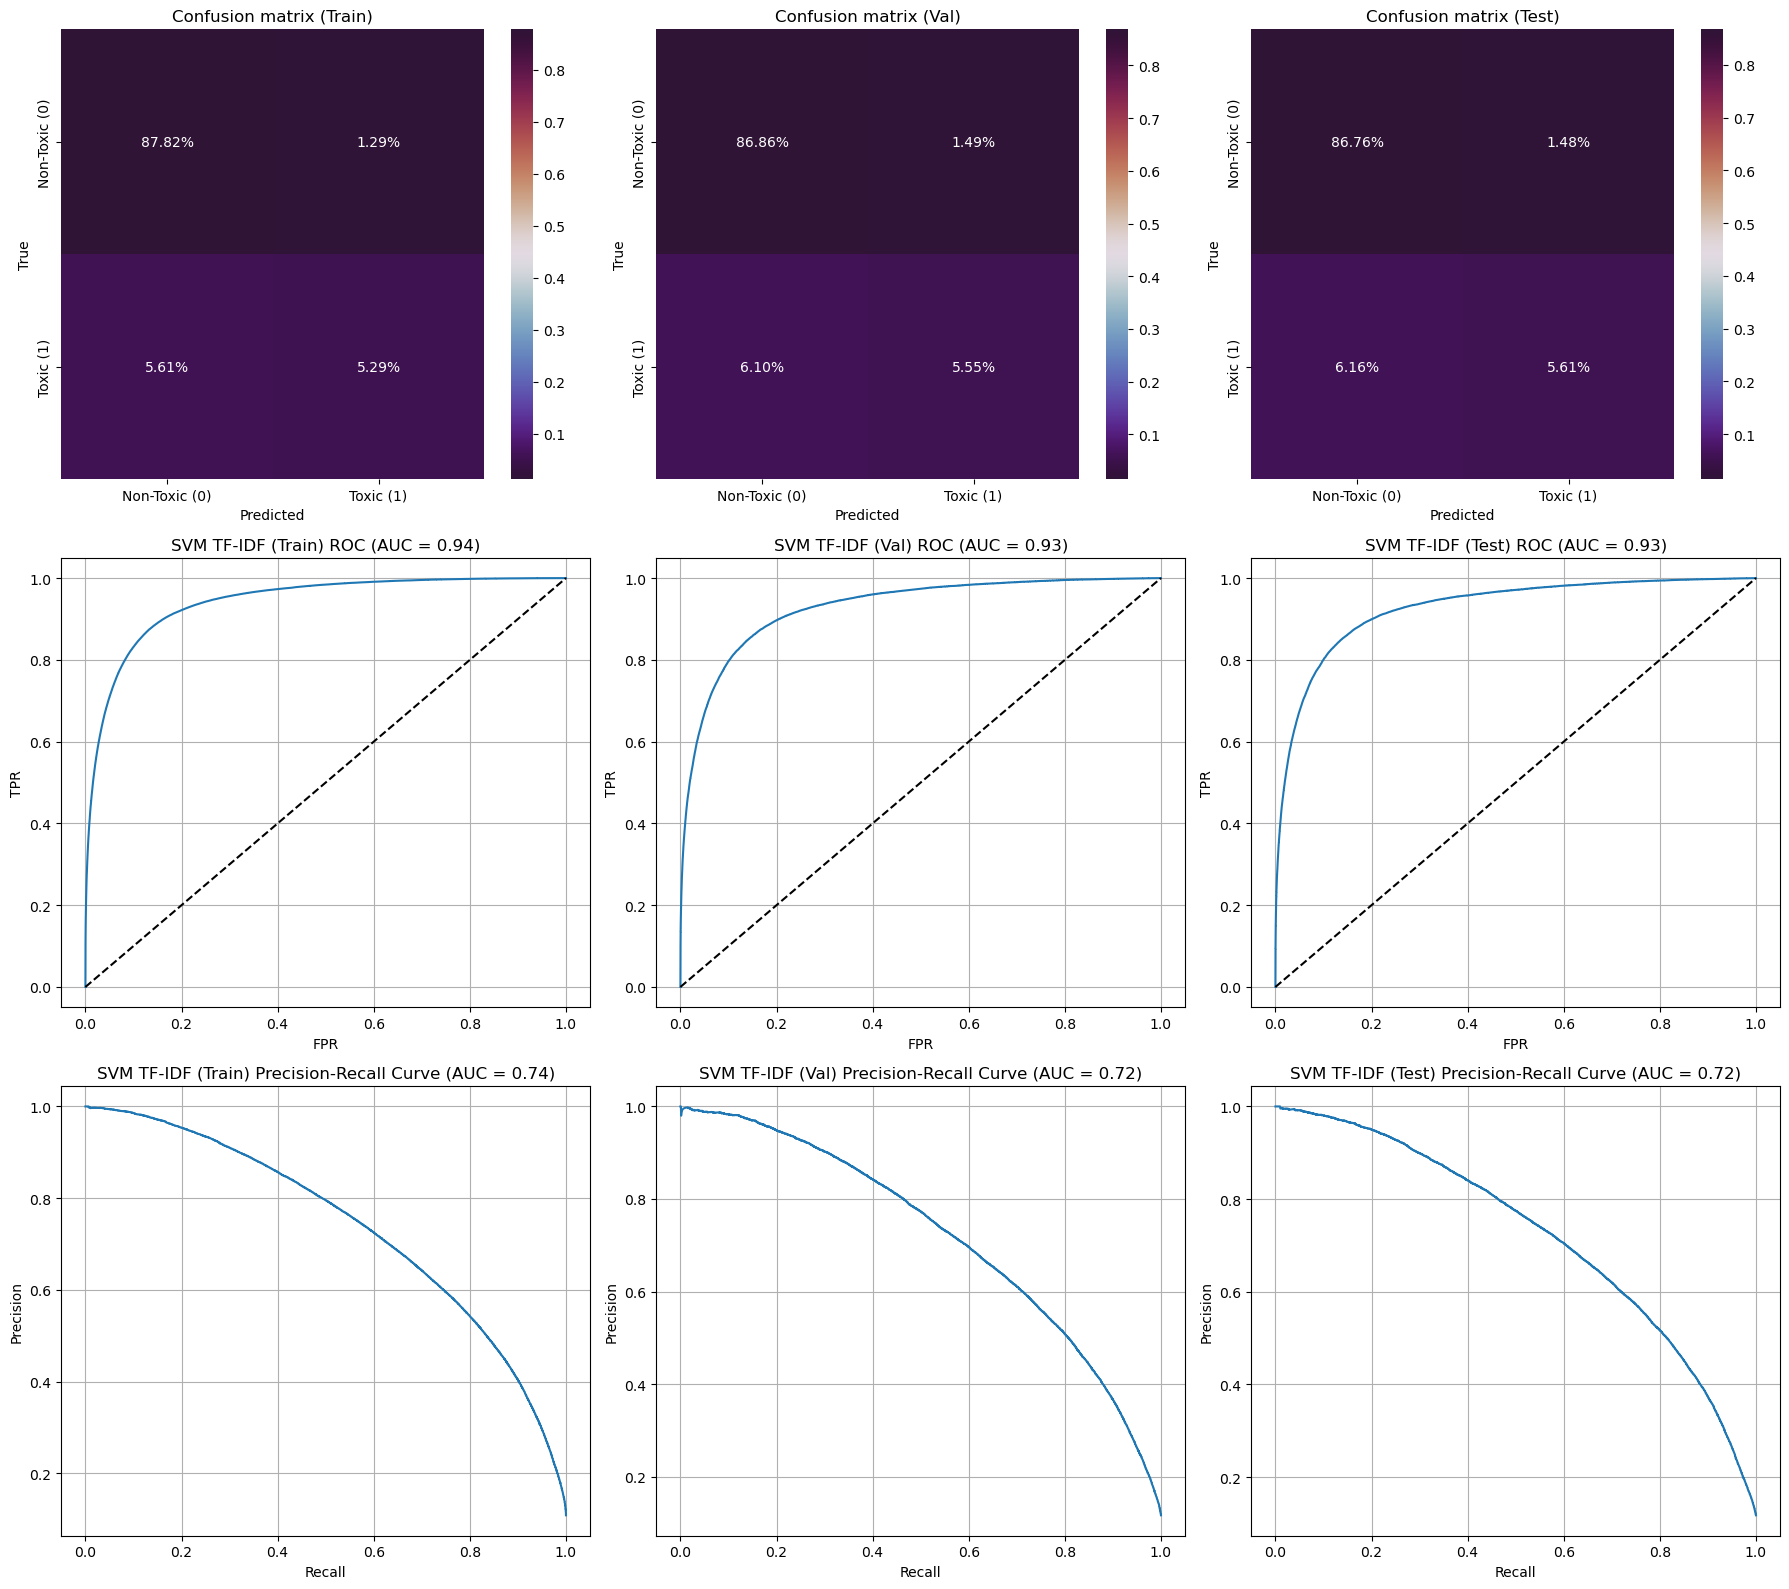

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_tfidf_pred_train,
    y_pred_val=y_linear_svc_tfidf_pred_val,
    y_pred_test=y_linear_svc_tfidf_pred_test,
    y_pred_proba_train=y_linear_svc_tfidf_pred_proba_train,
    y_pred_proba_val=y_linear_svc_tfidf_pred_proba_val,
    y_pred_proba_test=y_linear_svc_tfidf_pred_proba_test,
    title='SVM TF-IDF'
)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Train_TF-IDF"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_train, y_linear_svc_tfidf_pred_train, y_linear_svc_tfidf_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Val_TF-IDF"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_val, y_linear_svc_tfidf_pred_val, y_linear_svc_tfidf_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Test_TF-IDF"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_test, y_linear_svc_tfidf_pred_test, y_linear_svc_tfidf_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### Наивный Байес

#### Слова

In [ ]:
(
    y_nb_tfidf_pred_train,
    y_nb_tfidf_pred_val,
    y_nb_tfidf_pred_test,
    y_nb_tfidf_pred_proba_train,
    y_nb_tfidf_pred_proba_val,
    y_nb_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

MultinomialNB TF-IDF

Precision		Recall			F1

Train: 0.94		Train: 0.12		Train: 0.21
Val: 0.91		Val: 0.13		Val: 0.23
Test: 0.93		Test: 0.11		Test: 0.20


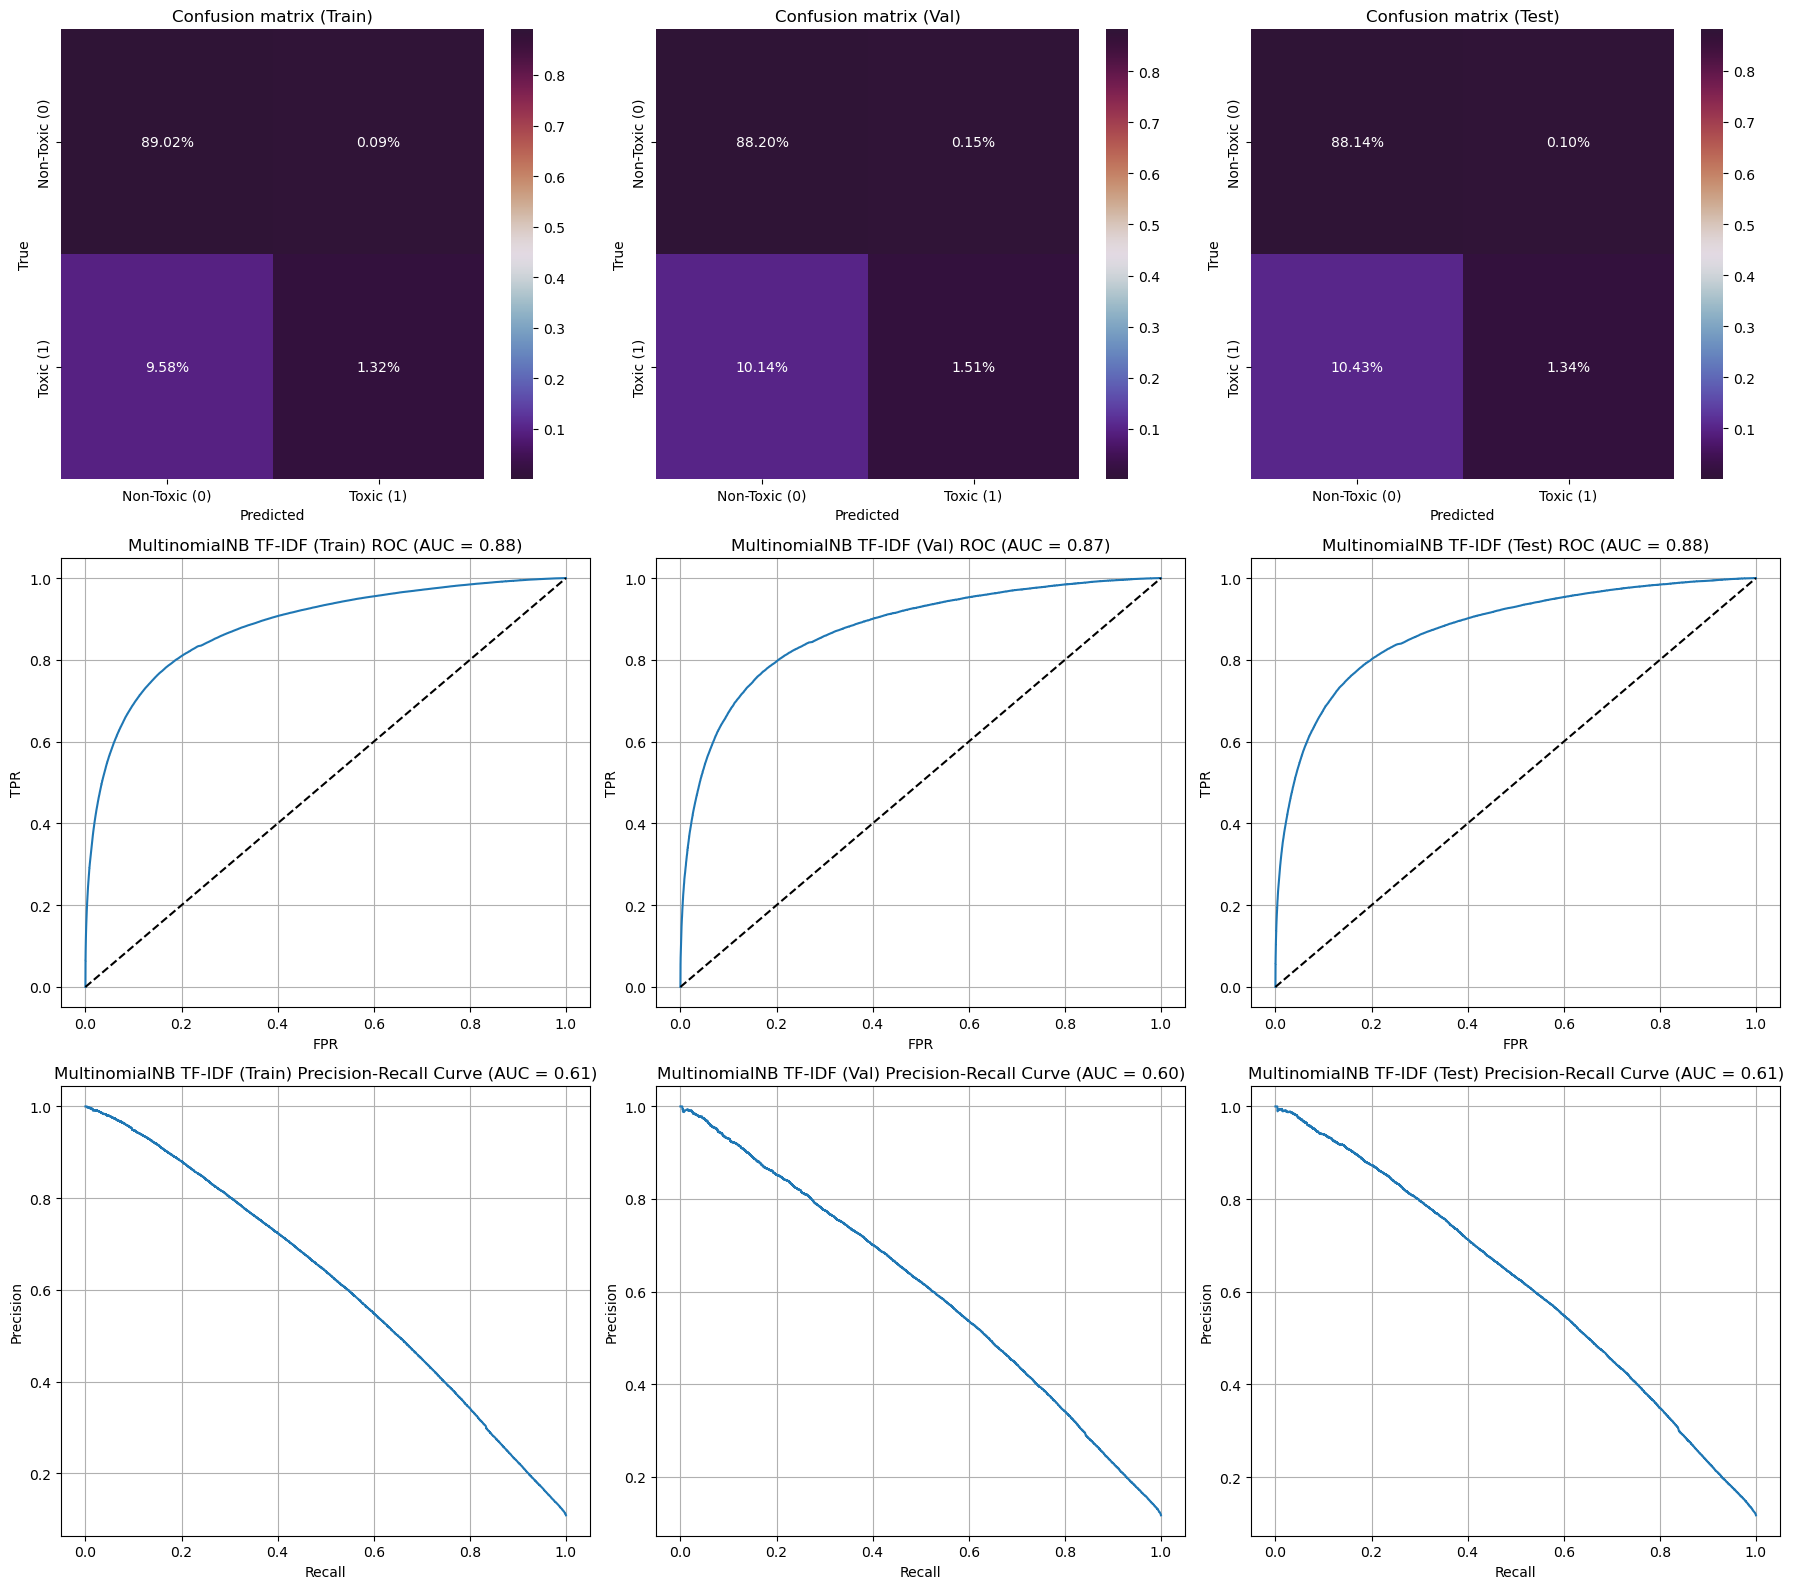

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_pred_train,
    y_pred_val=y_nb_tfidf_pred_val,
    y_pred_test=y_nb_tfidf_pred_test,
    y_pred_proba_train=y_nb_tfidf_pred_proba_train,
    y_pred_proba_val=y_nb_tfidf_pred_proba_val,
    y_pred_proba_test=y_nb_tfidf_pred_proba_test,
    title='MultinomialNB TF-IDF'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_TF-IDF"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_train, y_nb_tfidf_pred_train, y_nb_tfidf_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Val_TF-IDF"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_val, y_nb_tfidf_pred_val, y_nb_tfidf_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Test_TF-IDF"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_test, y_nb_tfidf_pred_test, y_nb_tfidf_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

#### Биграммы

In [ ]:
X_train_tfidf_ngrams, X_val_tfidf_ngrams, X_test_tfidf_ngrams = get_tfidf(X_train, X_val, X_test, ngram_range=(1, 2))

In [ ]:
(
    y_nb_tfidf_ngrams_pred_train,
    y_nb_tfidf_ngrams_pred_val,
    y_nb_tfidf_ngrams_pred_test,
    y_nb_tfidf_ngrams_pred_proba_train,
    y_nb_tfidf_ngrams_pred_proba_val,
    y_nb_tfidf_ngrams_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(),
    X_train=X_train_tfidf_ngrams,
    X_val=X_val_tfidf_ngrams,
    X_test=X_test_tfidf_ngrams,
    y_train=y_train,
)

MultinomialNB TF-IDF

Precision		Recall			F1

Train: 0.88		Train: 0.15		Train: 0.26
Val: 0.83		Val: 0.16		Val: 0.26
Test: 0.88		Test: 0.14		Test: 0.24


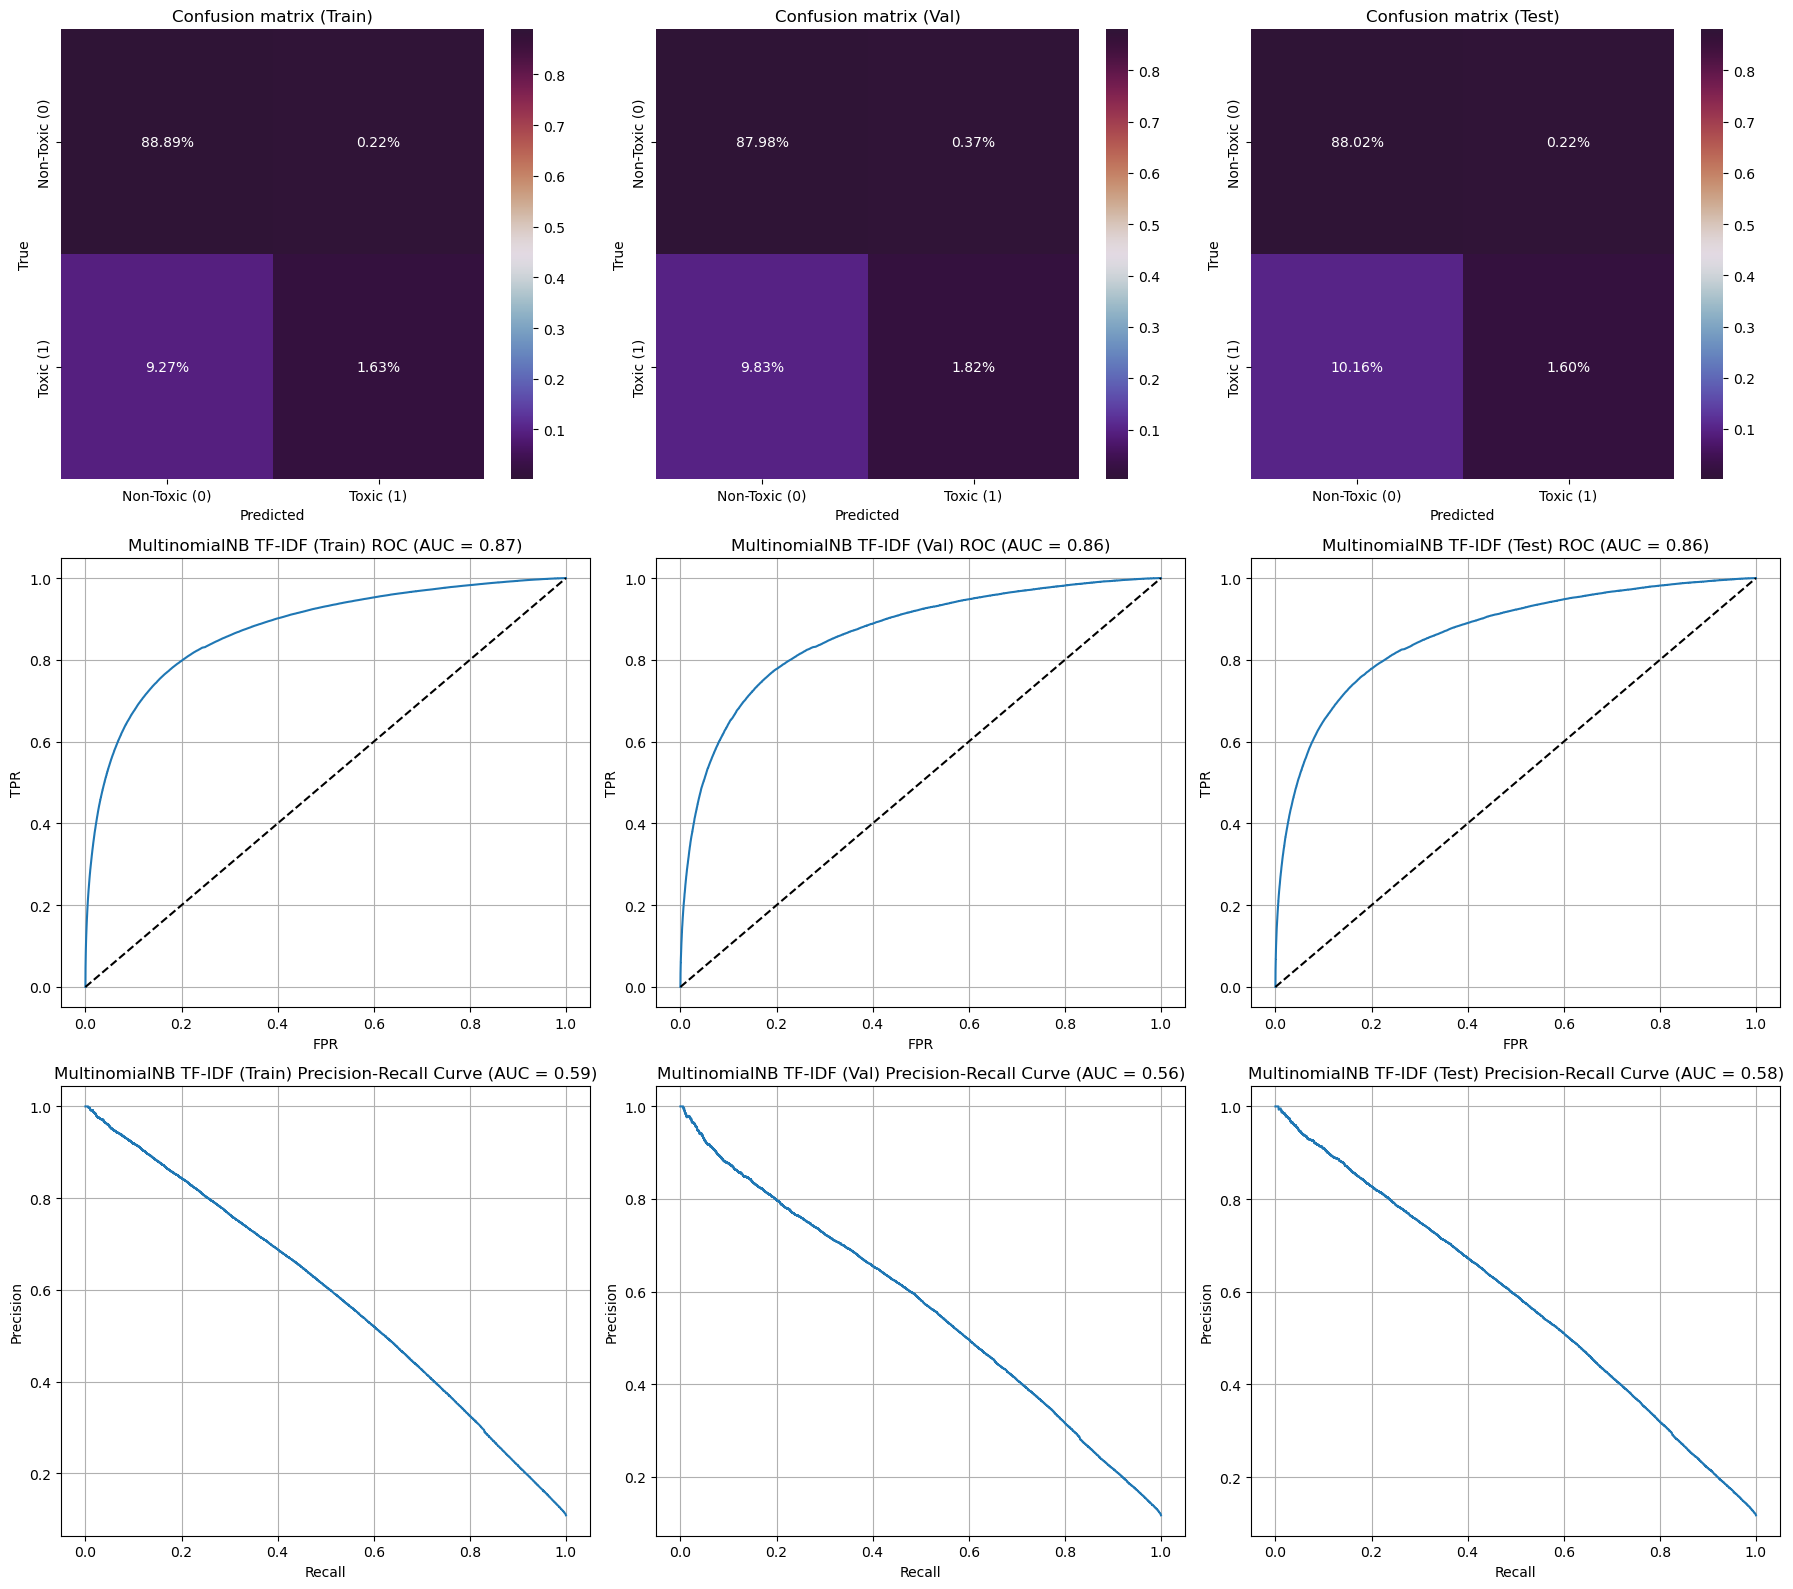

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_ngrams_pred_train,
    y_pred_val=y_nb_tfidf_ngrams_pred_val,
    y_pred_test=y_nb_tfidf_ngrams_pred_test,
    y_pred_proba_train=y_nb_tfidf_ngrams_pred_proba_train,
    y_pred_proba_val=y_nb_tfidf_ngrams_pred_proba_val,
    y_pred_proba_test=y_nb_tfidf_ngrams_pred_proba_test,
    title='MultinomialNB TF-IDF'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_TF-IDF_Bigrams"
stage = 'ML models w/o hyperparamets'
metrics = classification_metrics(y_train, y_nb_tfidf_ngrams_pred_train, y_nb_tfidf_ngrams_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_TF-IDF_Bigrams"
metrics = classification_metrics(y_val, y_nb_tfidf_ngrams_pred_val, y_nb_tfidf_ngrams_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_TF-IDF_Bigrams"
metrics = classification_metrics(y_test, y_nb_tfidf_ngrams_pred_test, y_nb_tfidf_ngrams_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
df_metrics = pd.read_csv('metricsbc.csv', index_col=0)
df_metrics.loc[15:26]

Model                       Dataset  \
15  Logistic_Regression          Dataset_Train_TF-IDF   
16  Logistic_Regression            Dataset_Val_TF-IDF   
17  Logistic_Regression           Dataset_Test_TF-IDF   
18                  SVM          Dataset_Train_TF-IDF   
19                  SVM            Dataset_Val_TF-IDF   
20                  SVM           Dataset_Test_TF-IDF   
21        MultinomialNB          Dataset_Train_TF-IDF   
22        MultinomialNB            Dataset_Val_TF-IDF   
23        MultinomialNB           Dataset_Test_TF-IDF   
24        MultinomialNB  Dataset_Train_TF-IDF_Bigrams   
25        MultinomialNB    Dataset_Val_TF-IDF_Bigrams   
26        MultinomialNB   Dataset_Test_TF-IDF_Bigrams   

                          Stage  Accuracy  Precision  Recall  F1 Score  \
15  ML models w/o hyperparamets      0.93       0.79    0.49      0.60   
16  ML models w/o hyperparamets      0.92       0.78    0.48      0.59   
17  ML models w/o hyperparamets      0.92       0.78    0.48      0.59   
18  ML models w/o hyperparamets      0.93       0.80    0.49      0.61   
19  ML models w/o hyperparamets      0.92       0.79    0.48      0.59   
20  ML models w/o hyperparamets      0.92       0.79    0.48      0.60   
21  ML models w/o hyperparamets      0.90       0.94    0.12      0.21   
22  ML models w/o hyperparamets      0.90       0.91    0.13      0.23   
23  ML models w/o hyperparamets      0.89       0.93    0.11      0.20   
24  ML models w/o hyperparamets      0.91       0.88    0.15      0.26   
25  ML models w/o hyperparamets      0.90       0.83    0.16      0.26   
26  ML models w/o hyperparamets      0.90       0.88    0.14      0.24   

    ROC AUC  
15     0.94  
16     0.93  
17     0.93  
18     0.94  
19     0.93  
20     0.93  
21     0.88  
22     0.87  
23     0.88  
24     0.87  
25     0.86  
26     0.86

В целом ситуация осталсь примерно такой же как и при обучении на BoW. Однако метрики у двух лучших моделей в плане `F-1` немного подросли и теперь лучше всего предсказывает модель `Linear_SVC`. Также можно отметить, что метрики модели `MultinomialNB` без биграмм сильно просели по сравнению с обучением на BoW.

# Обучение моделей с гиперпараметрами

## Обучение моделей с мешком слов

### Логистическая регрессия

In [ ]:
(y_log_reg_bow_pred_train,
 y_log_reg_bow_pred_val,
 y_log_reg_bow_pred_test,
 y_log_reg_bow_pred_proba_train,
 y_log_reg_bow_pred_proba_val,
 y_log_reg_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(C=0.07, class_weight='balanced', max_iter=2000, n_jobs=-1),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

LogisticRegression BoW

Precision		Recall			F1

Train: 0.53		Train: 0.84		Train: 0.65
Val: 0.51		Val: 0.80		Val: 0.62
Test: 0.51		Test: 0.80		Test: 0.63


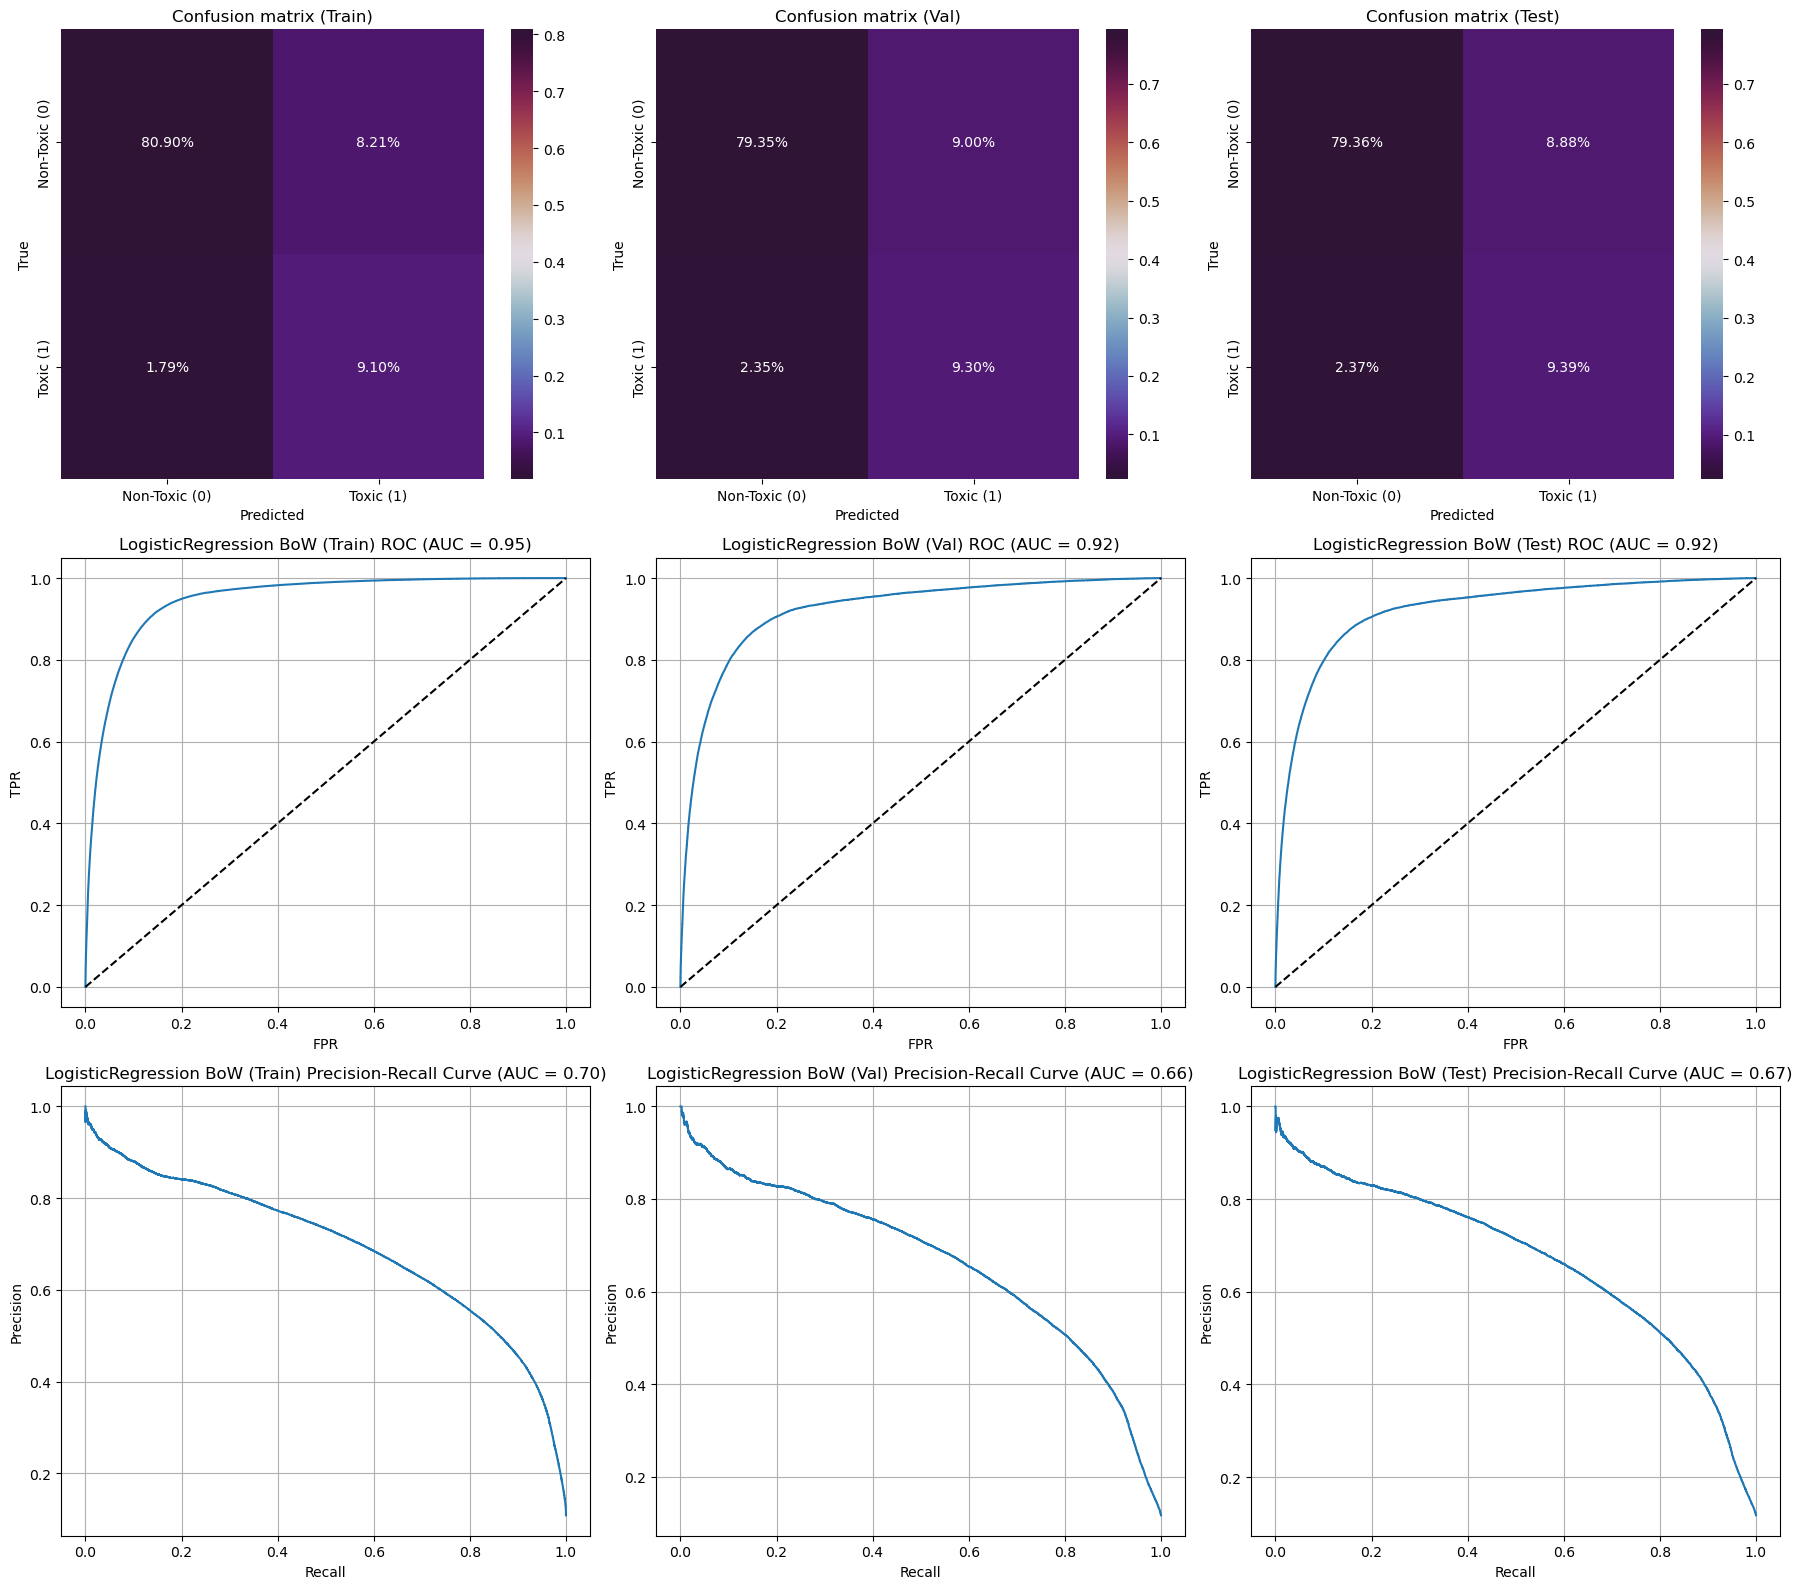

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_bow_pred_train,
    y_pred_val=y_log_reg_bow_pred_val,
    y_pred_test=y_log_reg_bow_pred_test,
    y_pred_proba_train=y_log_reg_bow_pred_proba_train,
    y_pred_proba_val=y_log_reg_bow_pred_proba_val,
    y_pred_proba_test=y_log_reg_bow_pred_proba_test,
    title='LogisticRegression BoW'
)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Train_Bow"
stage = 'ML models'
metrics = classification_metrics(y_train, y_log_reg_bow_pred_train, y_log_reg_bow_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_Bow"
metrics = classification_metrics(y_val, y_log_reg_bow_pred_val, y_log_reg_bow_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_Bow"
metrics = classification_metrics(y_test, y_log_reg_bow_pred_test, y_log_reg_bow_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### SVM

In [ ]:
(y_linear_svc_bow_pred_train,
 y_linear_svc_bow_pred_val,
 y_linear_svc_bow_pred_test,
 y_linear_svc_bow_pred_proba_train,
 y_linear_svc_bow_pred_proba_val,
 y_linear_svc_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LinearSVC(dual=False, penalty = 'l1', C = 0.1, class_weight='balanced'),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

SVM BoW

Precision		Recall			F1

Train: 0.54		Train: 0.83		Train: 0.66
Val: 0.52		Val: 0.78		Val: 0.62
Test: 0.52		Test: 0.78		Test: 0.63


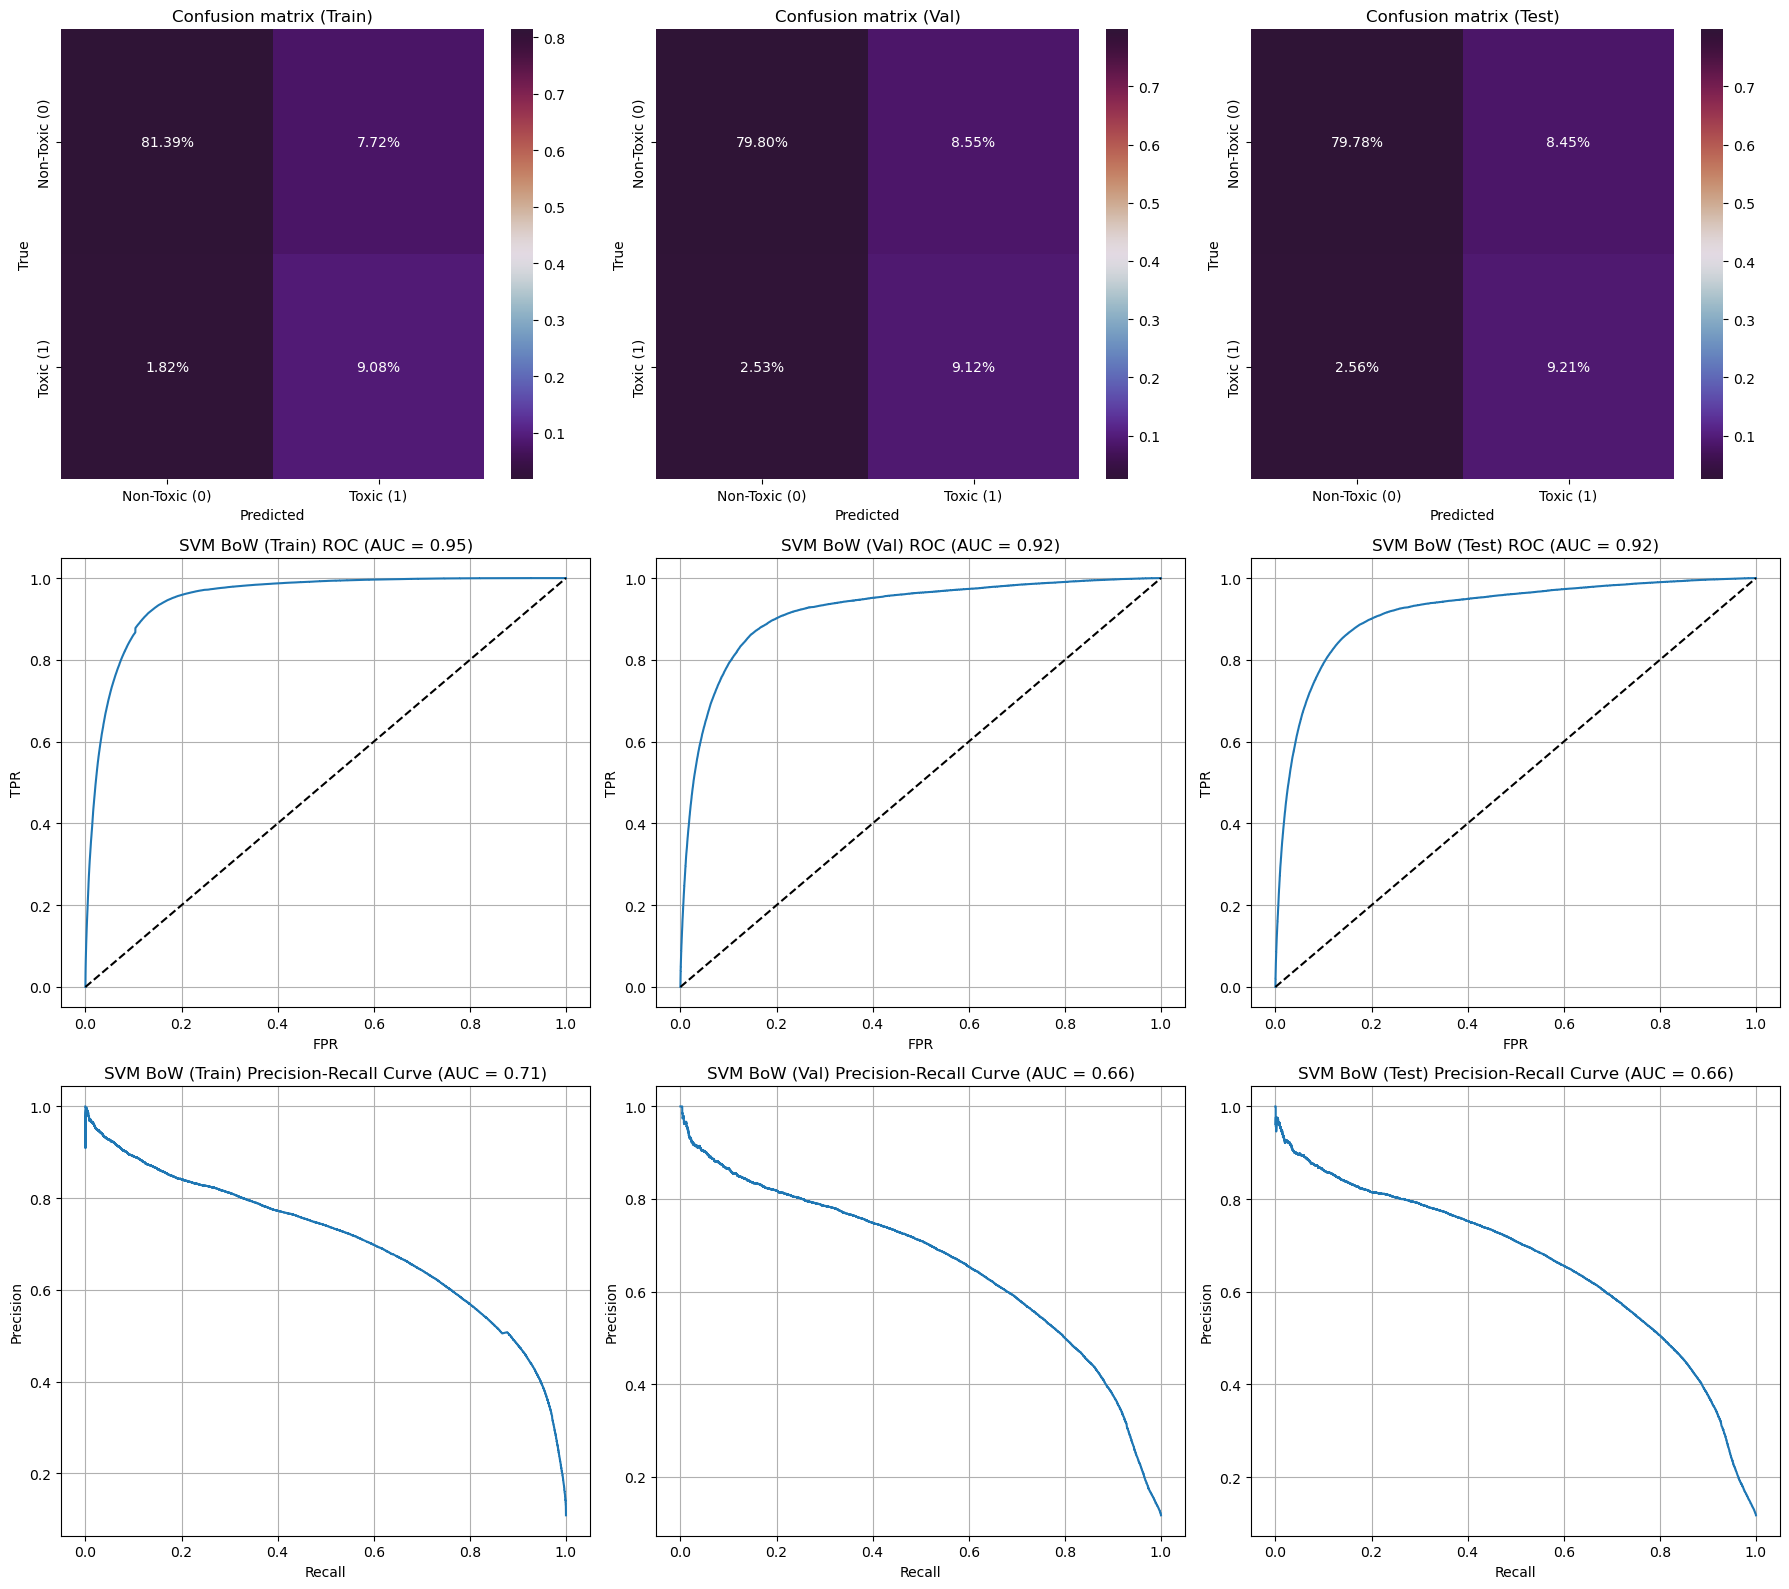

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_bow_pred_train,
    y_pred_val=y_linear_svc_bow_pred_val,
    y_pred_test=y_linear_svc_bow_pred_test,
    y_pred_proba_train=y_linear_svc_bow_pred_proba_train,
    y_pred_proba_val=y_linear_svc_bow_pred_proba_val,
    y_pred_proba_test=y_linear_svc_bow_pred_proba_test,
    title='SVM BoW'
)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Train_Bow"
stage = 'ML models'
metrics = classification_metrics(y_train, y_linear_svc_bow_pred_train, y_linear_svc_bow_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_Bow"
metrics = classification_metrics(y_val, y_linear_svc_bow_pred_val, y_linear_svc_bow_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_Bow"
metrics = classification_metrics(y_test, y_linear_svc_bow_pred_test, y_linear_svc_bow_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### Наивный Байес

#### Слова

In [ ]:

(
    y_nb_bow_pred_train,
    y_nb_bow_pred_val,
    y_nb_bow_pred_test,
    y_nb_bow_pred_proba_train,
    y_nb_bow_pred_proba_val,
    y_nb_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=1.5),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

MultinomialNB BoW

Precision		Recall			F1

Train: 0.53		Train: 0.58		Train: 0.55
Val: 0.51		Val: 0.57		Val: 0.54
Test: 0.53		Test: 0.55		Test: 0.54


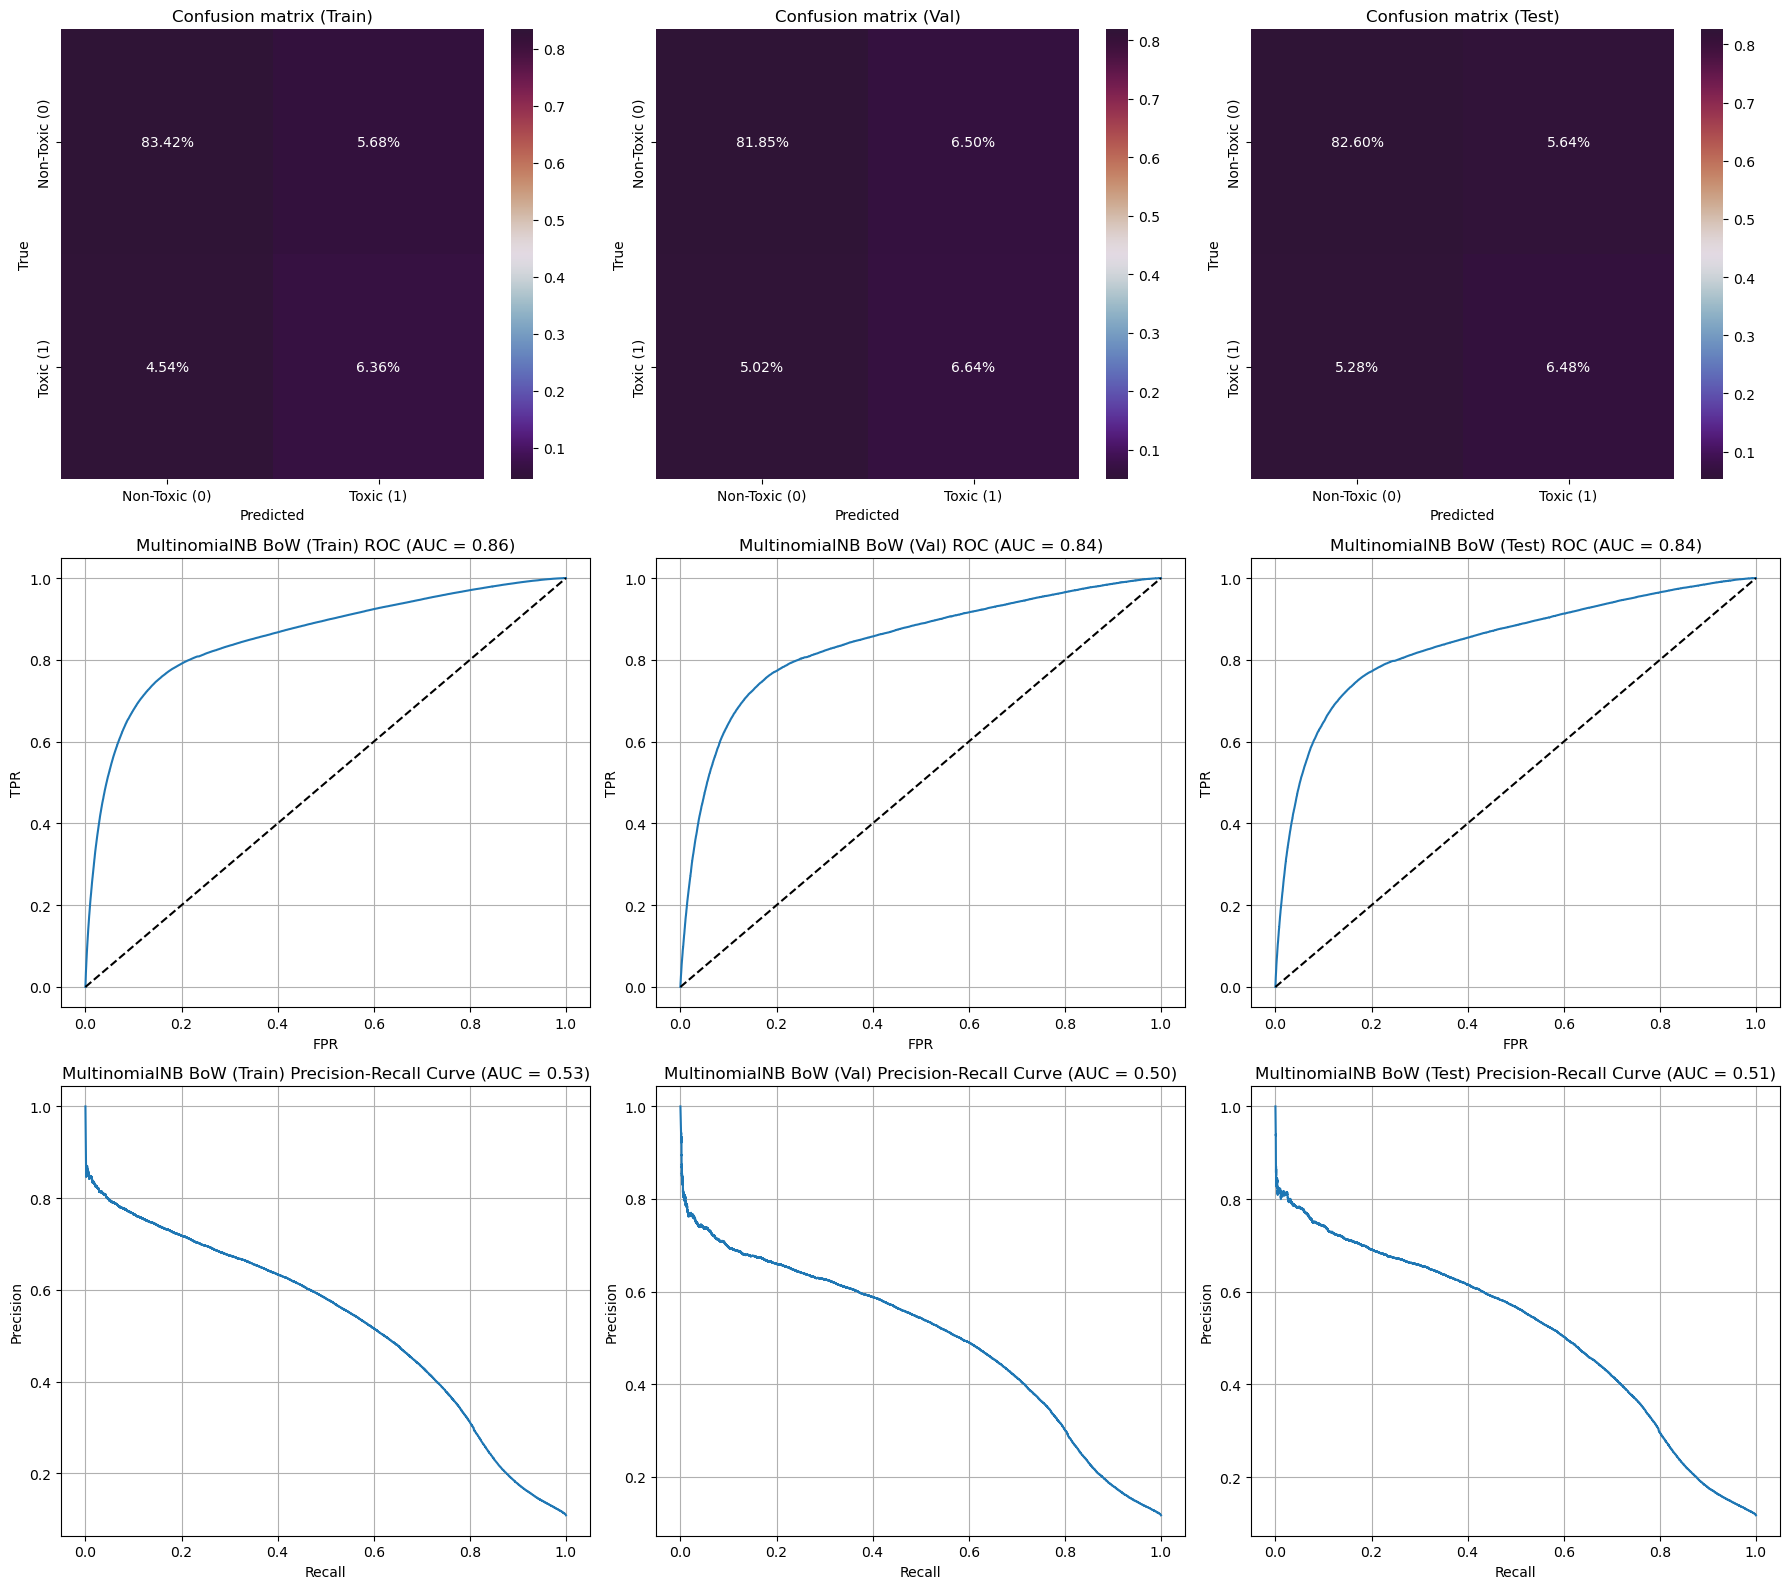

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_bow_pred_train,
    y_pred_val=y_nb_bow_pred_val,
    y_pred_test=y_nb_bow_pred_test,
    y_pred_proba_train=y_nb_bow_pred_proba_train,
    y_pred_proba_val=y_nb_bow_pred_proba_val,
    y_pred_proba_test=y_nb_bow_pred_proba_test,
    title='MultinomialNB BoW'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_Bow"
stage = 'ML models'
metrics = classification_metrics(y_train, y_nb_bow_pred_train, y_nb_bow_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_Bow"
metrics = classification_metrics(y_val, y_nb_bow_pred_val, y_nb_bow_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_Bow"
metrics = classification_metrics(y_test, y_nb_bow_pred_test, y_nb_bow_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

#### Биграммы

In [ ]:
(
    y_nb_bow_ngrams_pred_train,
    y_nb_bow_ngrams_pred_val,
    y_nb_bow_ngrams_pred_test,
    y_nb_bow_ngrams_pred_proba_train,
    y_nb_bow_ngrams_pred_proba_val,
    y_nb_bow_ngrams_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=0.1),
    X_train=X_train_bow_ngrams,
    X_val=X_val_bow_ngrams,
    X_test=X_test_bow_ngrams,
    y_train=y_train,
)

MultinomialNB BoW

Precision		Recall			F1

Train: 0.80		Train: 0.98		Train: 0.88
Val: 0.47		Val: 0.53		Val: 0.50
Test: 0.49		Test: 0.51		Test: 0.50


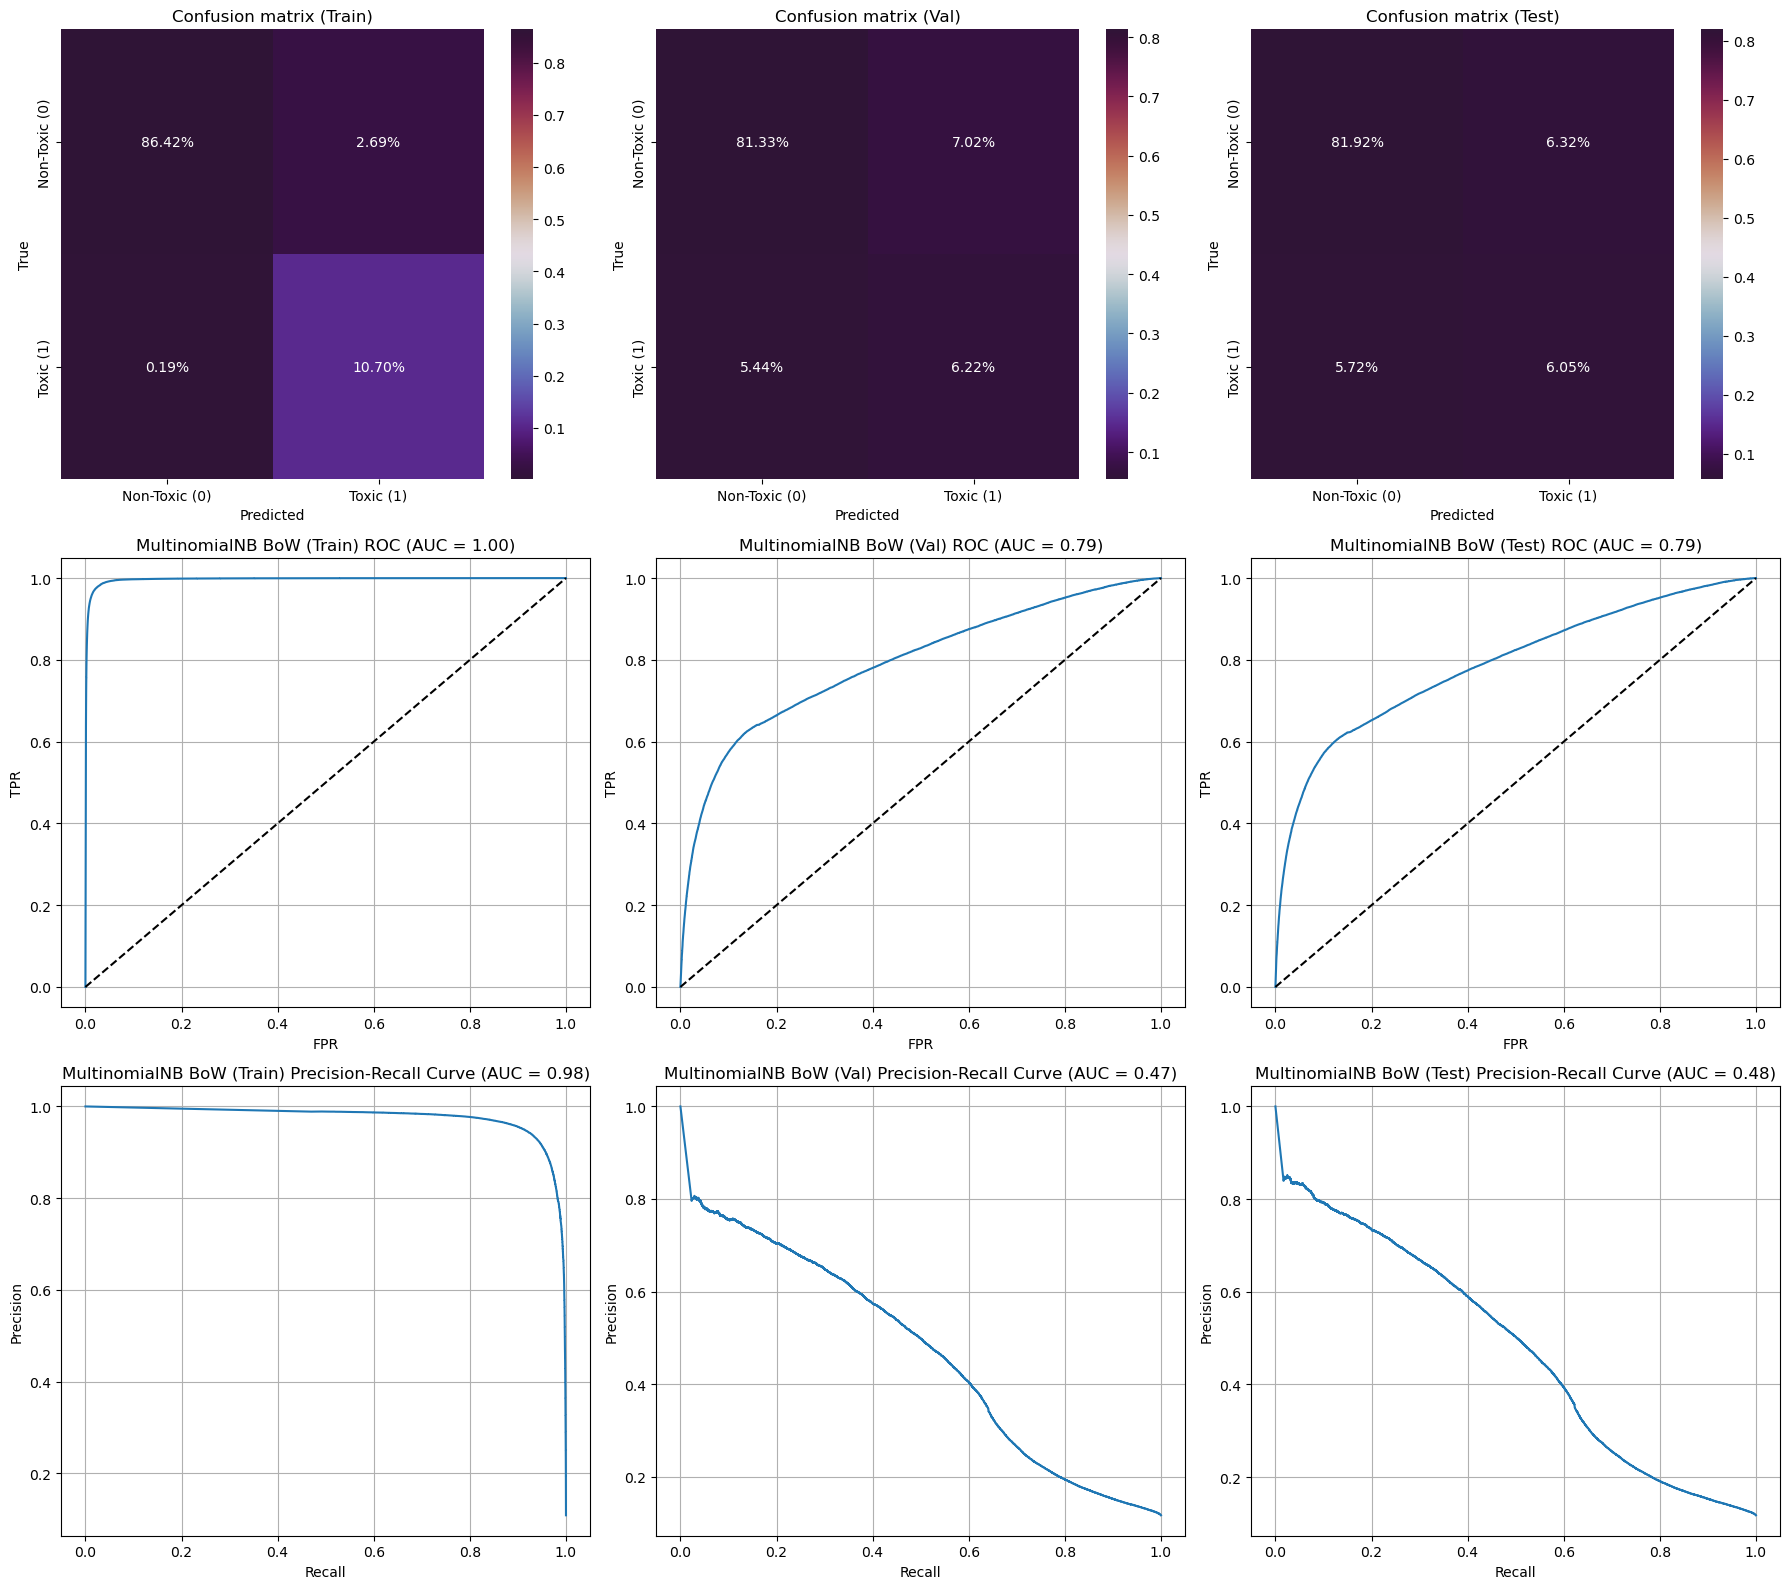

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_bow_ngrams_pred_train,
    y_pred_val=y_nb_bow_ngrams_pred_val,
    y_pred_test=y_nb_bow_ngrams_pred_test,
    y_pred_proba_train=y_nb_bow_ngrams_pred_proba_train,
    y_pred_proba_val=y_nb_bow_ngrams_pred_proba_val,
    y_pred_proba_test=y_nb_bow_ngrams_pred_proba_test,
    title='MultinomialNB BoW'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_Bow_Bigrams"
stage = 'ML models'
metrics = classification_metrics(y_train, y_nb_bow_ngrams_pred_train, y_nb_bow_ngrams_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_Bow_Bigrams"
metrics = classification_metrics(y_val, y_nb_bow_ngrams_pred_val, y_nb_bow_ngrams_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_Bow_Bigrams"
metrics = classification_metrics(y_test, y_nb_bow_ngrams_pred_test, y_nb_bow_ngrams_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
df_metrics.loc[27:38]

Model                    Dataset      Stage  Accuracy  \
27  Logistic_Regression          Dataset_Train_Bow  ML models      0.90   
28  Logistic_Regression            Dataset_Val_Bow  ML models      0.89   
29  Logistic_Regression           Dataset_Test_Bow  ML models      0.89   
30                  SVM          Dataset_Train_Bow  ML models      0.90   
31                  SVM            Dataset_Val_Bow  ML models      0.89   
32                  SVM           Dataset_Test_Bow  ML models      0.89   
33        MultinomialNB          Dataset_Train_Bow  ML models      0.90   
34        MultinomialNB            Dataset_Val_Bow  ML models      0.88   
35        MultinomialNB           Dataset_Test_Bow  ML models      0.89   
36        MultinomialNB  Dataset_Train_Bow_Bigrams  ML models      0.97   
37        MultinomialNB    Dataset_Val_Bow_Bigrams  ML models      0.88   
38        MultinomialNB   Dataset_Test_Bow_Bigrams  ML models      0.88   

    Precision  Recall  F1 Score  ROC AUC  
27       0.53    0.84      0.65     0.95  
28       0.51    0.80      0.62     0.92  
29       0.51    0.80      0.63     0.92  
30       0.54    0.83      0.66     0.95  
31       0.52    0.78      0.62     0.92  
32       0.52    0.78      0.63     0.92  
33       0.53    0.58      0.55     0.86  
34       0.51    0.57      0.54     0.84  
35       0.53    0.55      0.54     0.84  
36       0.80    0.98      0.88     1.00  
37       0.47    0.53      0.50     0.79  
38       0.49    0.51      0.50     0.79

В ходе подбора параметров для моделей `Logistic_Regression` и `Linear_SVC` применялся параметр `class_weight='balanced'`, что привело к тому, что модели начали лучше распозновать класс Toxic из-за чего повысились значения метрики `recall`. Однако метрика `precision ` в этих моделях просела по сравнению с моделями без гиперпараметров. В итоге это привело к улучшению метрики `F-1` на этих моделях. При этом в данном случае модель `Linear_SVC` оказалась лучше. Стоит отметить, что результаты модели `MultinomialNB` обученной на обычном мешке слов остались примерно такими же, но этого нельзя сказать про случай с биграммами. За счет гиперпараметров удалось избежать переобучения данной модели.

## Обучение моделей с TF-IDF

### Логистическая регрессия

In [ ]:
(y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_val,
    y_log_reg_tfidf_pred_test,
    y_log_reg_tfidf_pred_proba_train,
    y_log_reg_tfidf_pred_proba_val,
    y_log_reg_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(C=0.8, class_weight='balanced', max_iter=2000, n_jobs=-1),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

LogisticRegression TF-IDF

Precision		Recall			F1

Train: 0.48		Train: 0.84		Train: 0.61
Val: 0.48		Val: 0.82		Val: 0.60
Test: 0.48		Test: 0.83		Test: 0.61


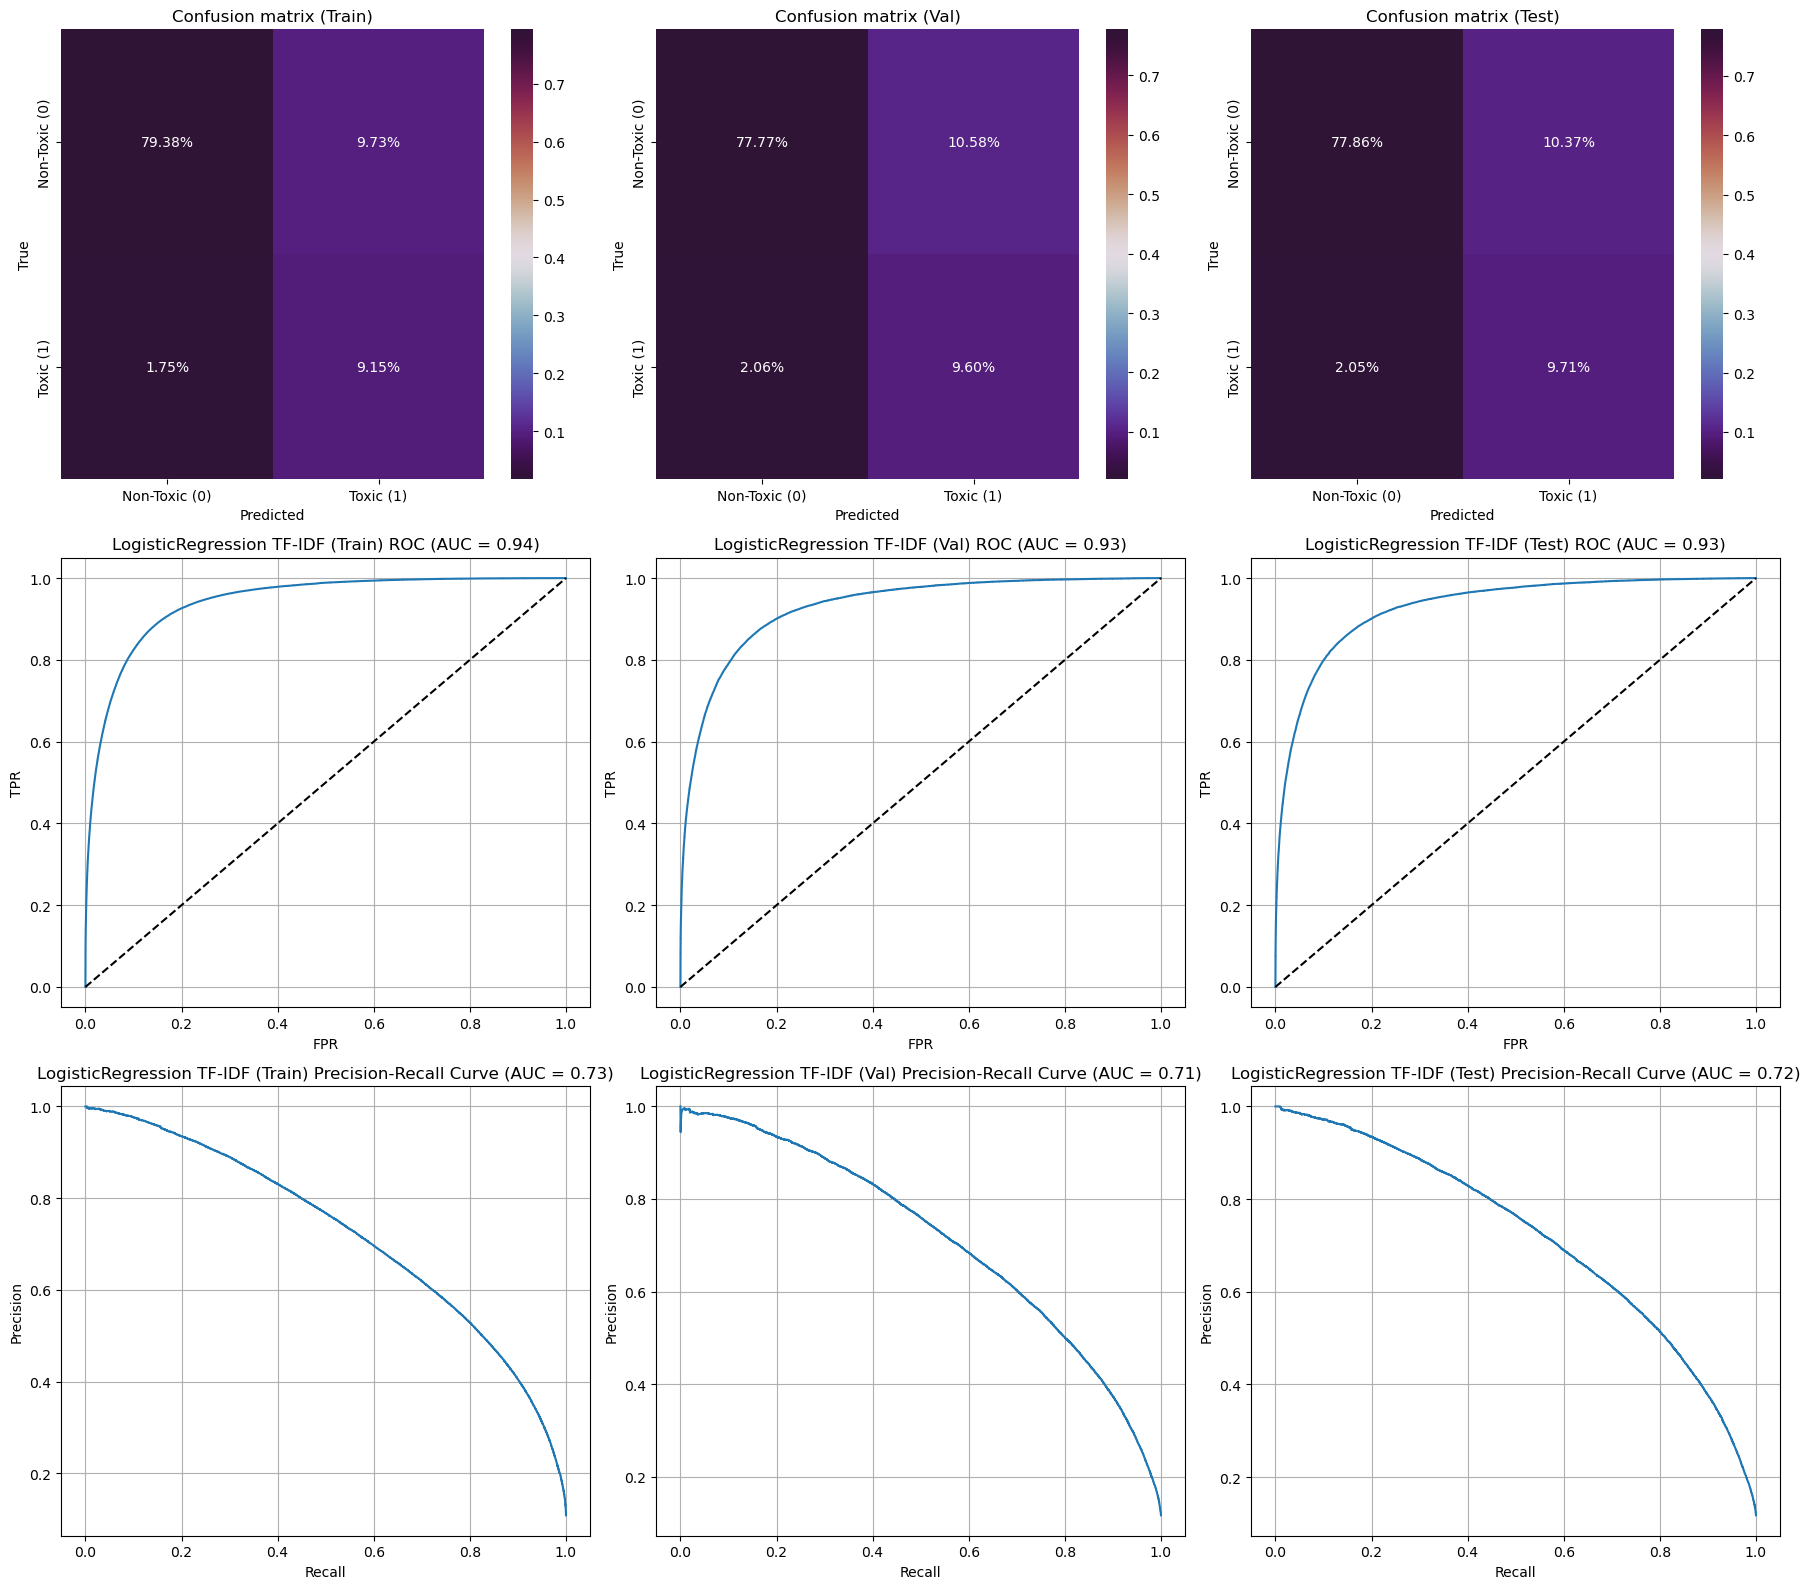

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_tfidf_pred_train,
    y_pred_val=y_log_reg_tfidf_pred_val,
    y_pred_test=y_log_reg_tfidf_pred_test,
    y_pred_proba_train=y_log_reg_tfidf_pred_proba_train,
    y_pred_proba_val=y_log_reg_tfidf_pred_proba_val,
    y_pred_proba_test=y_log_reg_tfidf_pred_proba_test,
    title='LogisticRegression TF-IDF'
)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Train_TF-IDF"
stage = 'ML models'
metrics = classification_metrics(y_train, y_log_reg_tfidf_pred_train, y_log_reg_tfidf_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_TF-IDF"
metrics = classification_metrics(y_val, y_log_reg_tfidf_pred_val, y_log_reg_tfidf_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_TF-IDF"
metrics = classification_metrics(y_test, y_log_reg_tfidf_pred_test, y_log_reg_tfidf_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### SVM

In [ ]:
(y_linear_svc_tfidf_pred_train,
    y_linear_svc_tfidf_pred_val,
    y_linear_svc_tfidf_pred_test,
    y_linear_svc_tfidf_pred_proba_train,
    y_linear_svc_tfidf_pred_proba_val,
    y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(model=LinearSVC(dual=False, penalty = 'l1', C = 0.04, class_weight='balanced', fit_intercept=True, max_iter=2000),
                               X_train=X_train_tfidf,
                               X_val=X_val_tfidf,
                               X_test=X_test_tfidf,
                               y_train=y_train)

SVM TF-IDF

Precision		Recall			F1

Train: 0.49		Train: 0.82		Train: 0.61
Val: 0.49		Val: 0.82		Val: 0.61
Test: 0.49		Test: 0.82		Test: 0.62


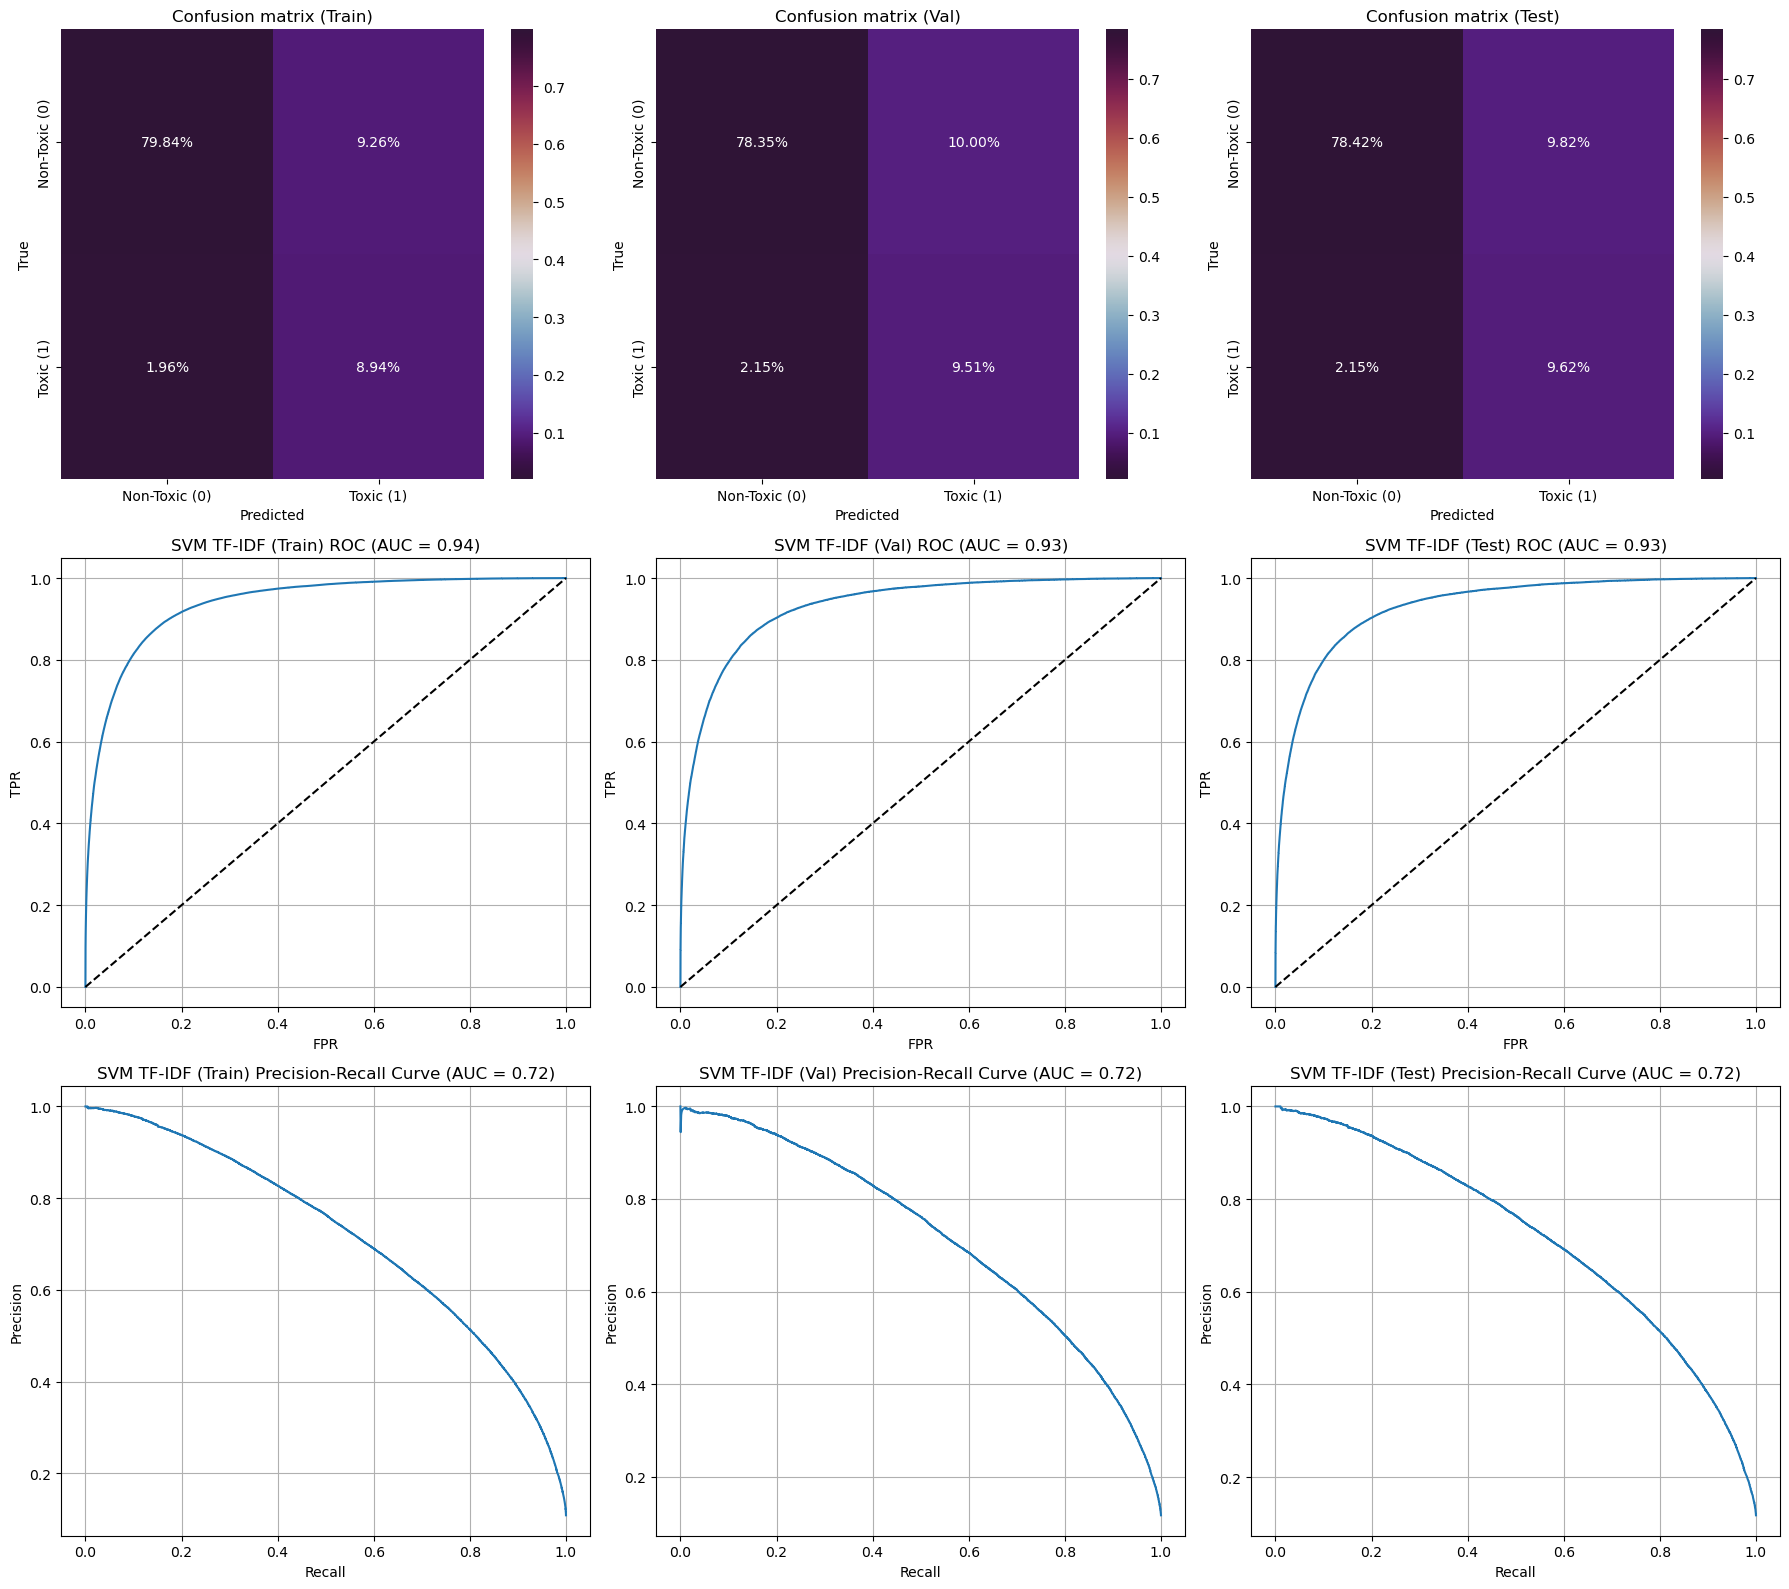

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_tfidf_pred_train,
    y_pred_val=y_linear_svc_tfidf_pred_val,
    y_pred_test=y_linear_svc_tfidf_pred_test,
    y_pred_proba_train=y_linear_svc_tfidf_pred_proba_train,
    y_pred_proba_val=y_linear_svc_tfidf_pred_proba_val,
    y_pred_proba_test=y_linear_svc_tfidf_pred_proba_test,
    title='SVM TF-IDF'
)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Train_TF-IDF"
stage = 'ML models'
metrics = classification_metrics(y_train, y_linear_svc_tfidf_pred_train, y_linear_svc_tfidf_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_TF-IDF"
metrics = classification_metrics(y_val, y_linear_svc_tfidf_pred_val, y_linear_svc_tfidf_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_TF-IDF"
metrics = classification_metrics(y_test, y_linear_svc_tfidf_pred_test, y_linear_svc_tfidf_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### Наивный Байес

#### Слова

In [ ]:
(
    y_nb_tfidf_pred_train,
    y_nb_tfidf_pred_val,
    y_nb_tfidf_pred_test,
    y_nb_tfidf_pred_proba_train,
    y_nb_tfidf_pred_proba_val,
    y_nb_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=5, class_prior=class_priors),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

MultinomialNB TF-IDF

Precision		Recall			F1

Train: 0.11		Train: 1.00		Train: 0.20
Val: 0.12		Val: 1.00		Val: 0.21
Test: 0.12		Test: 1.00		Test: 0.21


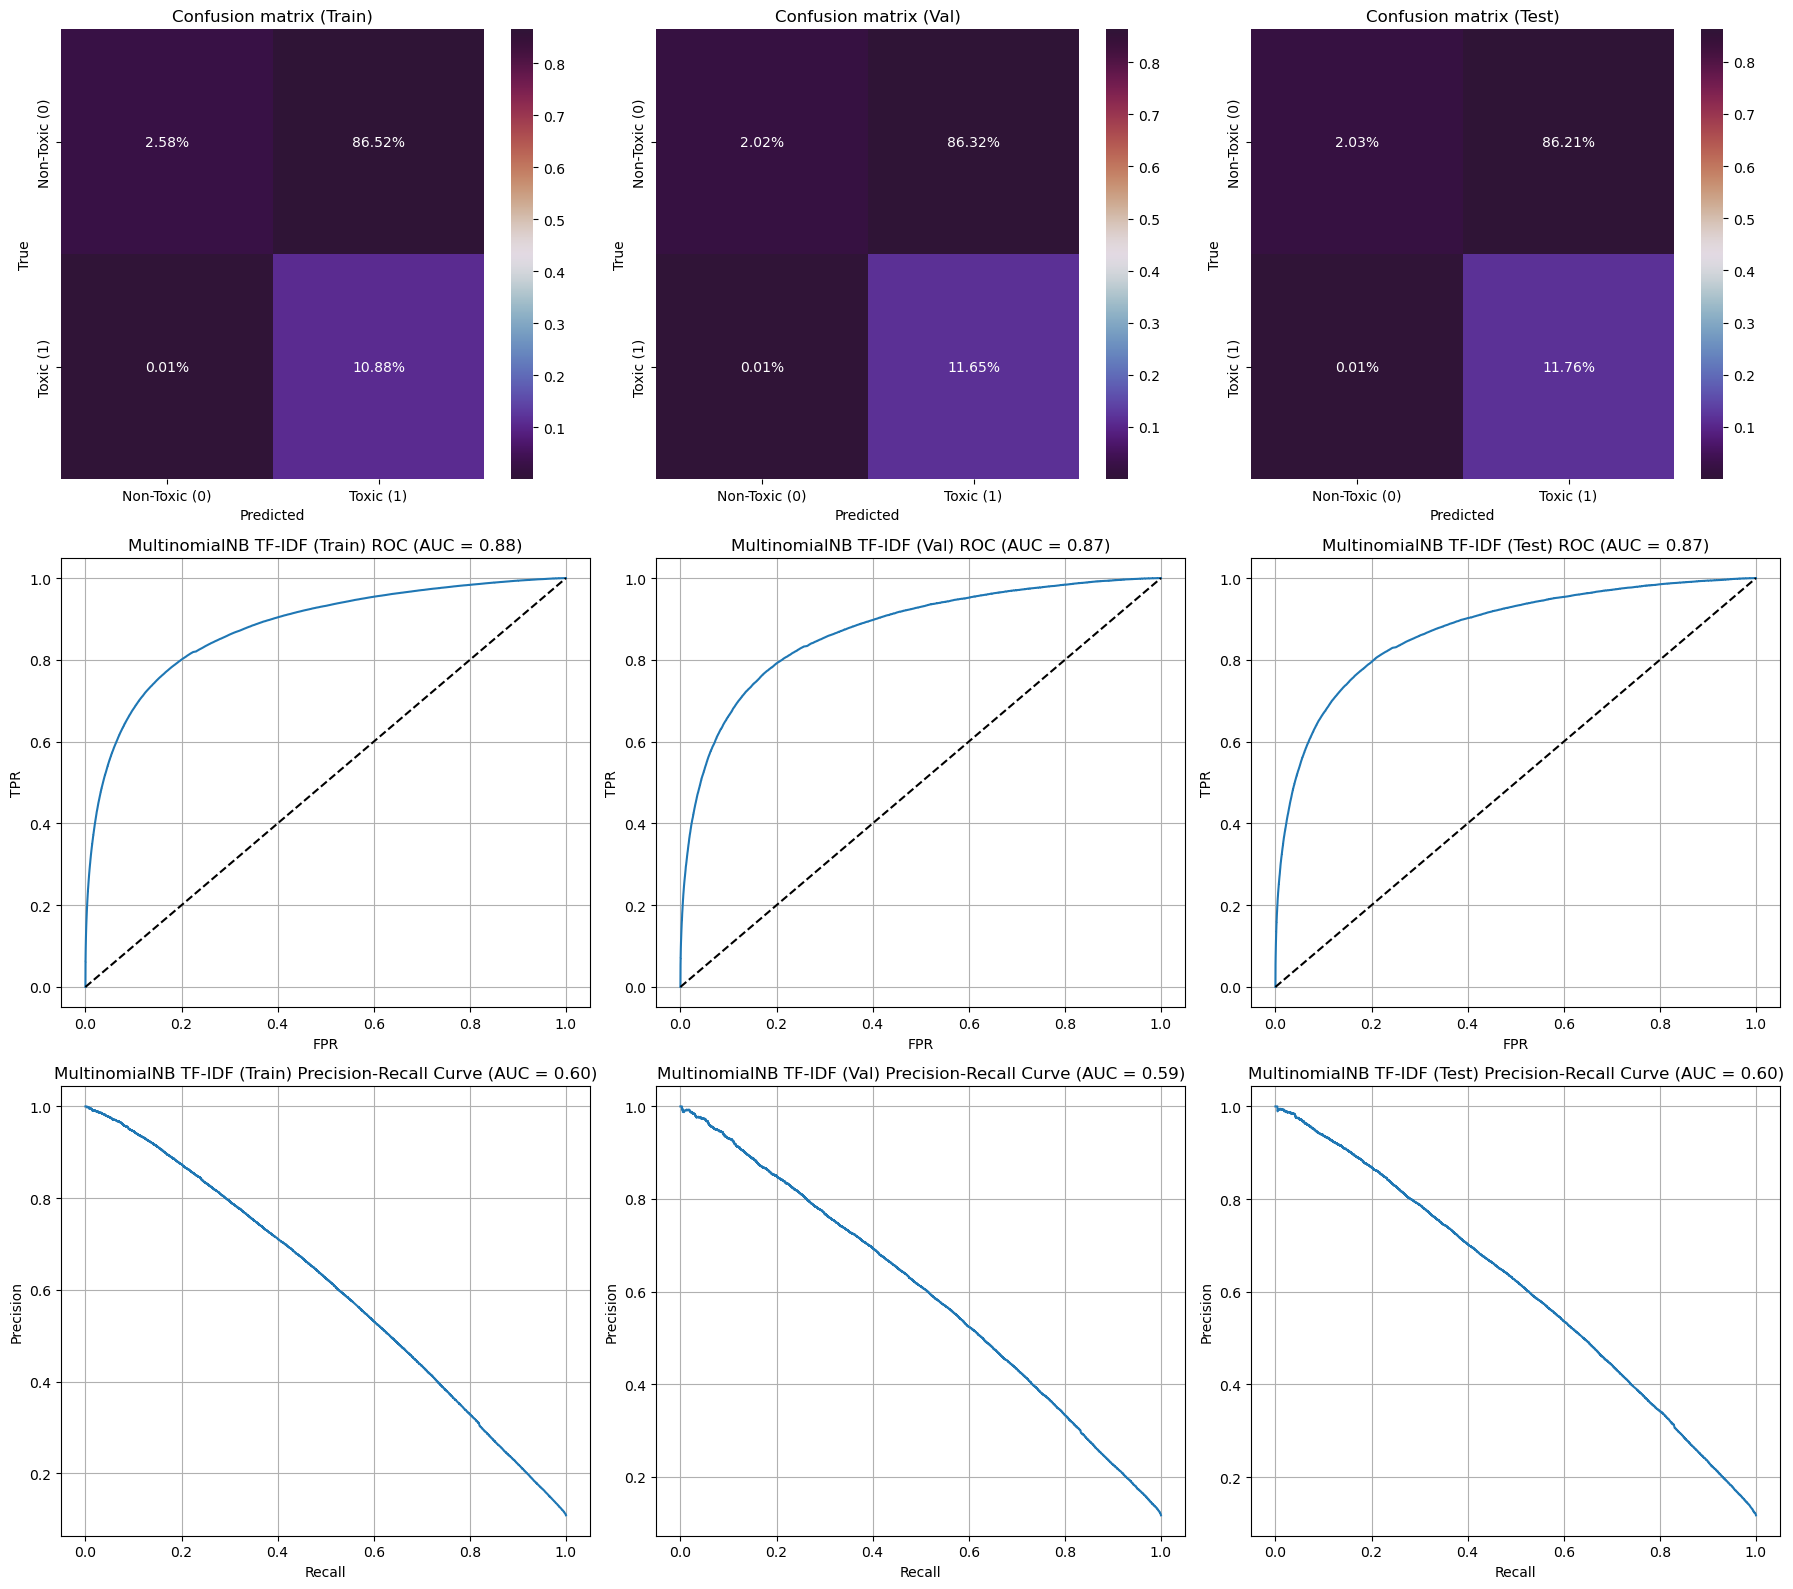

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_pred_train,
    y_pred_val=y_nb_tfidf_pred_val,
    y_pred_test=y_nb_tfidf_pred_test,
    y_pred_proba_train=y_nb_tfidf_pred_proba_train,
    y_pred_proba_val=y_nb_tfidf_pred_proba_val,
    y_pred_proba_test=y_nb_tfidf_pred_proba_test,
    title='MultinomialNB TF-IDF'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_TF-IDF"
stage = 'ML models'
metrics = classification_metrics(y_train, y_nb_tfidf_ngrams_pred_train, y_nb_tfidf_ngrams_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_TF-IDF"
metrics = classification_metrics(y_val, y_nb_tfidf_ngrams_pred_val, y_nb_tfidf_ngrams_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_TF-IDF"
metrics = classification_metrics(y_test, y_nb_tfidf_ngrams_pred_test, y_nb_tfidf_ngrams_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

#### Биграммы

In [ ]:
(
    y_nb_tfidf_ngrams_pred_train,
    y_nb_tfidf_ngrams_pred_val,
    y_nb_tfidf_ngrams_pred_test,
    y_nb_tfidf_ngrams_pred_proba_train,
    y_nb_tfidf_ngrams_pred_proba_val,
    y_nb_tfidf_ngrams_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=0.01),
    X_train=X_train_tfidf_ngrams,
    X_val=X_val_tfidf_ngrams,
    X_test=X_test_tfidf_ngrams,
    y_train=y_train,
)

MultinomialNB TF-IDF

Precision		Recall			F1

Train: 0.87		Train: 0.16		Train: 0.27
Val: 0.82		Val: 0.17		Val: 0.28
Test: 0.87		Test: 0.15		Test: 0.25


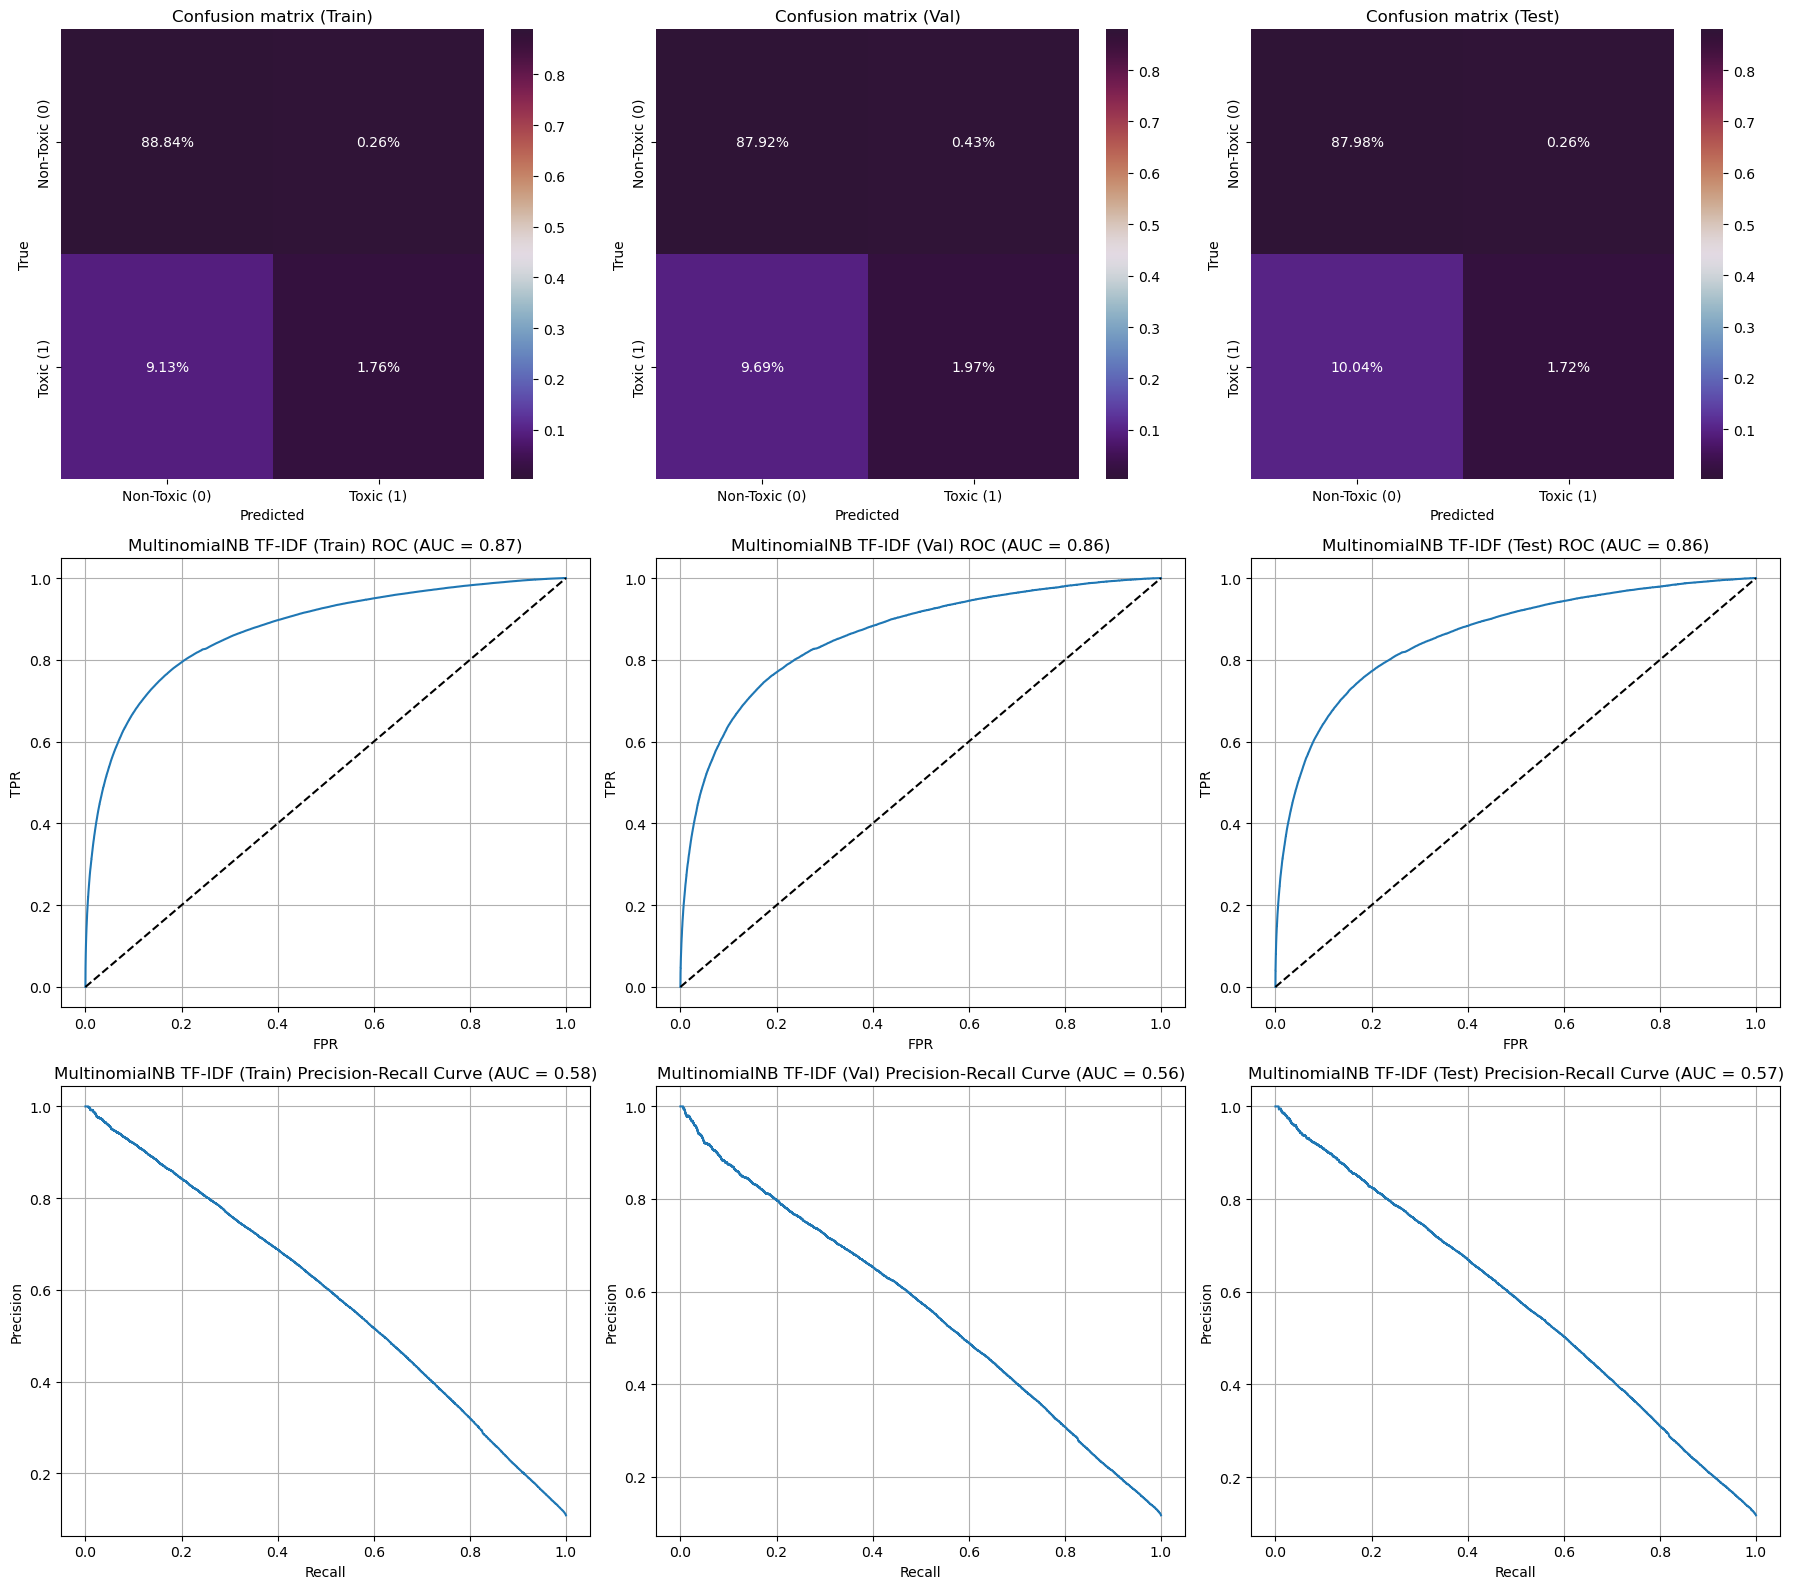

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_ngrams_pred_train,
    y_pred_val=y_nb_tfidf_ngrams_pred_val,
    y_pred_test=y_nb_tfidf_ngrams_pred_test,
    y_pred_proba_train=y_nb_tfidf_ngrams_pred_proba_train,
    y_pred_proba_val=y_nb_tfidf_ngrams_pred_proba_val,
    y_pred_proba_test=y_nb_tfidf_ngrams_pred_proba_test,
    title='MultinomialNB TF-IDF'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_TF-IDF_Bigrams"
stage = 'ML models'
metrics = classification_metrics(y_train, y_nb_tfidf_ngrams_pred_train, y_nb_tfidf_ngrams_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_TF-IDF_Bigrams"
metrics = classification_metrics(y_val, y_nb_tfidf_ngrams_pred_val, y_nb_tfidf_ngrams_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_TF-IDF_Bigrams"
metrics = classification_metrics(y_test, y_nb_tfidf_ngrams_pred_test, y_nb_tfidf_ngrams_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
df_metrics.loc[39:50]

Model                       Dataset      Stage  Accuracy  \
39  Logistic_Regression          Dataset_Train_TF-IDF  ML models      0.89   
40  Logistic_Regression            Dataset_Val_TF-IDF  ML models      0.87   
41  Logistic_Regression           Dataset_Test_TF-IDF  ML models      0.88   
42                  SVM          Dataset_Train_TF-IDF  ML models      0.89   
43                  SVM            Dataset_Val_TF-IDF  ML models      0.88   
44                  SVM           Dataset_Test_TF-IDF  ML models      0.88   
45        MultinomialNB          Dataset_Train_TF-IDF  ML models      0.91   
46        MultinomialNB            Dataset_Val_TF-IDF  ML models      0.90   
47        MultinomialNB           Dataset_Test_TF-IDF  ML models      0.90   
48        MultinomialNB  Dataset_Train_TF-IDF_Bigrams  ML models      0.91   
49        MultinomialNB    Dataset_Val_TF-IDF_Bigrams  ML models      0.90   
50        MultinomialNB   Dataset_Test_TF-IDF_Bigrams  ML models      0.90   

    Precision  Recall  F1 Score  ROC AUC  
39       0.48    0.84      0.61     0.94  
40       0.48    0.82      0.60     0.93  
41       0.48    0.83      0.61     0.93  
42       0.49    0.82      0.61     0.94  
43       0.49    0.82      0.61     0.93  
44       0.49    0.82      0.62     0.93  
45       0.88    0.15      0.26     0.87  
46       0.83    0.16      0.26     0.86  
47       0.88    0.14      0.24     0.86  
48       0.87    0.16      0.27     0.87  
49       0.82    0.17      0.28     0.86  
50       0.87    0.15      0.25     0.86

Ситуация с обучением на TF-IDF в целом схожа с BoW. Однако метрики для двух лучших моделей с гиперпараметрами чуть хуже, чем для случая обучения на BoW. При этом не удается избежать переобучения моделей `MultinomialNB` в обоих случаях.

# Обучение моделей с применением Optuna

## Обучение моделей с мешком слов

### Логистическая регрессия

In [ ]:
def logreg_objective(trial, X_train, X_val, y_train, y_val):

    # Оптимизируем гиперпараметры логистической регрессии
    C = trial.suggest_float("C", 1e-5, 10.0, log=True)  # Регуляризация
    max_iter = trial.suggest_int('max_iter', 500, 5000)

    lr = LogisticRegression(C=C, max_iter = max_iter, class_weight='balanced', n_jobs=10)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    return f1_score(y_val, y_pred)

In [5]:
def get_hyperparams(X_train, X_val, y_train, y_val, objective_func, n_trials=50):
    study = optuna.create_study(direction='maximize')
    study.optimize(partial(
        objective_func,
        X_train=X_train, X_val=X_val,
        y_train=y_train, y_val=y_val
    ), n_trials=n_trials)

    return study.best_params

In [6]:
best_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, logreg_objective, n_trials=40)
(
    y_log_reg_bow_pred_train,
    y_log_reg_bow_pred_val,
    y_log_reg_bow_pred_test,
    y_log_reg_bow_pred_proba_train,
    y_log_reg_bow_pred_proba_val,
    y_log_reg_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(**best_params, class_weight='balanced', n_jobs=10),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

NameError: name 'X_train_bow' is not defined

LogisticRegression BoW

Precision		Recall			F1

Train: 0.53		Train: 0.85		Train: 0.66
Val: 0.51		Val: 0.80		Val: 0.62
Test: 0.51		Test: 0.80		Test: 0.63


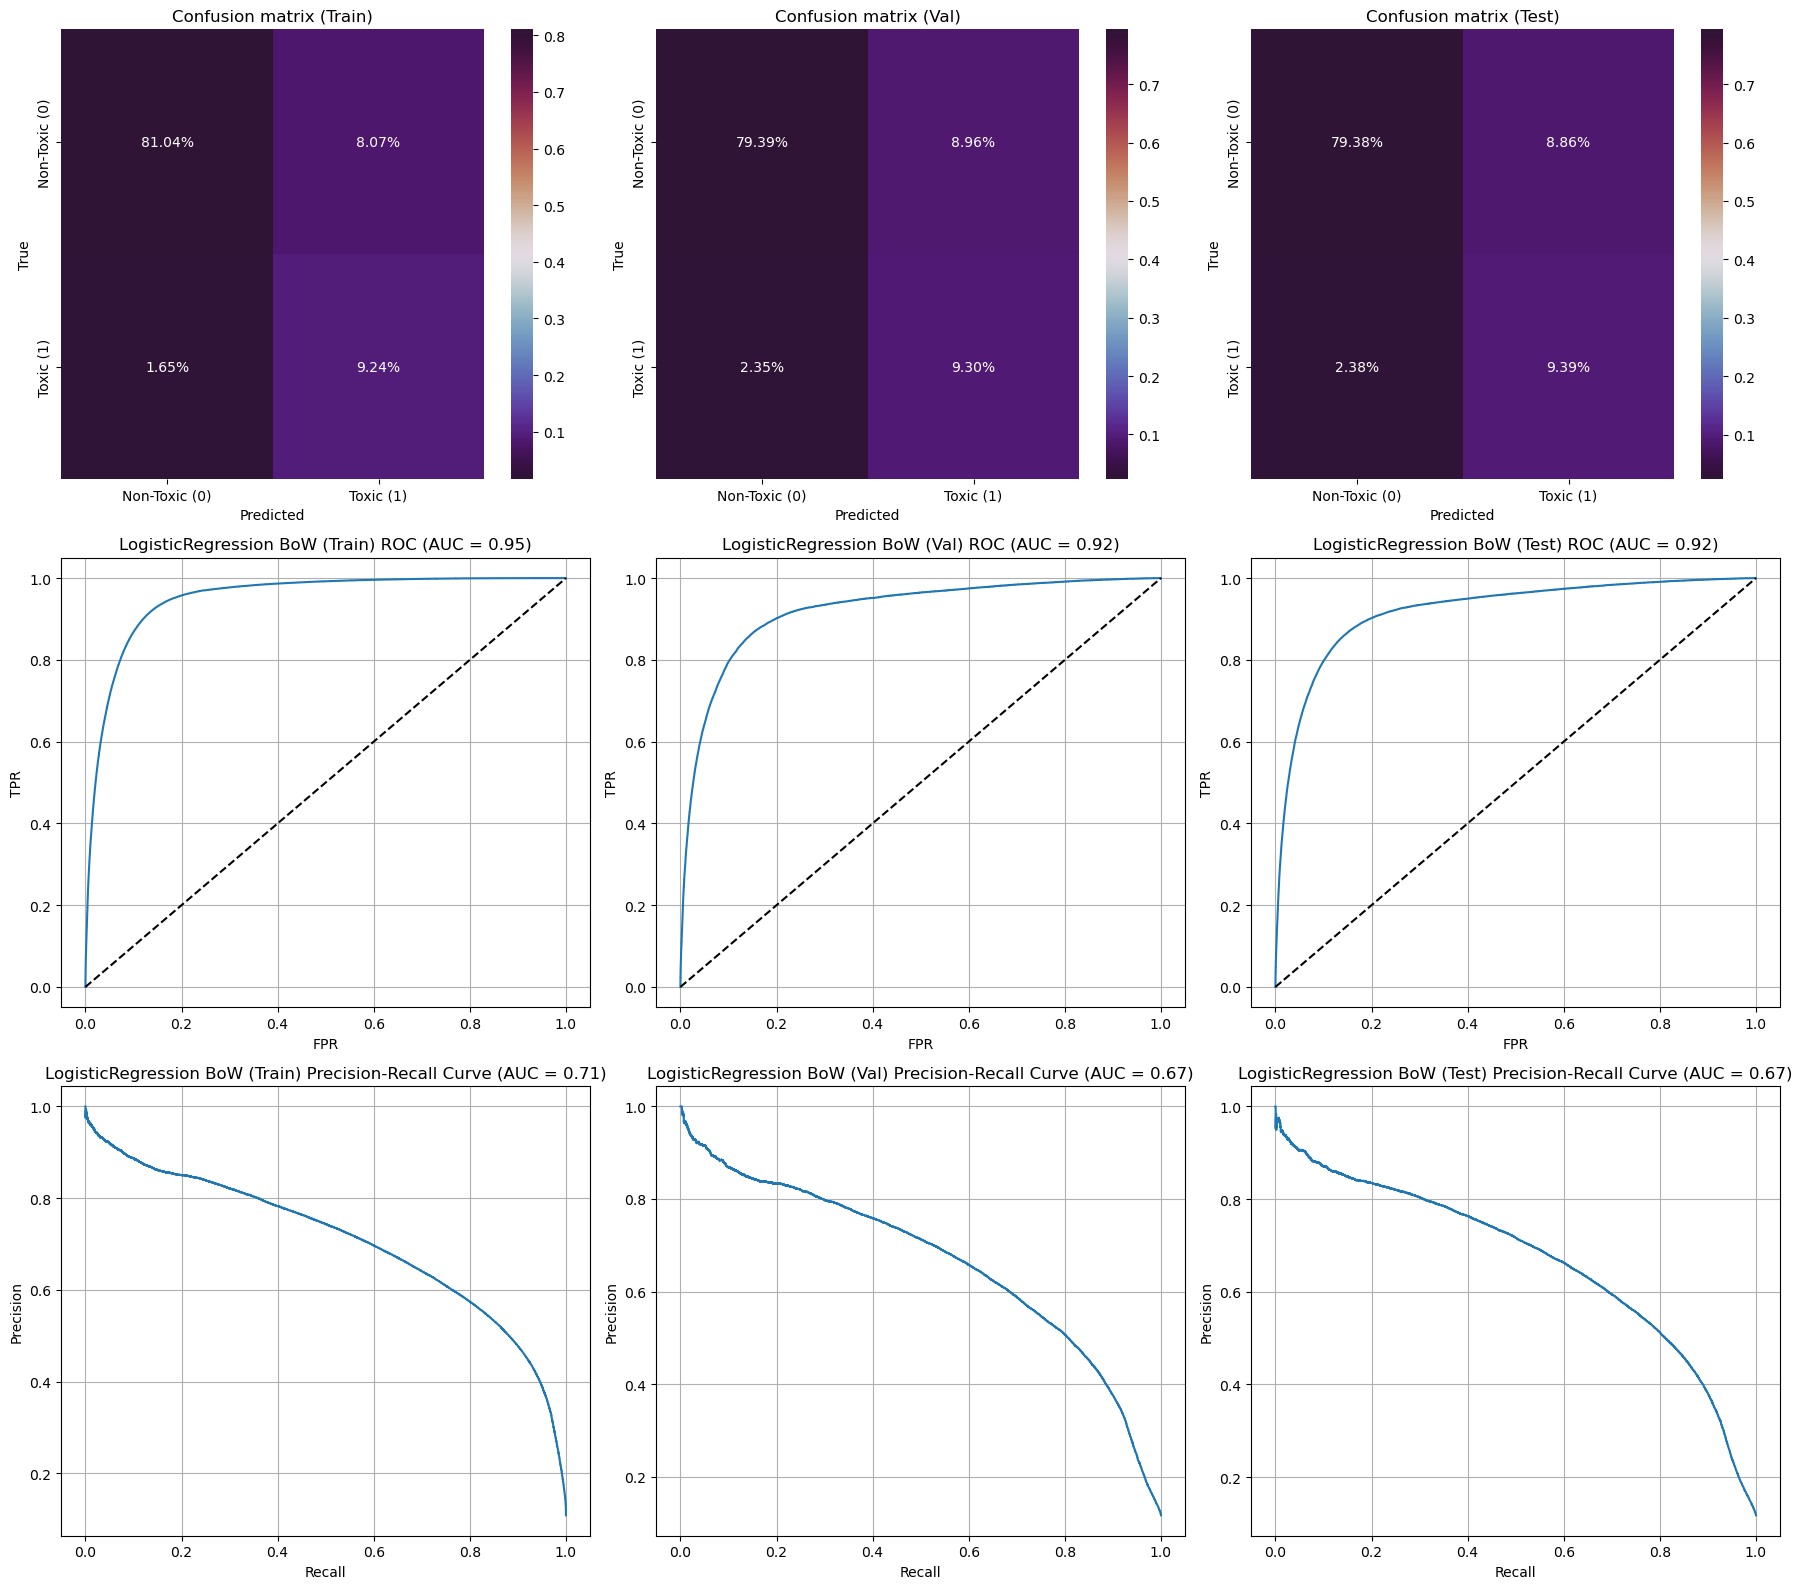

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_bow_pred_train,
    y_pred_val=y_log_reg_bow_pred_val,
    y_pred_test=y_log_reg_bow_pred_test,
    y_pred_proba_train=y_log_reg_bow_pred_proba_train,
    y_pred_proba_val=y_log_reg_bow_pred_proba_val,
    y_pred_proba_test=y_log_reg_bow_pred_proba_test,
    title='LogisticRegression BoW'
)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Train_Bow"
stage = 'ML models optuna'
metrics = classification_metrics(y_train, y_log_reg_bow_pred_train, y_log_reg_bow_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_Bow"
metrics = classification_metrics(y_val, y_log_reg_bow_pred_val, y_log_reg_bow_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_Bow"
metrics = classification_metrics(y_test, y_log_reg_bow_pred_test, y_log_reg_bow_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### SVM

In [ ]:
def svc_objective(trial, X_train, X_val, y_train, y_val):
    C = trial.suggest_float('C', 1e-5, 1, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    svc = LinearSVC(C=C, dual=False, penalty = penalty, class_weight=class_weight)
    svc.fit(X_train, y_train)

    y_pred = svc.predict(X_val)
    return f1_score(y_val, y_pred)

In [ ]:
best_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, svc_objective, n_trials=40)
(y_linear_svc_bow_pred_train,
 y_linear_svc_bow_pred_val,
 y_linear_svc_bow_pred_test,
 y_linear_svc_bow_pred_proba_train,
 y_linear_svc_bow_pred_proba_val,
 y_linear_svc_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LinearSVC(**best_params, dual=False),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2024-12-07 02:29:21,349] A new study created in memory with name: no-name-438b1be9-d9c9-4991-ac90-62f80de9a191
[I 2024-12-07 02:29:23,064] Trial 0 finished with value: 0.0 and parameters: {'C': 1.0493411139388532e-05, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.0.
[I 2024-12-07 02:29:35,396] Trial 1 finished with value: 0.4429963167186104 and parameters: {'C': 0.0006872550316654565, 'penalty': 'l2', 'class_weight': None}. Best is trial 1 with value: 0.4429963167186104.
[I 2024-12-07 02:29:47,474] Trial 2 finished with value: 0.6049050287460883 and parameters: {'C': 0.00026042380578844657, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6049050287460883.
[I 2024-12-07 02:30:09,132] Trial 3 finished with value: 0.6213214410886722 and parameters: {'C': 0.0016760880155214568, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 3 with value: 0.6213214410886722.
[I 2024-12-07 02:30:11,759] Trial 4 finished with value: 0.5319309

SVM BoW

Precision		Recall			F1

Train: 0.55		Train: 0.83		Train: 0.66
Val: 0.52		Val: 0.78		Val: 0.63
Test: 0.53		Test: 0.78		Test: 0.63


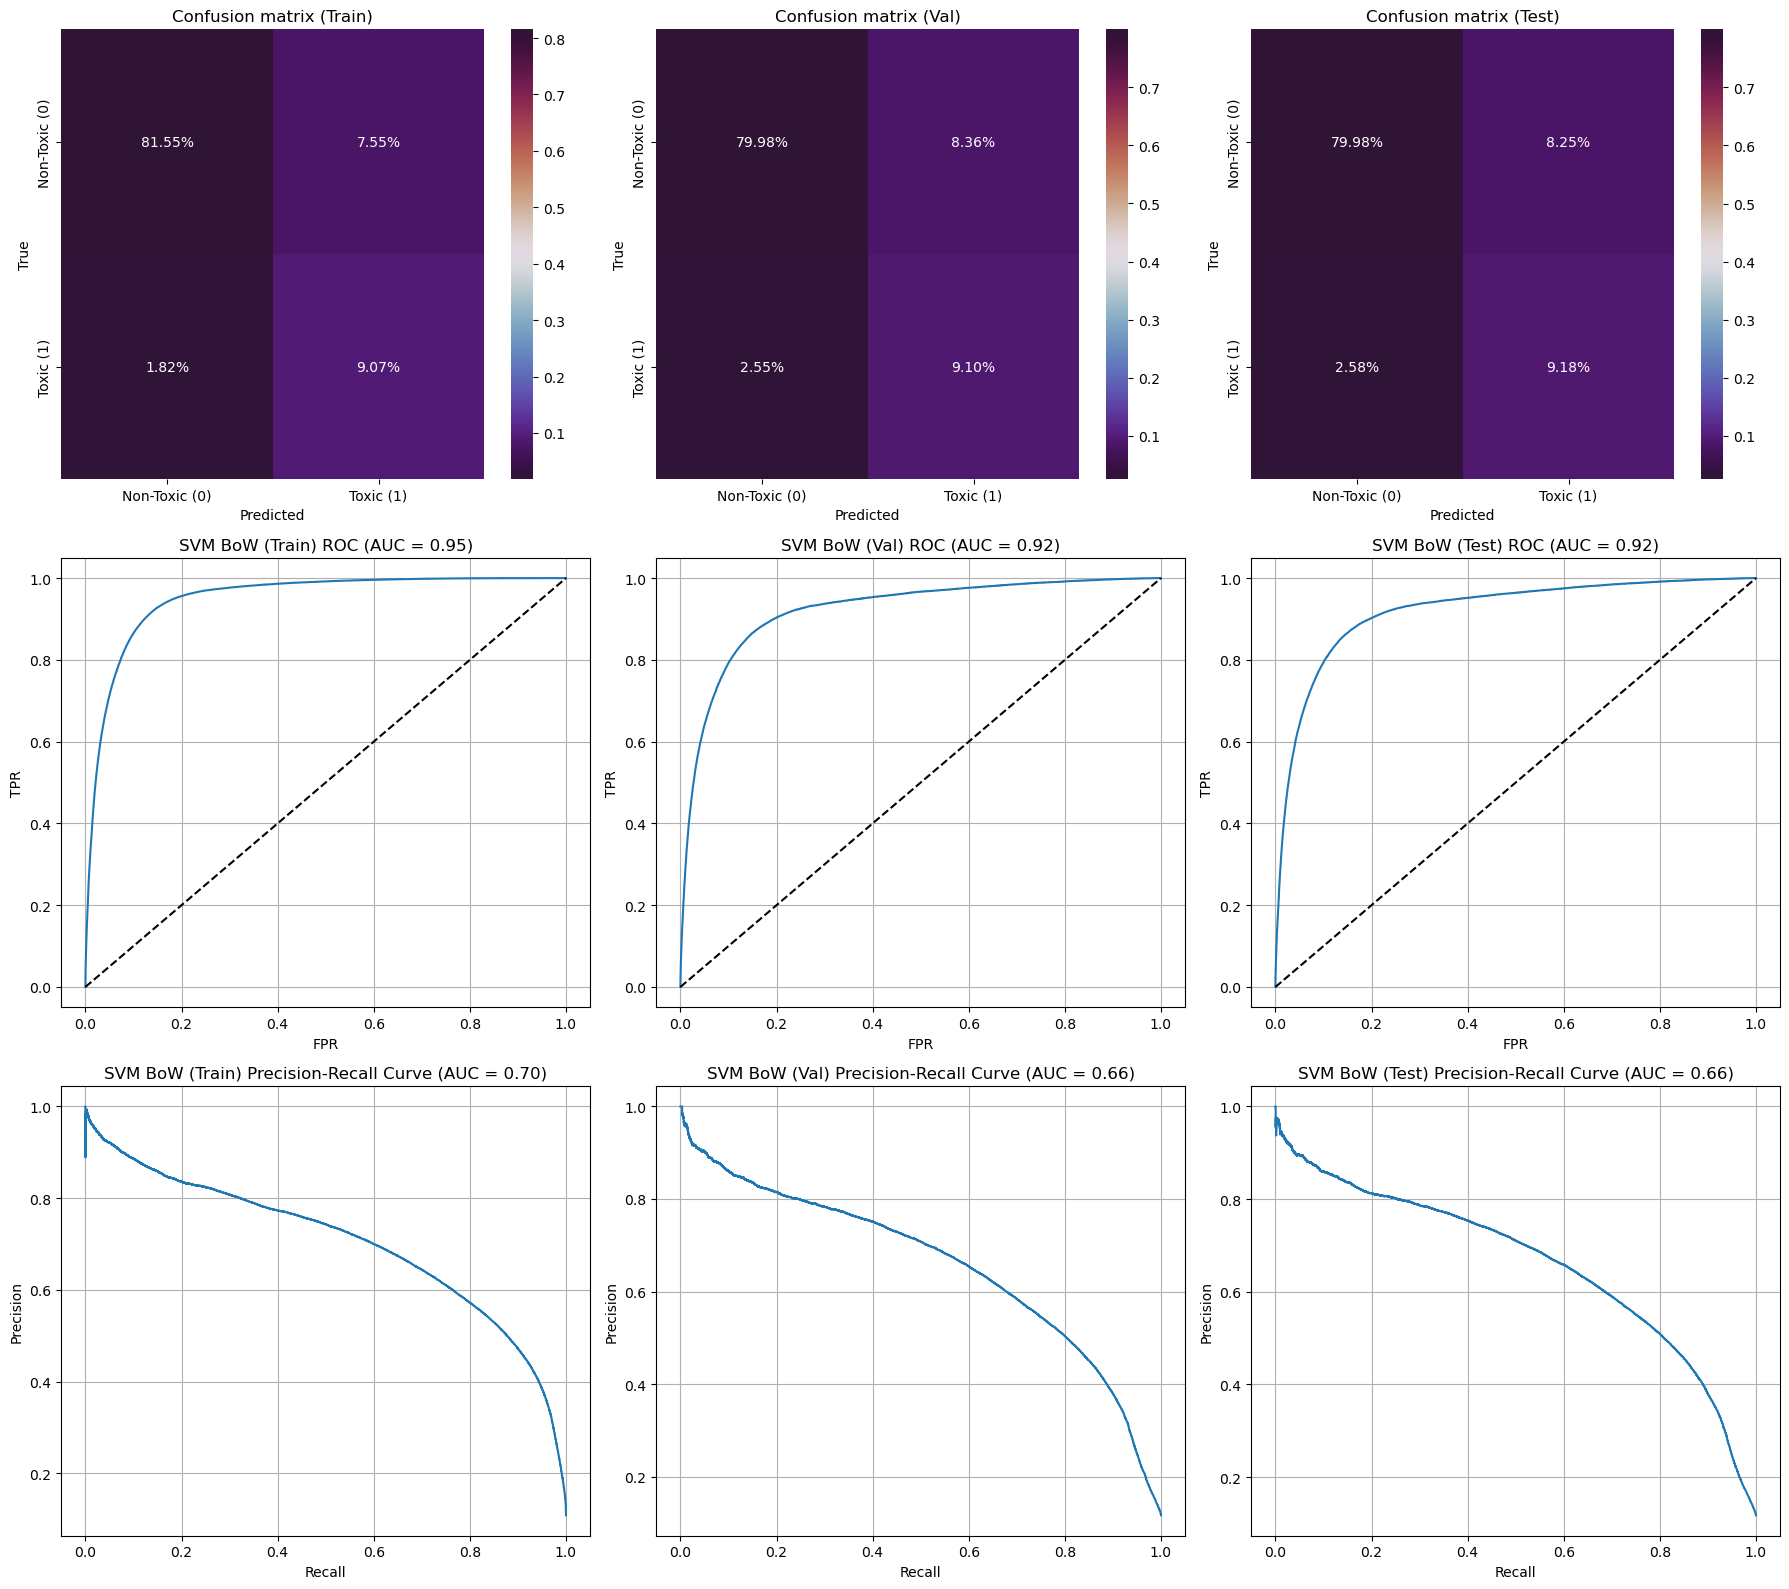

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_bow_pred_train,
    y_pred_val=y_linear_svc_bow_pred_val,
    y_pred_test=y_linear_svc_bow_pred_test,
    y_pred_proba_train=y_linear_svc_bow_pred_proba_train,
    y_pred_proba_val=y_linear_svc_bow_pred_proba_val,
    y_pred_proba_test=y_linear_svc_bow_pred_proba_test,
    title='SVM BoW'
)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Train_Bow"
stage = 'ML models optuna'
metrics = classification_metrics(y_train, y_linear_svc_bow_pred_train, y_linear_svc_bow_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_Bow"
metrics = classification_metrics(y_val, y_linear_svc_bow_pred_val, y_linear_svc_bow_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_Bow"
metrics = classification_metrics(y_test, y_linear_svc_bow_pred_test, y_linear_svc_bow_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### Наивный Байес

#### Слова

In [ ]:
def mnb_objective(trial, X_train, X_val, y_train, y_val):
    alpha = trial.suggest_float('alpha', 0.001, 10.0, log=True)

    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(X_train, y_train)

    y_pred = mnb.predict(X_val)
    return f1_score(y_val, y_pred)

In [ ]:
best_alpha = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, mnb_objective).get('alpha', 1)
(
    y_nb_bow_pred_train,
    y_nb_bow_pred_val,
    y_nb_bow_pred_test,
    y_nb_bow_pred_proba_train,
    y_nb_bow_pred_proba_val,
    y_nb_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=best_alpha, ),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2024-12-07 03:08:15,971] A new study created in memory with name: no-name-26a0e5c0-4f81-4605-8273-3ce8a764ea89
[I 2024-12-07 03:08:16,203] Trial 0 finished with value: 0.5307703552112264 and parameters: {'alpha': 0.27900728176794837}. Best is trial 0 with value: 0.5307703552112264.
[I 2024-12-07 03:08:16,422] Trial 1 finished with value: 0.46644685433303473 and parameters: {'alpha': 4.286815916902026}. Best is trial 0 with value: 0.5307703552112264.
[I 2024-12-07 03:08:16,646] Trial 2 finished with value: 0.5248102180985661 and parameters: {'alpha': 0.053900550608704946}. Best is trial 0 with value: 0.5307703552112264.
[I 2024-12-07 03:08:16,868] Trial 3 finished with value: 0.5179674786800602 and parameters: {'alpha': 0.003664849552371513}. Best is trial 0 with value: 0.5307703552112264.
[I 2024-12-07 03:08:17,099] Trial 4 finished with value: 0.5294523783567717 and parameters: {'alpha': 0.21283597116841388}. Best is trial 0 with value: 0.5307703552112264.
[I 2024-12-07 03:08:17,32

MultinomialNB BoW

Precision		Recall			F1

Train: 0.52		Train: 0.60		Train: 0.56
Val: 0.49		Val: 0.59		Val: 0.54
Test: 0.52		Test: 0.57		Test: 0.54


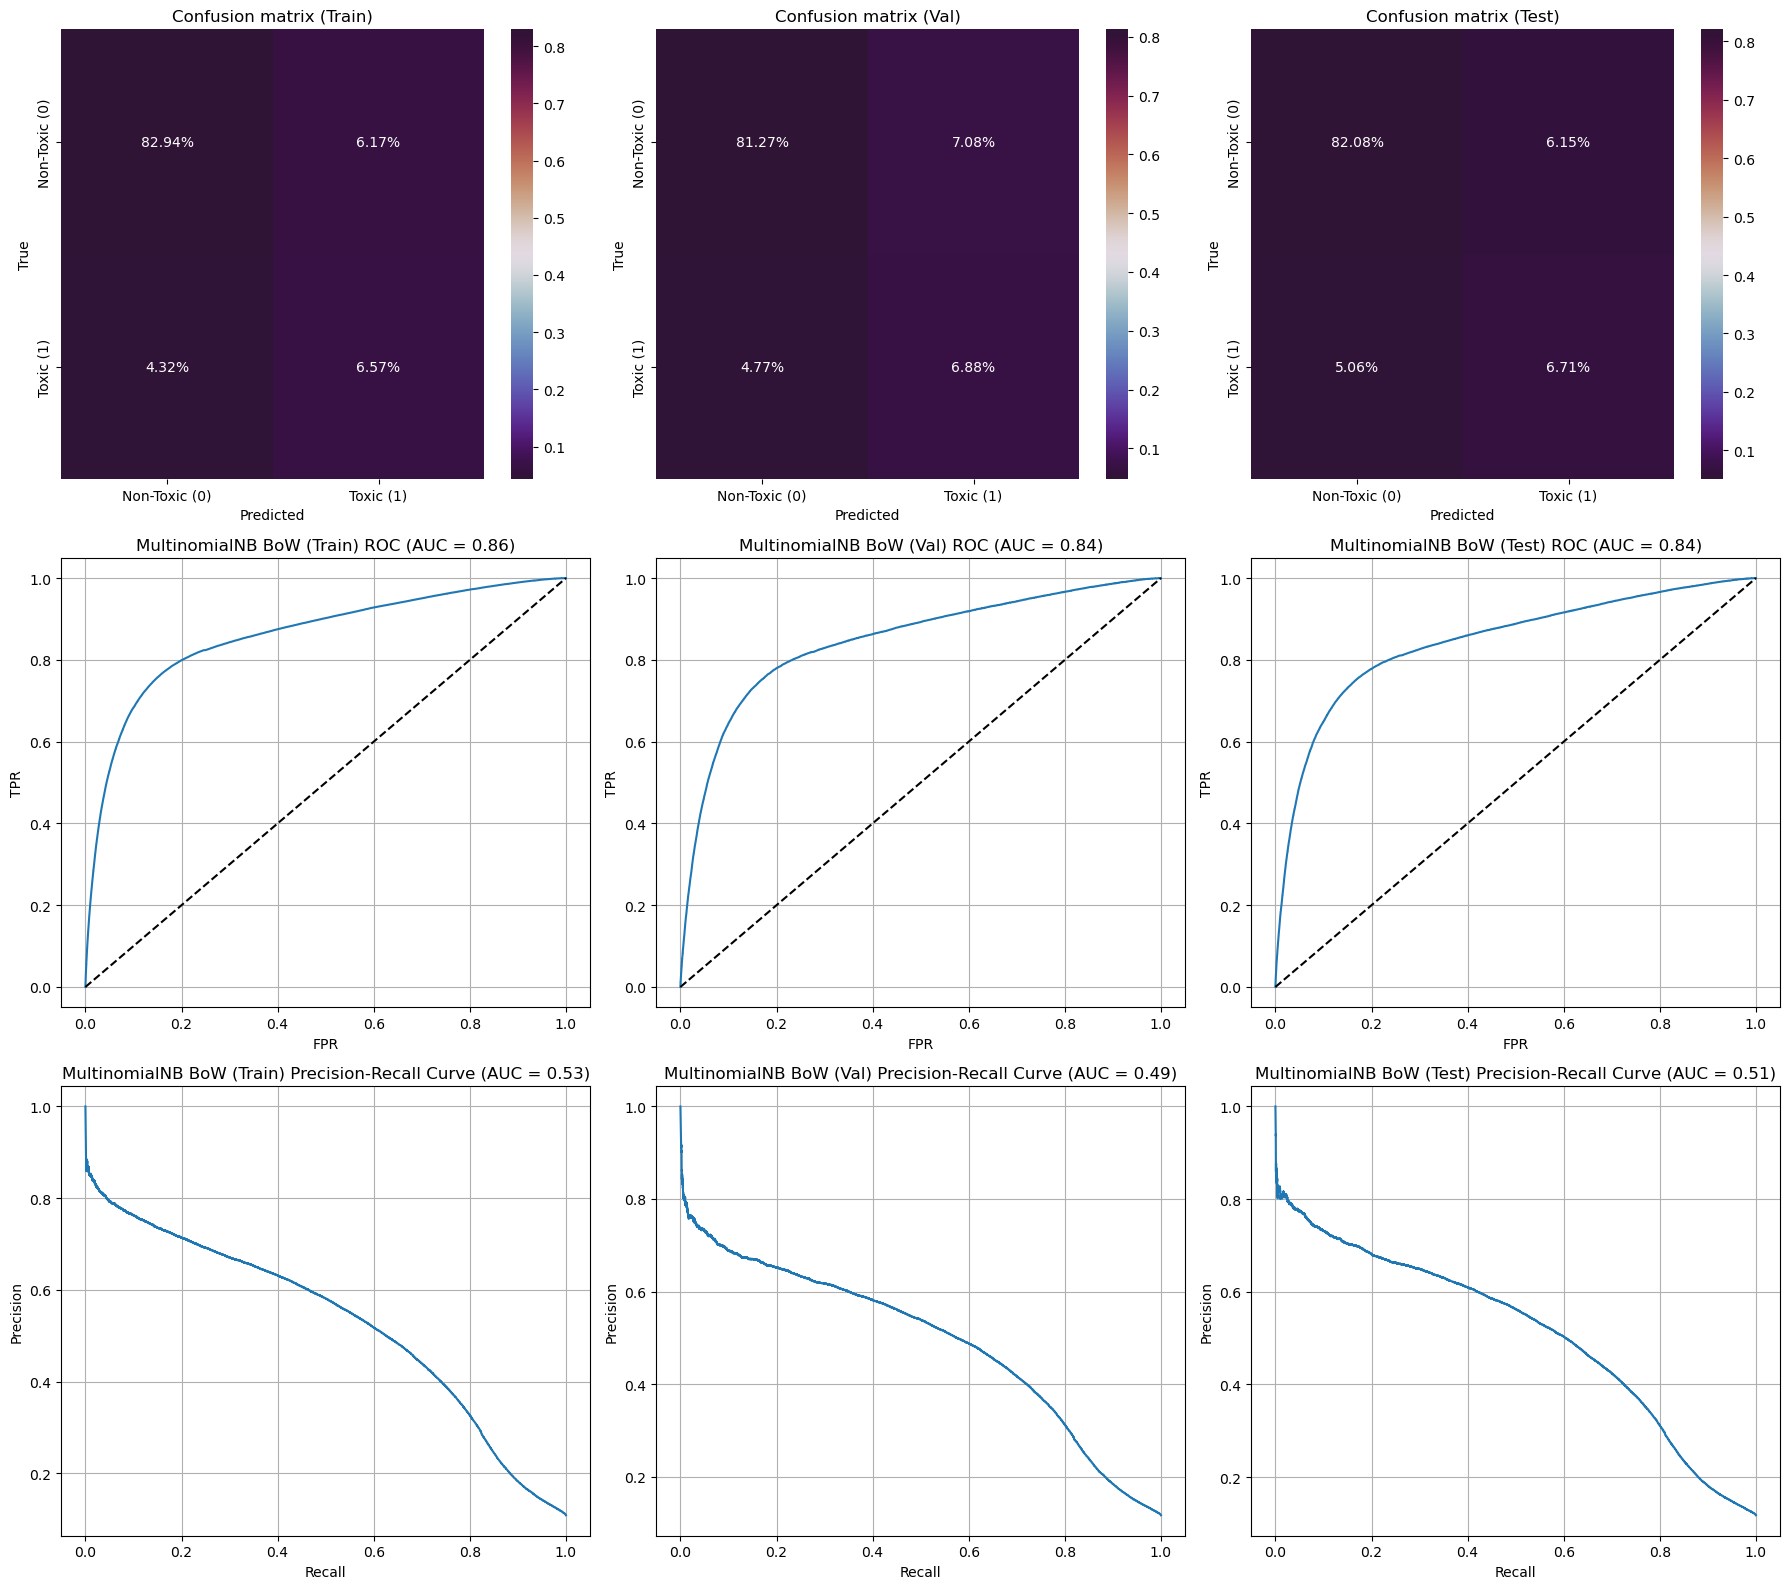

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_bow_pred_train,
    y_pred_val=y_nb_bow_pred_val,
    y_pred_test=y_nb_bow_pred_test,
    y_pred_proba_train=y_nb_bow_pred_proba_train,
    y_pred_proba_val=y_nb_bow_pred_proba_val,
    y_pred_proba_test=y_nb_bow_pred_proba_test,
    title='MultinomialNB BoW'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_Bow"
stage = 'ML models optuna'
metrics = classification_metrics(y_train, y_nb_bow_pred_train, y_nb_bow_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_Bow"
metrics = classification_metrics(y_val, y_nb_bow_pred_val, y_nb_bow_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_Bow"
metrics = classification_metrics(y_test, y_nb_bow_pred_test, y_nb_bow_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

#### Биграммы

In [ ]:
best_alpha = get_hyperparams(X_train_bow_ngrams, X_val_bow_ngrams, y_train, y_val, mnb_objective).get('alpha', 1)
(
    y_nb_bow_ngrams_pred_train,
    y_nb_bow_ngrams_pred_val,
    y_nb_bow_ngrams_pred_test,
    y_nb_bow_ngrams_pred_proba_train,
    y_nb_bow_ngrams_pred_proba_val,
    y_nb_bow_ngrams_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_bow_ngrams,
    X_val=X_val_bow_ngrams,
    X_test=X_test_bow_ngrams,
    y_train=y_train,
)

[I 2024-12-07 03:09:38,587] A new study created in memory with name: no-name-a01dadbd-cd0a-4a13-bc0c-c16580233f3d
[I 2024-12-07 03:09:39,677] Trial 0 finished with value: 0.455394237212419 and parameters: {'alpha': 0.015912072756523017}. Best is trial 0 with value: 0.455394237212419.
[I 2024-12-07 03:09:40,533] Trial 1 finished with value: 0.4767723931639521 and parameters: {'alpha': 0.33947337657832133}. Best is trial 1 with value: 0.4767723931639521.
[I 2024-12-07 03:09:41,348] Trial 2 finished with value: 0.031144731398853497 and parameters: {'alpha': 3.711167397371486}. Best is trial 1 with value: 0.4767723931639521.
[I 2024-12-07 03:09:42,186] Trial 3 finished with value: 0.4479260861018282 and parameters: {'alpha': 0.4143809983145186}. Best is trial 1 with value: 0.4767723931639521.
[I 2024-12-07 03:09:42,988] Trial 4 finished with value: 0.03178447995746315 and parameters: {'alpha': 3.665625807260191}. Best is trial 1 with value: 0.4767723931639521.
[I 2024-12-07 03:09:43,828] T

MultinomialNB BoW

Precision		Recall			F1

Train: 0.79		Train: 0.98		Train: 0.88
Val: 0.50		Val: 0.51		Val: 0.51
Test: 0.53		Test: 0.49		Test: 0.51


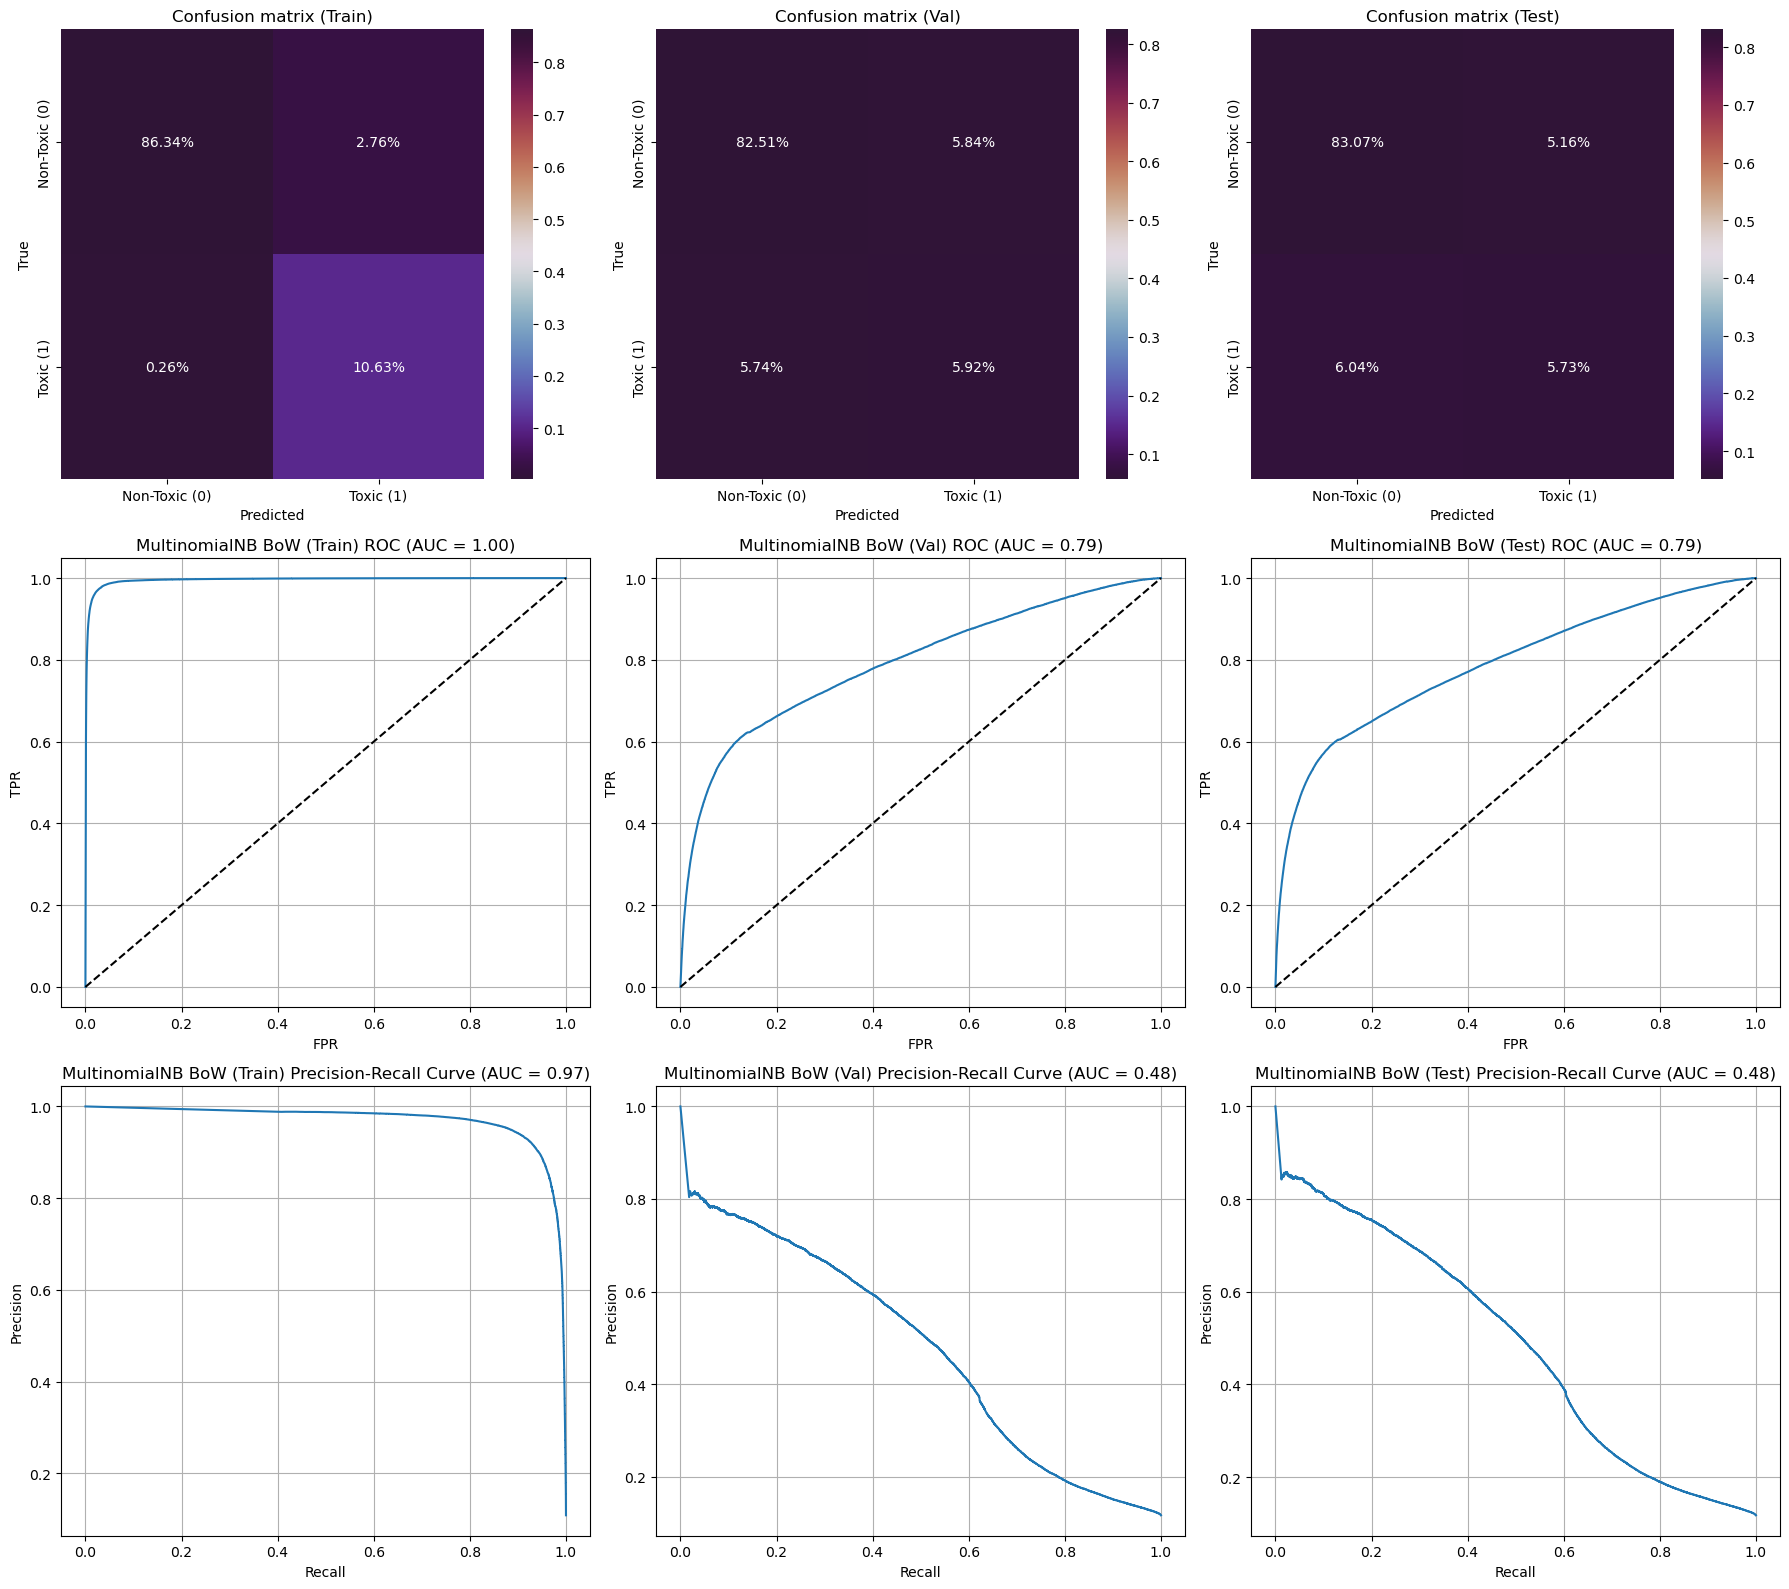

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_bow_ngrams_pred_train,
    y_pred_val=y_nb_bow_ngrams_pred_val,
    y_pred_test=y_nb_bow_ngrams_pred_test,
    y_pred_proba_train=y_nb_bow_ngrams_pred_proba_train,
    y_pred_proba_val=y_nb_bow_ngrams_pred_proba_val,
    y_pred_proba_test=y_nb_bow_ngrams_pred_proba_test,
    title='MultinomialNB BoW'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_Bow_Bigrams"
stage = 'ML models optuna'
metrics = classification_metrics(y_train, y_nb_bow_ngrams_pred_train, y_nb_bow_ngrams_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_Bow_Bigrams"
metrics = classification_metrics(y_val, y_nb_bow_ngrams_pred_val, y_nb_bow_ngrams_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_Bow_Bigrams"
metrics = classification_metrics(y_test, y_nb_bow_ngrams_pred_test, y_nb_bow_ngrams_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
df_metrics.loc[51:62]

Model                    Dataset             Stage  \
51  Logistic_Regression          Dataset_Train_Bow  ML models optuna   
52  Logistic_Regression            Dataset_Val_Bow  ML models optuna   
53  Logistic_Regression           Dataset_Test_Bow  ML models optuna   
54                  SVM          Dataset_Train_Bow  ML models optuna   
55                  SVM            Dataset_Val_Bow  ML models optuna   
56                  SVM           Dataset_Test_Bow  ML models optuna   
57        MultinomialNB          Dataset_Train_Bow  ML models optuna   
58        MultinomialNB            Dataset_Val_Bow  ML models optuna   
59        MultinomialNB           Dataset_Test_Bow  ML models optuna   
60        MultinomialNB  Dataset_Train_Bow_Bigrams  ML models optuna   
61        MultinomialNB    Dataset_Val_Bow_Bigrams  ML models optuna   
62        MultinomialNB   Dataset_Test_Bow_Bigrams  ML models optuna   

    Accuracy  Precision  Recall  F1 Score  ROC AUC  
51      0.90       0.53    0.85      0.66     0.95  
52      0.89       0.51    0.80      0.62     0.92  
53      0.89       0.51    0.80      0.63     0.92  
54      0.91       0.55    0.83      0.66     0.95  
55      0.89       0.52    0.78      0.63     0.92  
56      0.89       0.53    0.78      0.63     0.92  
57      0.90       0.52    0.60      0.56     0.86  
58      0.88       0.49    0.59      0.54     0.84  
59      0.89       0.52    0.57      0.54     0.84  
60      0.97       0.79    0.98      0.88     1.00  
61      0.88       0.50    0.51      0.51     0.79  
62      0.89       0.53    0.49      0.51     0.79

Обучение с применением optuna в целом дает свои результаты. Метрики `Logistic_Regression` и `Linear_SVC` в какой-то мере улучшились, но не сильно. Если говорить об `F-1` метрике, то результаты в среднем примерно улучшились на 0.01 для каждой модели на валидационной и тестовой выборках.

## Обучение моделей с TF-IDF

In [ ]:
best_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, logreg_objective, n_trials=40)

(
    y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_val,
    y_log_reg_tfidf_pred_test,
    y_log_reg_tfidf_pred_proba_train,
    y_log_reg_tfidf_pred_proba_val,
    y_log_reg_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(**best_params, class_weight='balanced', n_jobs=10),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2024-12-07 03:22:33,631] A new study created in memory with name: no-name-f60e87d6-0754-4f40-afeb-4e4ee7a594d4
[I 2024-12-07 03:22:35,291] Trial 0 finished with value: 0.46335273620818146 and parameters: {'C': 0.00019430363317481683, 'max_iter': 4414}. Best is trial 0 with value: 0.46335273620818146.
[I 2024-12-07 03:22:37,410] Trial 1 finished with value: 0.5268657665486763 and parameters: {'C': 0.00376670137793714, 'max_iter': 3061}. Best is trial 1 with value: 0.5268657665486763.
[I 2024-12-07 03:22:39,492] Trial 2 finished with value: 0.5675918617907568 and parameters: {'C': 0.014080419642999826, 'max_iter': 4083}. Best is trial 2 with value: 0.5675918617907568.
[I 2024-12-07 03:22:40,489] Trial 3 finished with value: 0.4804228062850684 and parameters: {'C': 0.0007198889079499109, 'max_iter': 1179}. Best is trial 2 with value: 0.5675918617907568.
[I 2024-12-07 03:22:43,746] Trial 4 finished with value: 0.6010132510477191 and parameters: {'C': 2.4903484387135215, 'max_iter': 4784

LogisticRegression TF-IDF

Precision		Recall			F1

Train: 0.48		Train: 0.83		Train: 0.61
Val: 0.48		Val: 0.82		Val: 0.60
Test: 0.48		Test: 0.82		Test: 0.61


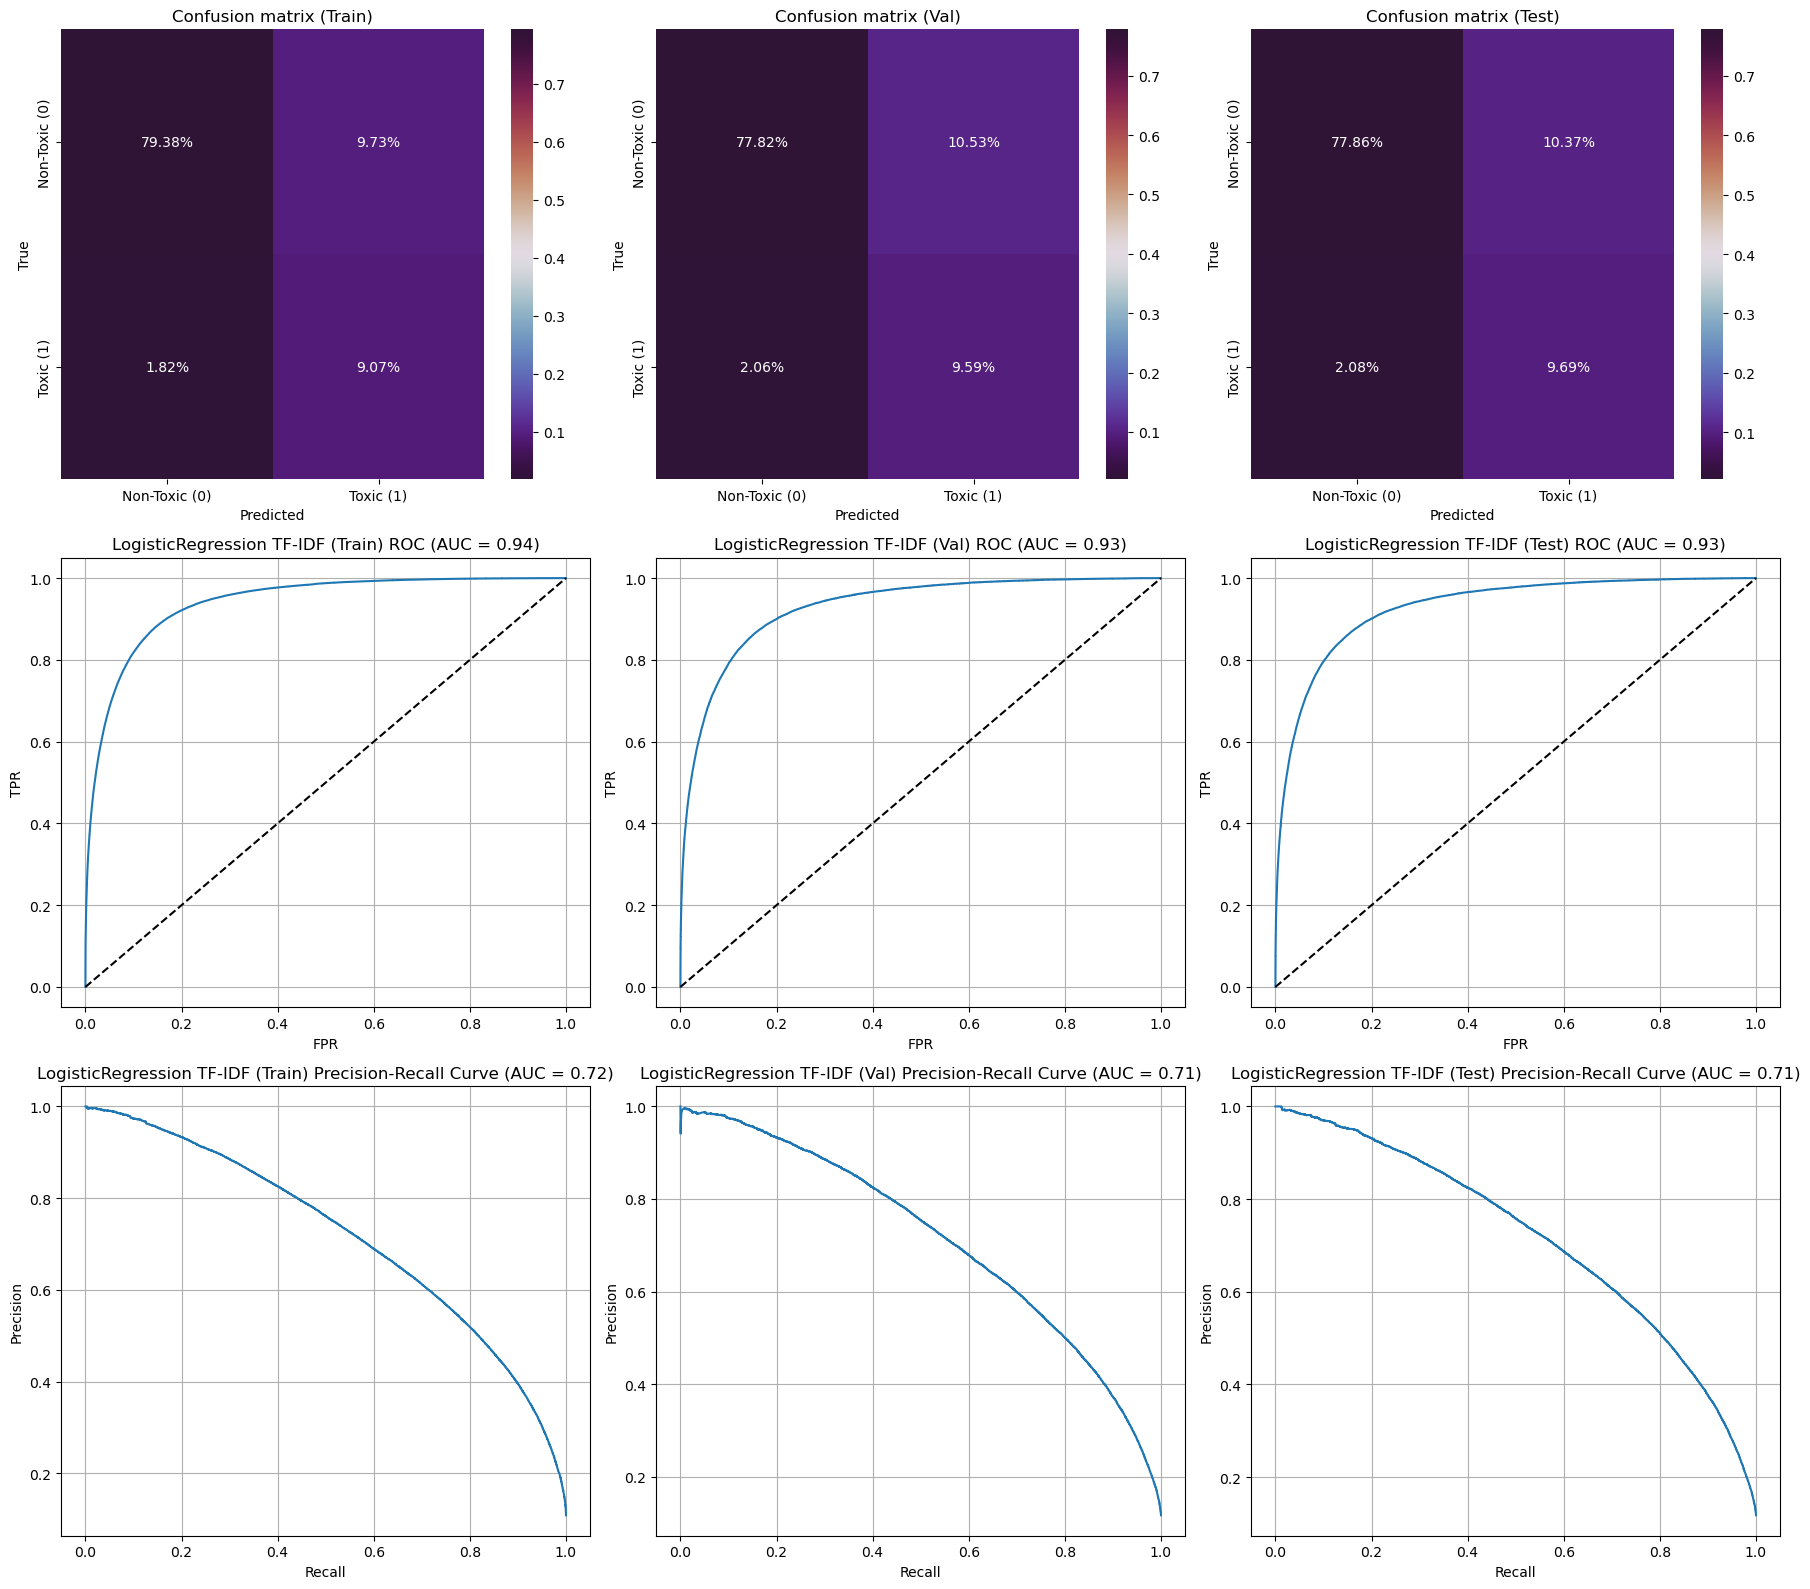

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_tfidf_pred_train,
    y_pred_val=y_log_reg_tfidf_pred_val,
    y_pred_test=y_log_reg_tfidf_pred_test,
    y_pred_proba_train=y_log_reg_tfidf_pred_proba_train,
    y_pred_proba_val=y_log_reg_tfidf_pred_proba_val,
    y_pred_proba_test=y_log_reg_tfidf_pred_proba_test,
    title='LogisticRegression TF-IDF'
)

In [ ]:
model_name = "Logistic_Regression"
dataset_name = "Dataset_Train_TF-IDF"
stage = 'ML models optuna'
metrics = classification_metrics(y_train, y_log_reg_tfidf_pred_train, y_log_reg_tfidf_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_TF-IDF"
metrics = classification_metrics(y_val, y_log_reg_tfidf_pred_val, y_log_reg_tfidf_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_TF-IDF"
metrics = classification_metrics(y_test, y_log_reg_tfidf_pred_test, y_log_reg_tfidf_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### SVM

In [ ]:
best_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, svc_objective, n_trials=40)
(
y_linear_svc_tfidf_pred_train,
    y_linear_svc_tfidf_pred_val,
    y_linear_svc_tfidf_pred_test,
    y_linear_svc_tfidf_pred_proba_train,
    y_linear_svc_tfidf_pred_proba_val,
    y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LinearSVC(**best_params, dual=False),X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train)

[I 2024-12-07 03:27:16,620] A new study created in memory with name: no-name-fa0de495-085e-4469-8304-5a8e77076c69
[I 2024-12-07 03:27:18,787] Trial 0 finished with value: 0.4780481851742619 and parameters: {'C': 7.674025379123246e-05, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4780481851742619.
[I 2024-12-07 03:27:24,708] Trial 1 finished with value: 0.5967023627400986 and parameters: {'C': 0.0046737237205023725, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 1 with value: 0.5967023627400986.
[I 2024-12-07 03:27:41,923] Trial 2 finished with value: 0.6082139871830593 and parameters: {'C': 0.08867533075306566, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6082139871830593.
[I 2024-12-07 03:27:52,032] Trial 3 finished with value: 0.6068026906331494 and parameters: {'C': 0.025753062191340128, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6082139871830593.
[I 2024-12-07 03:27:53,077] T

SVM TF-IDF

Precision		Recall			F1

Train: 0.49		Train: 0.80		Train: 0.61
Val: 0.49		Val: 0.80		Val: 0.61
Test: 0.50		Test: 0.80		Test: 0.61


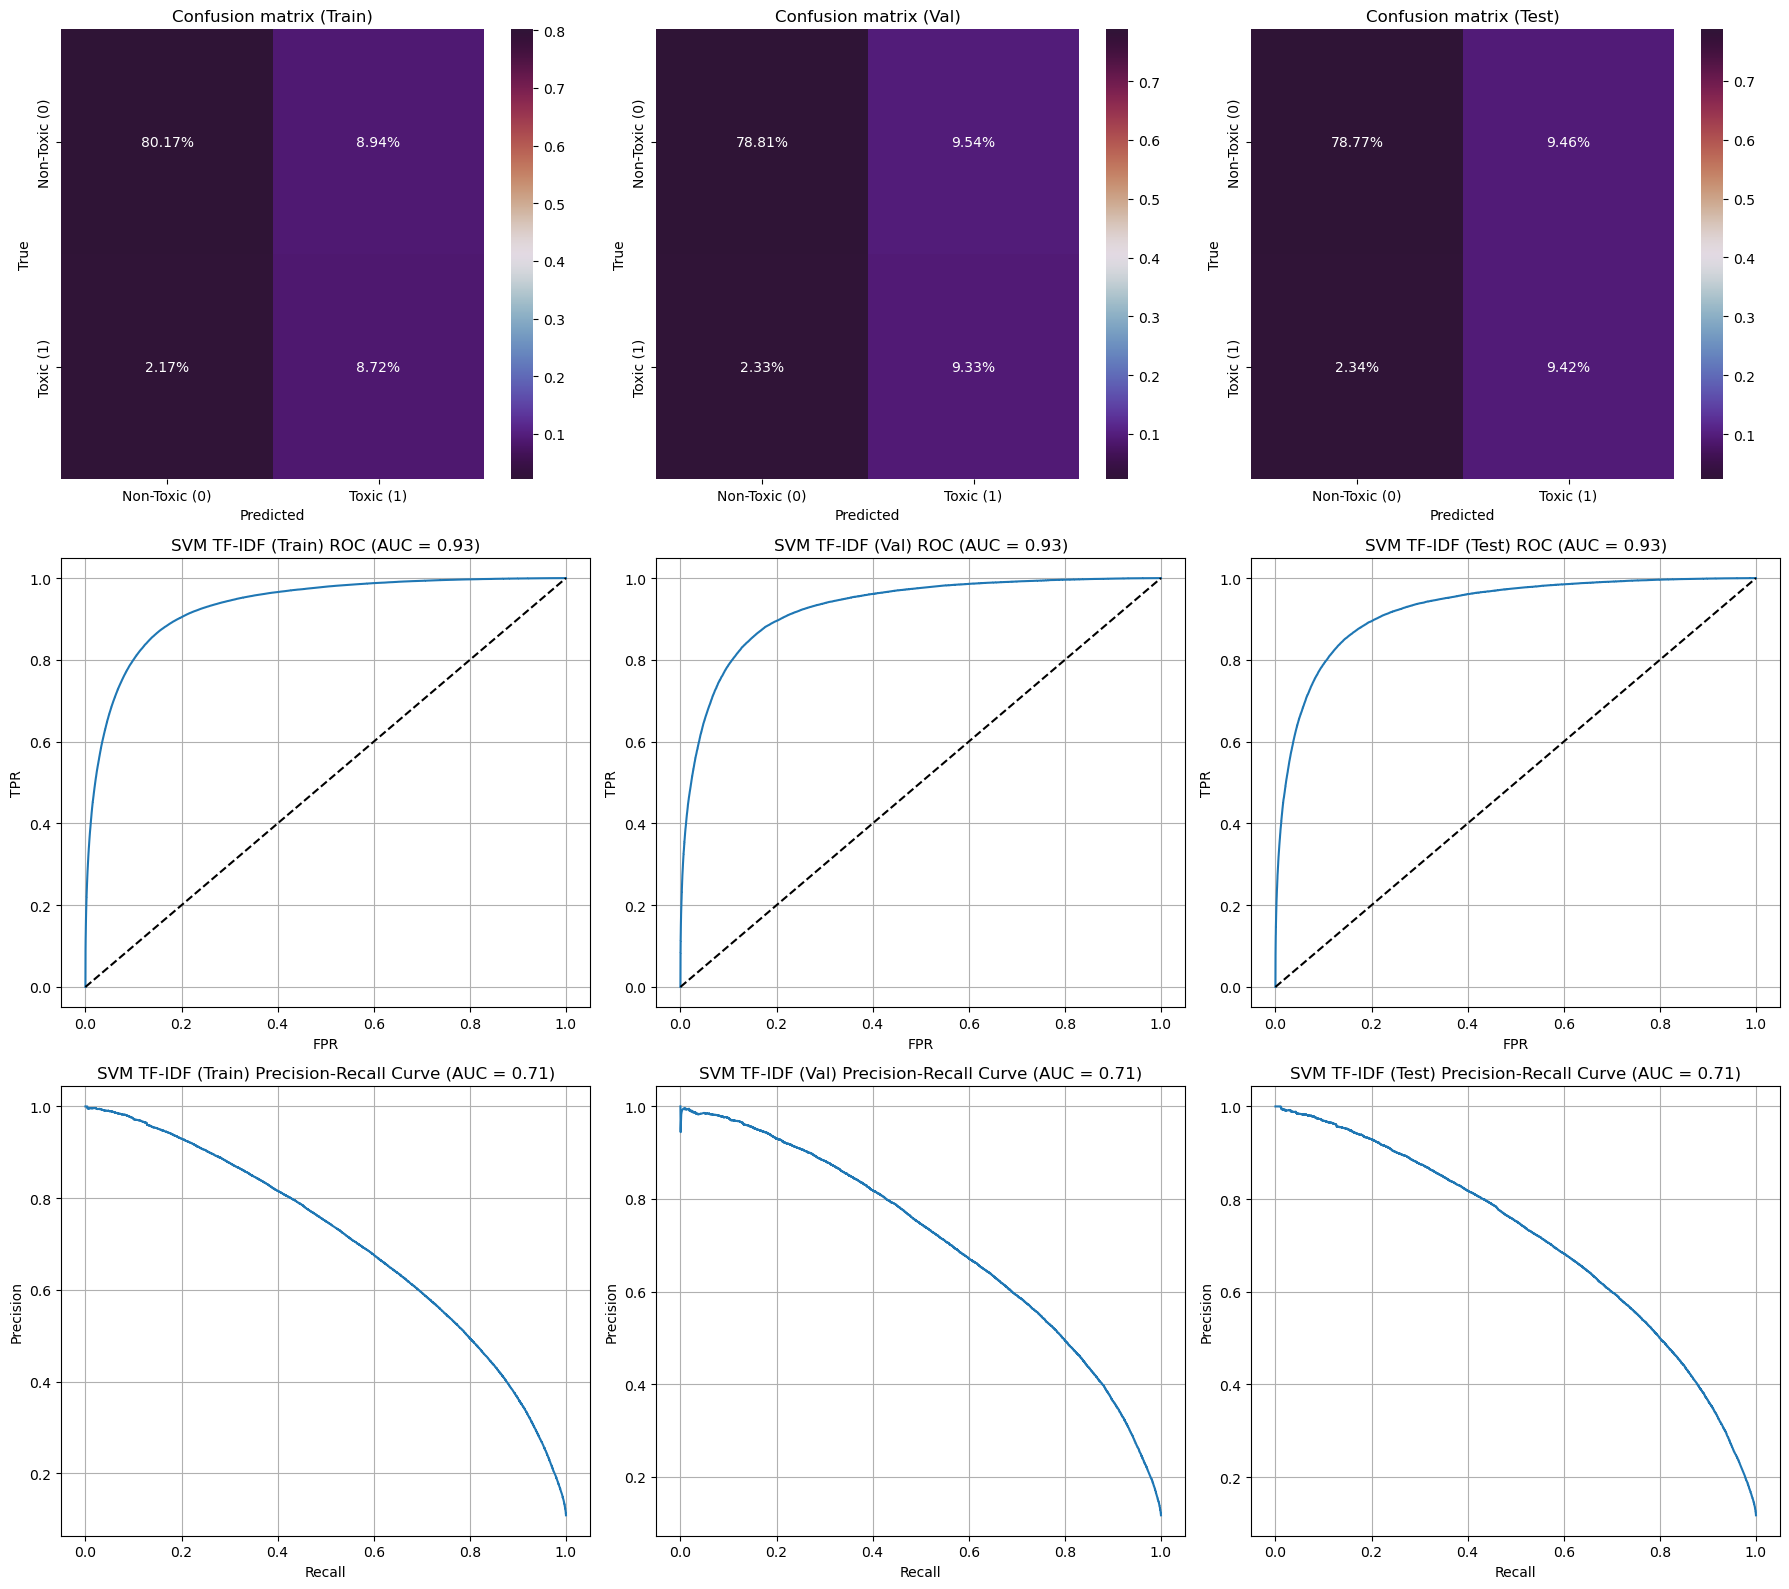

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_tfidf_pred_train,
    y_pred_val=y_linear_svc_tfidf_pred_val,
    y_pred_test=y_linear_svc_tfidf_pred_test,
    y_pred_proba_train=y_linear_svc_tfidf_pred_proba_train,
    y_pred_proba_val=y_linear_svc_tfidf_pred_proba_val,
    y_pred_proba_test=y_linear_svc_tfidf_pred_proba_test,
    title='SVM TF-IDF'
)

In [ ]:
model_name = "SVM"
dataset_name = "Dataset_Train_TF-IDF"
stage = 'ML models optuna'
metrics = classification_metrics(y_train, y_linear_svc_tfidf_pred_train, y_linear_svc_tfidf_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_TF-IDF"
metrics = classification_metrics(y_val, y_linear_svc_tfidf_pred_val, y_linear_svc_tfidf_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_TF-IDF"
metrics = classification_metrics(y_test, y_linear_svc_tfidf_pred_test, y_linear_svc_tfidf_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

### Наивный Байес

#### Слова

In [ ]:
best_alpha = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, mnb_objective).get('alpha', 1)
(
    y_nb_tfidf_pred_train,
    y_nb_tfidf_pred_val,
    y_nb_tfidf_pred_test,
    y_nb_tfidf_pred_proba_train,
    y_nb_tfidf_pred_proba_val,
    y_nb_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2024-12-07 03:35:23,692] A new study created in memory with name: no-name-19f9b7c5-1b56-418f-90b1-cccd3060223a
[I 2024-12-07 03:35:23,906] Trial 0 finished with value: 0.23515265579255543 and parameters: {'alpha': 0.030275915281762315}. Best is trial 0 with value: 0.23515265579255543.
[I 2024-12-07 03:35:24,111] Trial 1 finished with value: 0.23515265579255543 and parameters: {'alpha': 0.002227632795030271}. Best is trial 0 with value: 0.23515265579255543.
[I 2024-12-07 03:35:24,315] Trial 2 finished with value: 0.15743392070484583 and parameters: {'alpha': 9.57190847659605}. Best is trial 0 with value: 0.23515265579255543.
[I 2024-12-07 03:35:24,517] Trial 3 finished with value: 0.23232296769799063 and parameters: {'alpha': 0.40158609109861026}. Best is trial 0 with value: 0.23515265579255543.
[I 2024-12-07 03:35:24,721] Trial 4 finished with value: 0.21063546929008242 and parameters: {'alpha': 2.9556314290637946}. Best is trial 0 with value: 0.23515265579255543.
[I 2024-12-07 03:3

MultinomialNB TF-IDF

Precision		Recall			F1

Train: 0.93		Train: 0.13		Train: 0.22
Val: 0.91		Val: 0.14		Val: 0.24
Test: 0.93		Test: 0.12		Test: 0.21


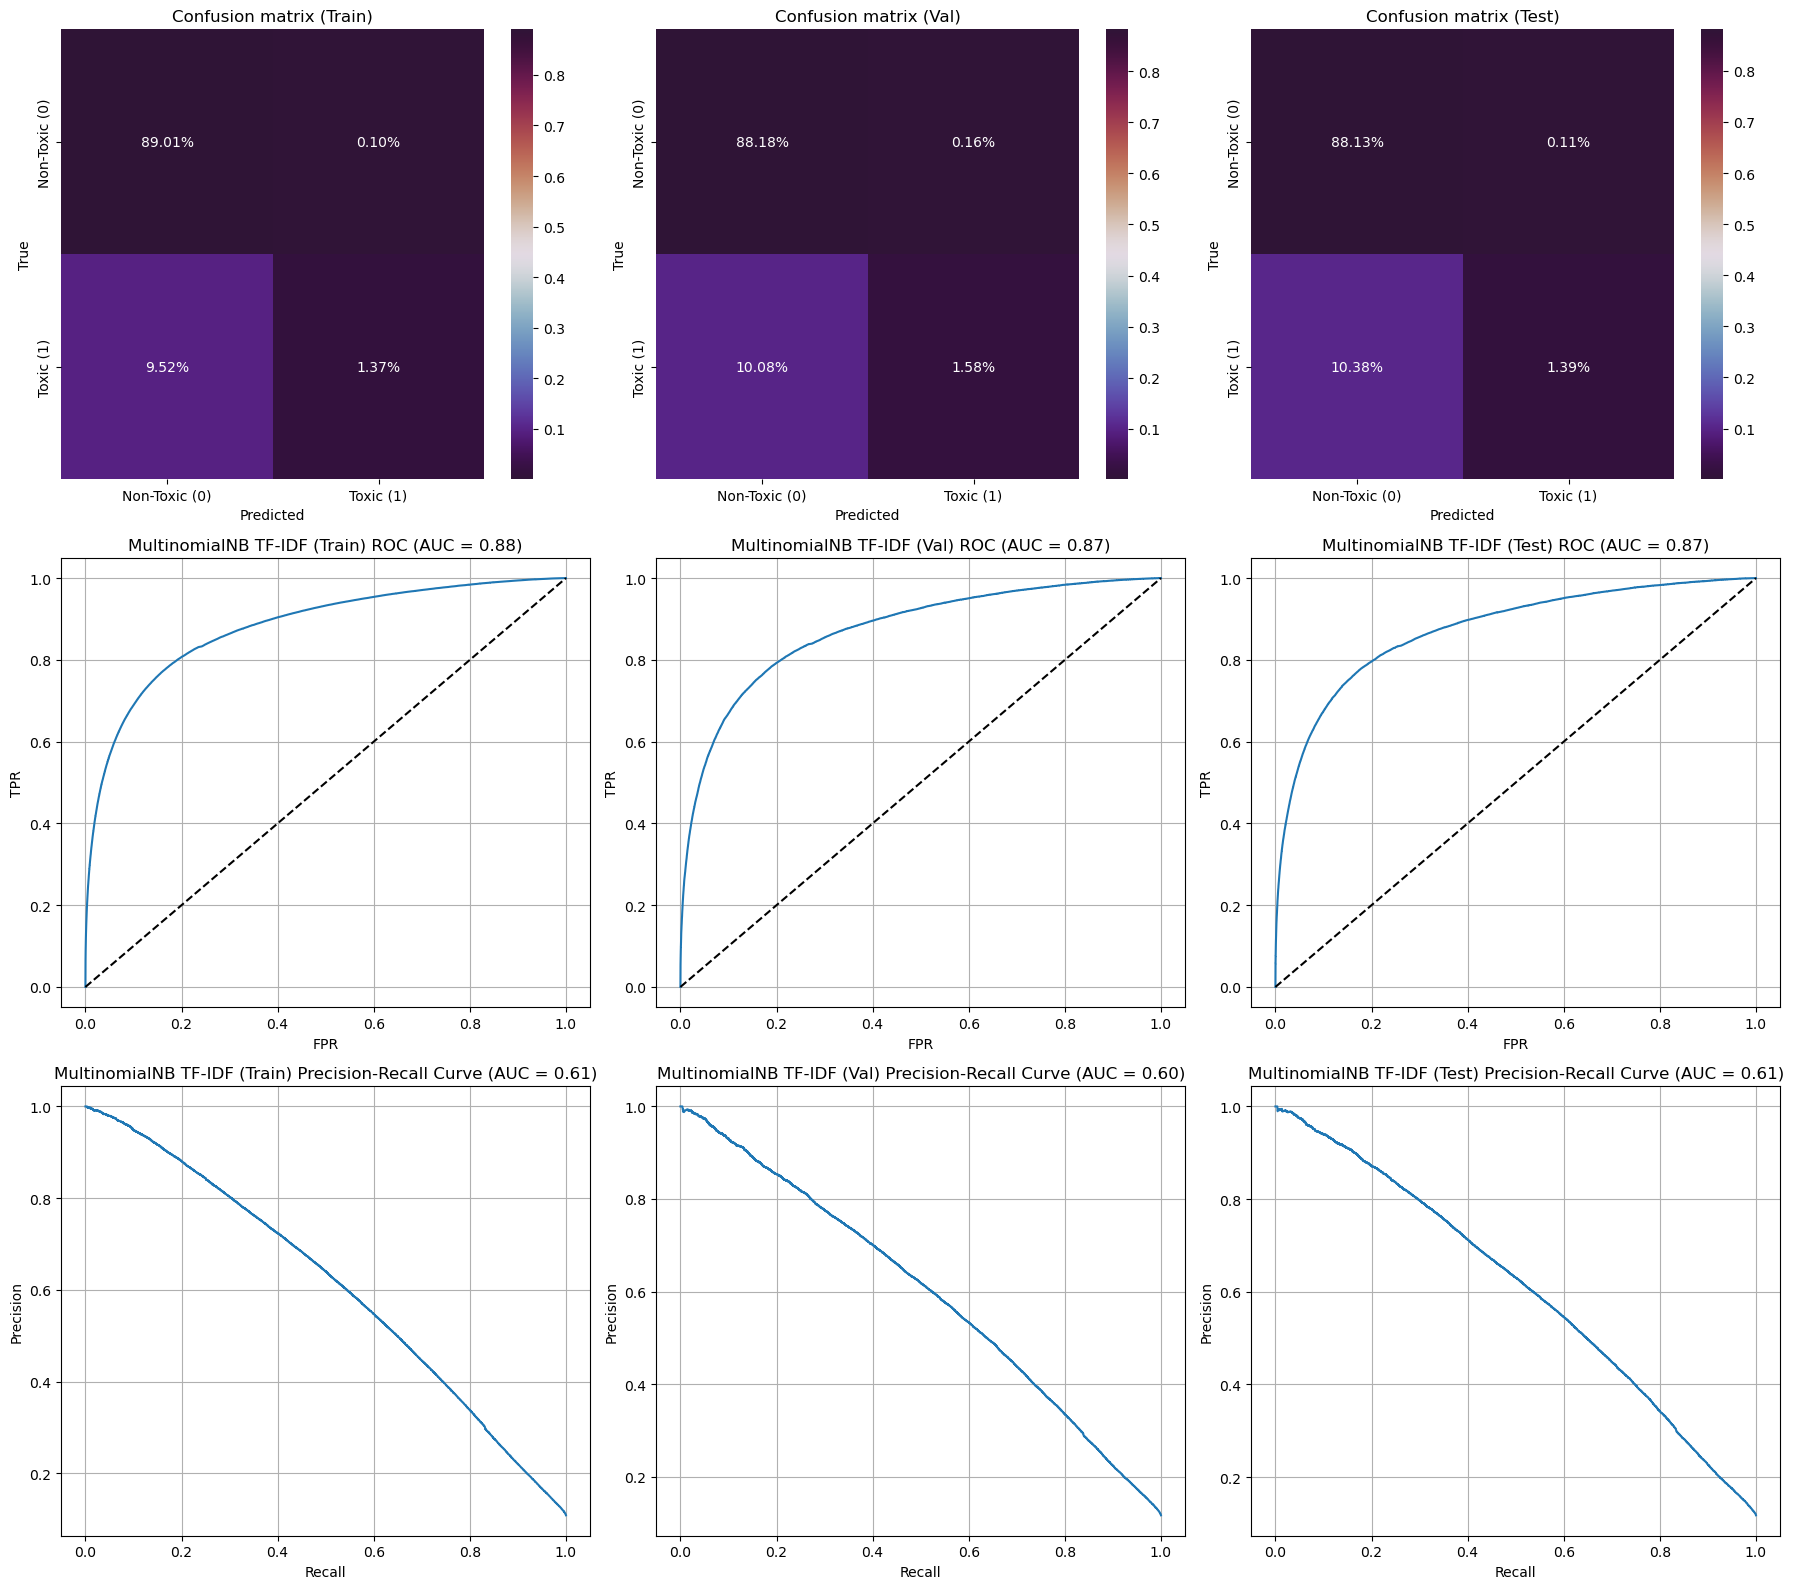

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_pred_train,
    y_pred_val=y_nb_tfidf_pred_val,
    y_pred_test=y_nb_tfidf_pred_test,
    y_pred_proba_train=y_nb_tfidf_pred_proba_train,
    y_pred_proba_val=y_nb_tfidf_pred_proba_val,
    y_pred_proba_test=y_nb_tfidf_pred_proba_test,
    title='MultinomialNB TF-IDF'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_TF-IDF"
stage = 'ML models optuna'
metrics = classification_metrics(y_train, y_nb_tfidf_ngrams_pred_train, y_nb_tfidf_ngrams_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_TF-IDF"
metrics = classification_metrics(y_val, y_nb_tfidf_ngrams_pred_val, y_nb_tfidf_ngrams_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_TF-IDF"
metrics = classification_metrics(y_test, y_nb_tfidf_ngrams_pred_test, y_nb_tfidf_ngrams_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

#### Биграммы

In [ ]:
best_alpha = get_hyperparams(X_train_tfidf_ngrams, X_val_tfidf_ngrams, y_train, y_val, mnb_objective).get('alpha', 1)
(
    y_nb_tfidf_ngrams_pred_train,
    y_nb_tfidf_ngrams_pred_val,
    y_nb_tfidf_ngrams_pred_test,
    y_nb_tfidf_ngrams_pred_proba_train,
    y_nb_tfidf_ngrams_pred_proba_val,
    y_nb_tfidf_ngrams_pred_proba_test
) = train_and_predict_toxicity(
    model=MultinomialNB(alpha=best_alpha),
    X_train=X_train_tfidf_ngrams,
    X_val=X_val_tfidf_ngrams,
    X_test=X_test_tfidf_ngrams,
    y_train=y_train,
)

[I 2024-12-07 03:37:07,261] A new study created in memory with name: no-name-2075dc88-7f98-492d-af60-f838a7f4fd77
[I 2024-12-07 03:37:07,563] Trial 0 finished with value: 0.2801474985050827 and parameters: {'alpha': 0.0039261501460008934}. Best is trial 0 with value: 0.2801474985050827.
[I 2024-12-07 03:37:07,779] Trial 1 finished with value: 0.27843489544342964 and parameters: {'alpha': 0.11639704571576052}. Best is trial 0 with value: 0.2801474985050827.
[I 2024-12-07 03:37:07,996] Trial 2 finished with value: 0.25999188476364377 and parameters: {'alpha': 1.201928973542583}. Best is trial 0 with value: 0.2801474985050827.
[I 2024-12-07 03:37:08,213] Trial 3 finished with value: 0.2463883400477278 and parameters: {'alpha': 1.9599575022868772}. Best is trial 0 with value: 0.2801474985050827.
[I 2024-12-07 03:37:08,430] Trial 4 finished with value: 0.27966798773648394 and parameters: {'alpha': 0.051024679941535735}. Best is trial 0 with value: 0.2801474985050827.
[I 2024-12-07 03:37:08,

MultinomialNB TF-IDF

Precision		Recall			F1

Train: 0.87		Train: 0.16		Train: 0.27
Val: 0.82		Val: 0.17		Val: 0.28
Test: 0.87		Test: 0.15		Test: 0.25


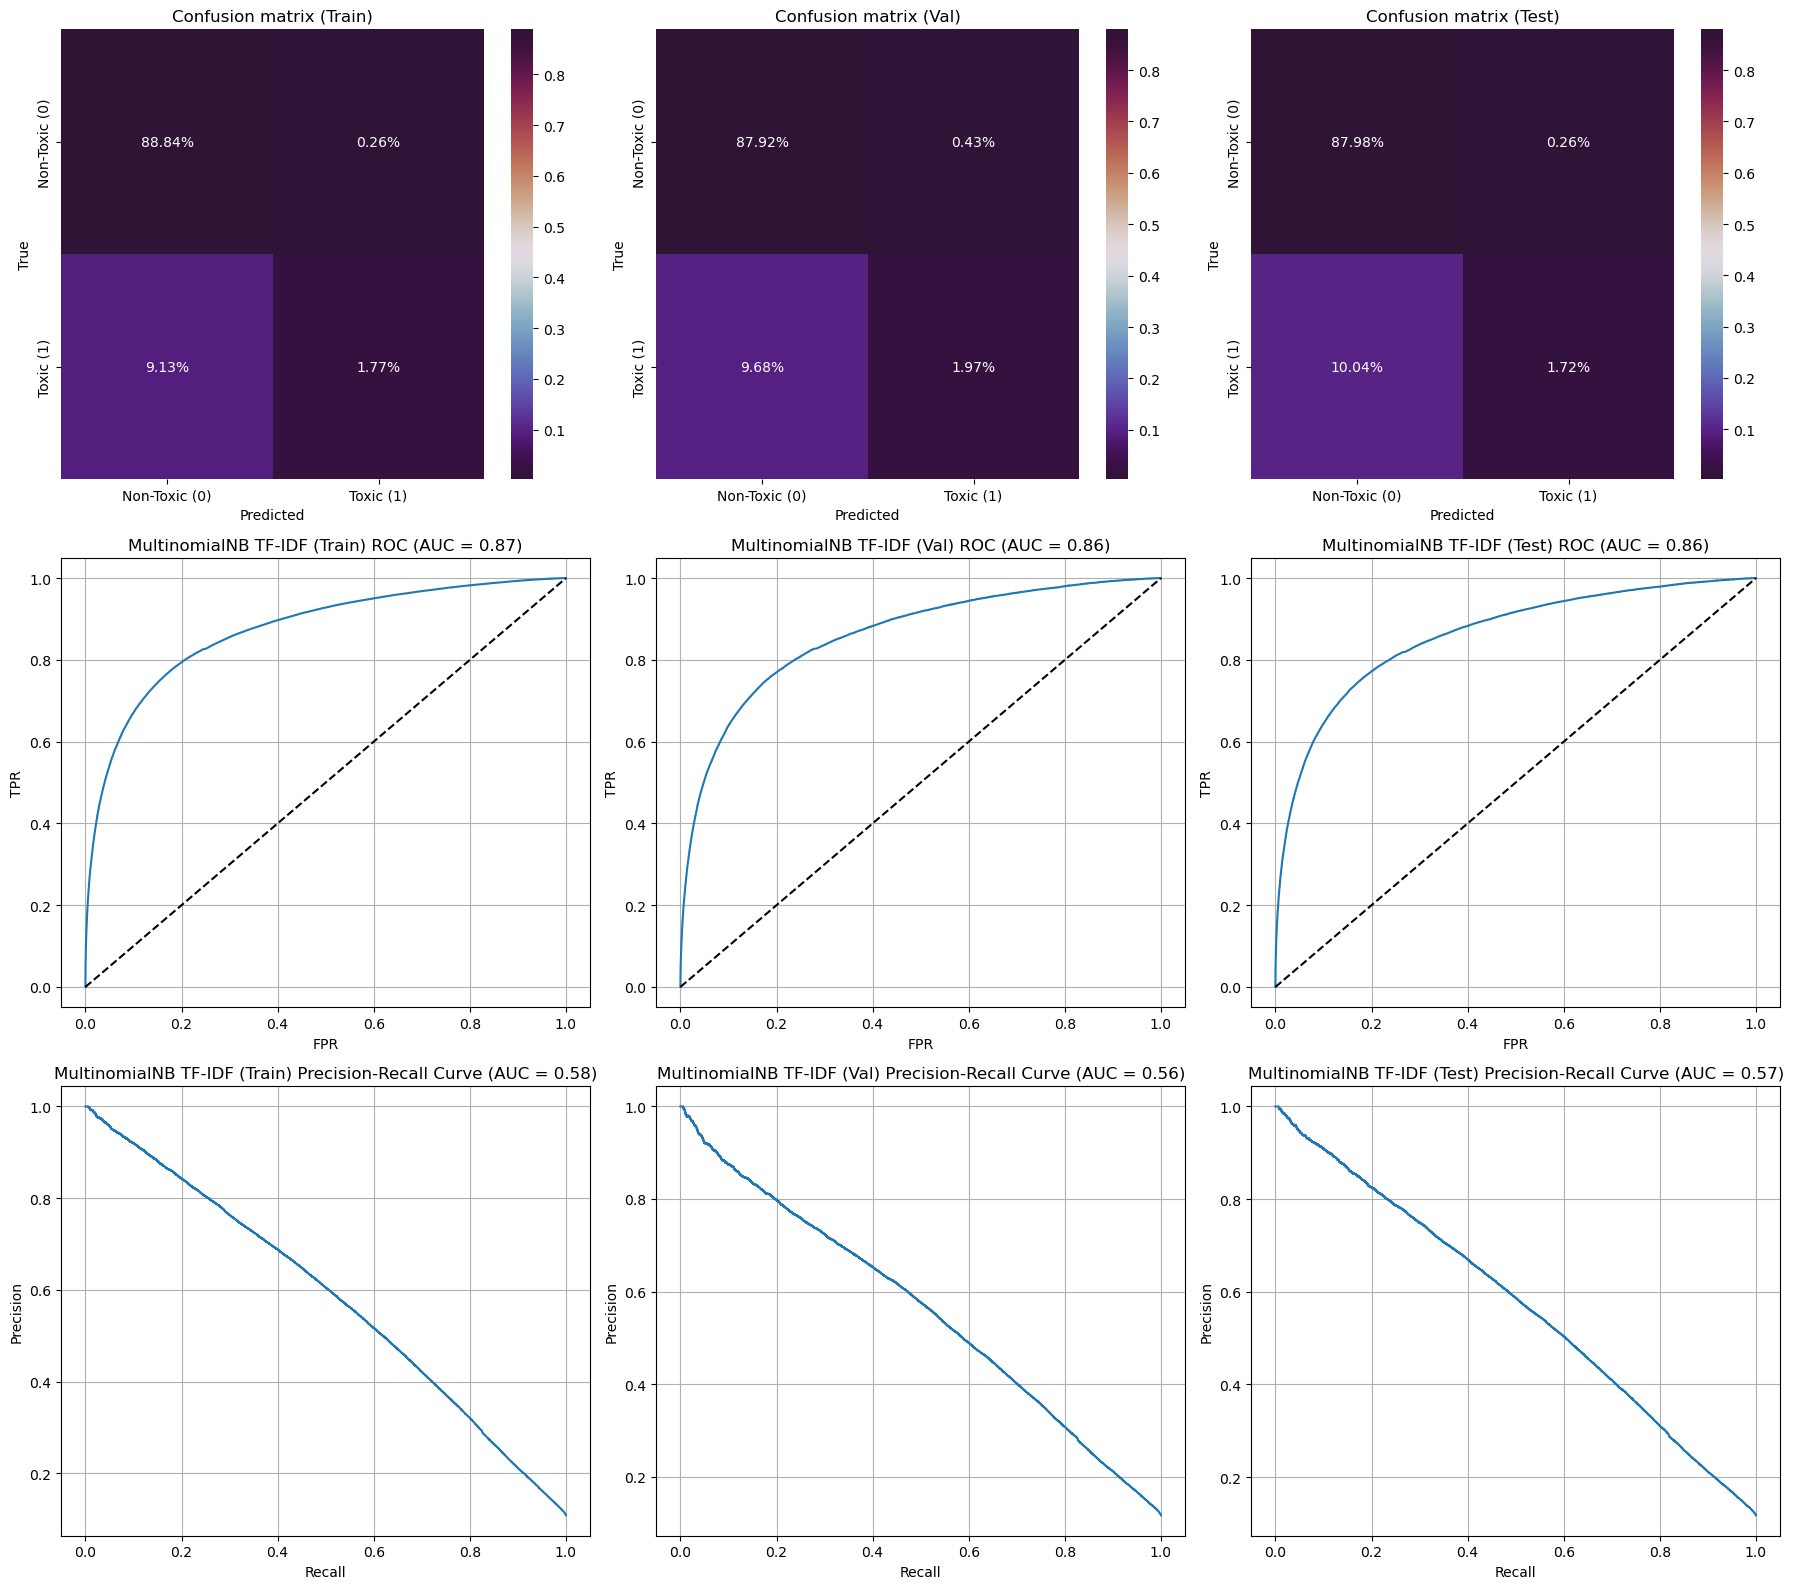

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_nb_tfidf_ngrams_pred_train,
    y_pred_val=y_nb_tfidf_ngrams_pred_val,
    y_pred_test=y_nb_tfidf_ngrams_pred_test,
    y_pred_proba_train=y_nb_tfidf_ngrams_pred_proba_train,
    y_pred_proba_val=y_nb_tfidf_ngrams_pred_proba_val,
    y_pred_proba_test=y_nb_tfidf_ngrams_pred_proba_test,
    title='MultinomialNB TF-IDF'
)

In [ ]:
model_name = "MultinomialNB"
dataset_name = "Dataset_Train_TF-IDF_Bigrams"
stage = 'ML models optuna'
metrics = classification_metrics(y_train, y_nb_tfidf_ngrams_pred_train, y_nb_tfidf_ngrams_pred_proba_train)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Val_TF-IDF_Bigrams"
metrics = classification_metrics(y_val, y_nb_tfidf_ngrams_pred_val, y_nb_tfidf_ngrams_pred_proba_val)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)
dataset_name = "Dataset_Test_TF-IDF_Bigrams"
metrics = classification_metrics(y_test, y_nb_tfidf_ngrams_pred_test, y_nb_tfidf_ngrams_pred_proba_test)
df_metrics = save_metrics_to_dataframe(model_name, dataset_name, metrics, stage, df=df_metrics)

In [ ]:
df_metrics.loc[63:]

Model                       Dataset             Stage  \
63  Logistic_Regression          Dataset_Train_TF-IDF  ML models optuna   
64  Logistic_Regression            Dataset_Val_TF-IDF  ML models optuna   
65  Logistic_Regression           Dataset_Test_TF-IDF  ML models optuna   
66                  SVM          Dataset_Train_TF-IDF  ML models optuna   
67                  SVM            Dataset_Val_TF-IDF  ML models optuna   
68                  SVM           Dataset_Test_TF-IDF  ML models optuna   
69        MultinomialNB          Dataset_Train_TF-IDF  ML models optuna   
70        MultinomialNB            Dataset_Val_TF-IDF  ML models optuna   
71        MultinomialNB           Dataset_Test_TF-IDF  ML models optuna   
72        MultinomialNB  Dataset_Train_TF-IDF_Bigrams  ML models optuna   
73        MultinomialNB    Dataset_Val_TF-IDF_Bigrams  ML models optuna   
74        MultinomialNB   Dataset_Test_TF-IDF_Bigrams  ML models optuna   

    Accuracy  Precision  Recall  F1 Score  ROC AUC  
63      0.88       0.48    0.83      0.61     0.94  
64      0.87       0.48    0.82      0.60     0.93  
65      0.88       0.48    0.82      0.61     0.93  
66      0.89       0.49    0.80      0.61     0.93  
67      0.88       0.49    0.80      0.61     0.93  
68      0.88       0.50    0.80      0.61     0.93  
69      0.91       0.87    0.16      0.27     0.87  
70      0.90       0.82    0.17      0.28     0.86  
71      0.90       0.87    0.15      0.25     0.86  
72      0.91       0.87    0.16      0.27     0.87  
73      0.90       0.82    0.17      0.28     0.86  
74      0.90       0.87    0.15      0.25     0.86

Почти тоже самое, что и про обучение моделей на BoW с помощью подбора параметров `optuna` можно сказать про обучение и предсказание моделей на TF-IDF. Однако метрики до сих пор остаются меньше, чем у BoW для случая с подбором параметров.

# Бонусная часть

С целью хоть как-то улучшить результат базовых моделей было решено использовать ансамблевые модели по типу градиентного бустинга. Для обучения данных моделей будет применяться только мешок слов (BoW), так как именно на таких данных базовые модели показали наилучший результат при подборе гиперпараметров.

## Градиентный бустинг

Для обучения были выбраны две модели градиентного бустинга. Это `CatBoostClassifier` и `XGBClassifier`. Для начала рассмотрим насколько хорошо эти модели обучатся без подбора гиперпараметров, а затем уже подберем их с помощью библиотеки `optuna`. При этом будет использоваться балансировка классов в каждой модели (даже без подбора гиперпараметров), так как в выборке наблюдается дисбаланс классов.

### XGBoost

In [ ]:
(
    y_m1_bow_pred_train,
    y_m1_bow_pred_val,
    y_m1_bow_pred_test,
    y_m1_bow_pred_proba_train,
    y_m1_bow_pred_proba_val,
    y_m1_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBClassifier(use_label_encoder=False, random_state=42, scale_pos_weigh = 9),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_m1_bow_pred_train,
    y_pred_val=y_m1_bow_pred_val,
    y_pred_test=y_m1_bow_pred_test,
    y_pred_proba_train=y_m1_bow_pred_proba_train,
    y_pred_proba_val=y_m1_bow_pred_proba_val,
    y_pred_proba_test=y_m1_bow_pred_proba_test,
    title='XGBoost BoW'
)

XGBoost BoW

| Metric      | Precision | Recall | F1   |
|-------------|-----------|--------|------|
| Train       | 0.83      | 0.37   | 0.51 |
| Validation  | 0.80      | 0.35   | 0.49 |
| Test        | 0.81      | 0.35   | 0.49 |

![XGBoost](images/XGBoost.png)

### XGBoost Optuna

In [ ]:
def xg_objective(trial, X_train, X_val, y_train, y_val):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.2, 0.5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "use_label_encoder": False,
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 10)
    }

    model = XGBClassifier(**param)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

In [ ]:
best_xg_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, xg_objective, n_trials=10)

(
    y_m1_bow_pred_train,
    y_m1_bow_pred_val,
    y_m1_bow_pred_test,
    y_m1_bow_pred_proba_train,
    y_m1_bow_pred_proba_val,
    y_m1_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBClassifier(**best_xg_params),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_m1_bow_pred_train,
    y_pred_val=y_m1_bow_pred_val,
    y_pred_test=y_m1_bow_pred_test,
    y_pred_proba_train=y_m1_bow_pred_proba_train,
    y_pred_proba_val=y_m1_bow_pred_proba_val,
    y_pred_proba_test=y_m1_bow_pred_proba_test,
    title='XGBoost BoW'
)

XGBoost BoW

| Metric      | Precision | Recall | F1   |
|-------------|-----------|--------|------|
| Train       | 0.76      | 0.80   | 0.78 |
| Validation  | 0.65      | 0.65   | 0.65 |
| Test        | 0.65      | 0.66   | 0.65 |

![XGBoost](./images/XGBoostO.png)

### CatBoost

In [ ]:
(
    y_cb_bow_pred_train,
    y_cb_bow_pred_val,
    y_cb_bow_pred_test,
    y_cb_bow_pred_proba_train,
    y_cb_bow_pred_proba_val,
    y_cb_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=CatBoostClassifier(verbose=0 , early_stopping_rounds=50),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_cb_bow_pred_train,
    y_pred_val=y_cb_bow_pred_val,
    y_pred_test=y_cb_bow_pred_test,
    y_pred_proba_train=y_cb_bow_pred_proba_train,
    y_pred_proba_val=y_cb_bow_pred_proba_val,
    y_pred_proba_test=y_cb_bow_pred_proba_test,
    title='CatBoost BoW'
)

CatBoost BoW

| Metric      | Precision | Recall | F1   |
|-------------|-----------|--------|------|
| Train       | 0.80      | 0.48   | 0.60 |
| Validation  | 0.77      | 0.46   | 0.57 |
| Test        | 0.78      | 0.46   | 0.58 |

![XGBoost](images/CatBoost.png)

### CatBoost Optuna

In [ ]:
def cb_objective(trial, X_train, X_val, y_train, y_val):
    params = {
        'verbose': False,
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 6, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': 'Iter',
        'od_wait': 50
    }

    cb = CatBoostClassifier(**params, auto_class_weights='Balanced', eval_metric = 'F1')
    cb.fit(X_train, y_train)

    y_pred = cb.predict(X_val)
    return f1_score(y_val, y_pred)

In [ ]:
cat_params = {
    'iterations': 767,          # Количество итераций
    'depth': 12,                # Глубина деревьев
    'learning_rate': 0.3,       # Скорость обучения
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.9,           # Доля выборки
    'colsample_bylevel': 0.7,   # Доля признаков
    'l2_leaf_reg': 3,           # L2-регуляризация
    'min_data_in_leaf': 6,      # Минимальное число данных в листе
    'class_weights': [1, 3],    # Вес классов
    'eval_metric': 'F1',        # Метрика
    'random_seed': 42,
    'verbose': False              # Периодичность вывода лога
}

In [ ]:
#best_cd_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, cb_objective, n_trials=10)

(
    y_cb_bow_pred_train,
    y_cb_bow_pred_val,
    y_cb_bow_pred_test,
    y_cb_bow_pred_proba_train,
    y_cb_bow_pred_proba_val,
    y_cb_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=CatBoostClassifier(**cat_params , early_stopping_rounds=50),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

In [ ]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_cb_bow_pred_train,
    y_pred_val=y_cb_bow_pred_val,
    y_pred_test=y_cb_bow_pred_test,
    y_pred_proba_train=y_cb_bow_pred_proba_train,
    y_pred_proba_val=y_cb_bow_pred_proba_val,
    y_pred_proba_test=y_cb_bow_pred_proba_test,
    title='CatBoost BoW'
)

CatBoost BoW

| Metric      | Precision | Recall | F1   |
|-------------|-----------|--------|------|
| Train       | 0.70      | 0.73   | 0.72 |
| Validation  | 0.64      | 0.65   | 0.65 |
| Test        | 0.65      | 0.66   | 0.65 |

![XGBoost](images/CatBoostO.png)

### CatBoost TfIdf + SVD

Попробуем снизить размерность матрицы признаков при помощи `TruncatedSVD` и проверим, как это отразится на метриках

In [ ]:
from sklearn.decomposition import TruncatedSVD

In [ ]:
%%time
vec = TfidfVectorizer(ngram_range=(1, 1),
                      min_df=40,
                      tokenizer=lambda x: x.split('\t'),
                      strip_accents=None,
                      lowercase=False,
                      preprocessor=None,
                      stop_words=None,
                      token_pattern=None)
X_train_tfidf = vec.fit_transform(X_train)
X_val_tfidf = vec.transform(X_val)

CPU times: user 27.5 s, sys: 343 ms, total: 27.8 s
Wall time: 1min 9s


In [ ]:
X_train_tfidf.shape

(1092977, 21813)

In [ ]:
svd = TruncatedSVD(n_components=300, random_state=42)

In [ ]:
%%time
X_train_tfidf_reduced = svd.fit_transform(X_train_tfidf)
X_val_tfidf_reduced = svd.transform(X_val_tfidf)

CPU times: user 4min 39s, sys: 33.8 s, total: 5min 13s
Wall time: 4min 21s


In [ ]:
X_train_tfidf_reduced.shape

(1092977, 300)

In [ ]:
clf_cb = CatBoostClassifier(
    task_type='GPU',
    auto_class_weights='Balanced',
    early_stopping_rounds=50,
    subsample=0.6,
    bootstrap_type='Bernoulli',
    border_count=256,
    depth=8,
    iterations=1500,
    learning_rate=0.1,
    l2_leaf_reg=2,
    loss_function='Logloss')

In [ ]:
clf_cb.fit(X_train_tfidf_reduced, y_train['toxicity'], eval_set=(X_val_tfidf_reduced, y_val['toxicity']))

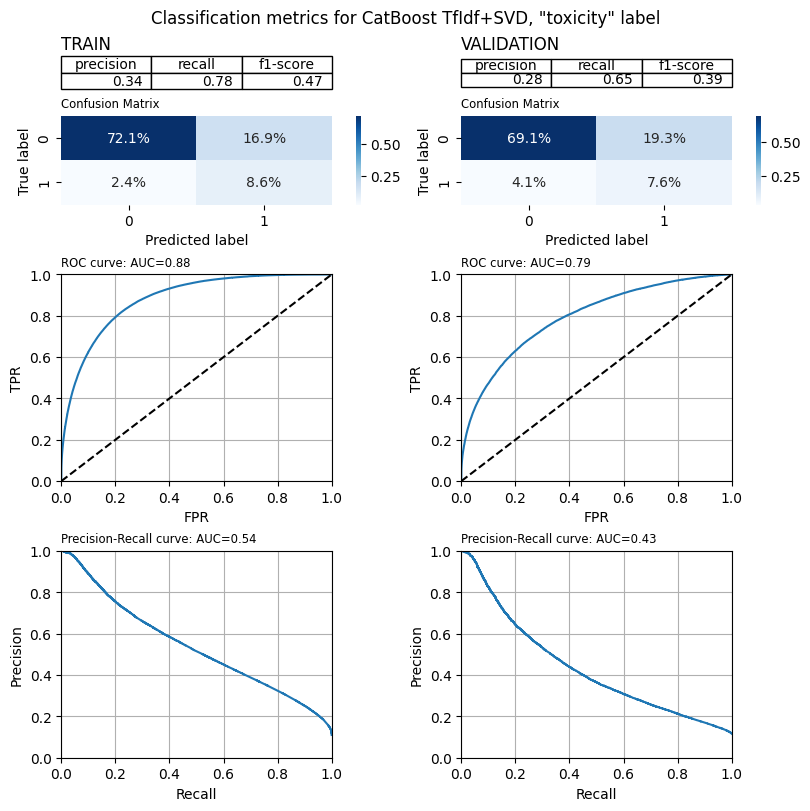

In [ ]:
plot_metrics_single(clf_cb, 'CatBoost TfIdf+SVD', 'toxicity',  X_train_tfidf_reduced, y_train['toxicity'], X_val_tfidf_reduced, y_val['toxicity'], 'TRAIN', 'VALIDATION')

Градиентный бустинг без подбора параметров показывает себя слегка хуже при обучении на мешке слов, чем модели `Linear_SVC` и `Logistic_Regression`. Однако при подборе гиперпараметров через библиотеку `optuna` как модель `XGBoost`, так и `CatBoost` показывают наиболее сбалансированные результаты в плане метрик `precision` и `recall`, что говорит о том, что модели относительно неплохо различают класс Toxic и делают меньше пропусков, а также они показывают наиболее высокие значения метрики `F-1`. При этом стоит отметить, что имеется вероятность того, что для данных моделей можно подобрать параметры и лучше, так как параметры для `XGBoost` подбирались при параметре `trials = 10`, а параметры для модели `CatBoost` и вовсе не подбирались отдельно. Для модели `CatBoost` гиперпараметры были взяты из модели `XGBoost`. Это было сделано, так как `CatBoost` довольно плохо работает с нашими данными. Для сравнения подбор гиперпараметров для модели `XGBoost` и обучение модели по ним длилось 30 минут, а просто обучение уже с готовыми параметрами для `CatBoost` длилось 2 часа. Вероятно это происходит из-за того, что модель `XGBoost` является более приспособленной к разряженным данным, чем по сути и является мешок слов.

In [50]:
def decision_tree_objective(trial, X_train, X_val, y_train, y_val):
    max_depth = trial.suggest_int('max_depth', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Минимальное количество образцов для разделения
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Минимальное количество образцов в листе


    model = DecisionTreeClassifier(
        max_depth=max_depth,
        criterion=criterion,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",
        random_state=42,
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

In [51]:
from sklearn.tree import DecisionTreeClassifier

best_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, decision_tree_objective, n_trials=30)
(y_decision_tree_bow_pred_train,
 y_decision_tree_bow_pred_val,
 y_decision_tree_bow_pred_test,
 y_decision_tree_bow_pred_proba_train,
 y_decision_tree_bow_pred_proba_val,
 y_decision_tree_bow_pred_proba_test
 ) = train_and_predict_toxicity(
    model=DecisionTreeClassifier(**best_params, random_state=42),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2025-02-27 03:59:39,734] A new study created in memory with name: no-name-728c41a1-58aa-4ca2-9f26-6c3b39550c07
[I 2025-02-27 03:59:47,485] Trial 0 finished with value: 0.3657783004764088 and parameters: {'max_depth': 7, 'criterion': 'gini', 'min_samples_split': 17, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.3657783004764088.
[I 2025-02-27 03:59:52,975] Trial 1 finished with value: 0.34904282933160286 and parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_split': 16, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.3657783004764088.
[I 2025-02-27 04:00:03,837] Trial 2 finished with value: 0.38576991566052876 and parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_split': 18, 'min_samples_leaf': 20}. Best is trial 2 with value: 0.38576991566052876.
[I 2025-02-27 04:00:10,203] Trial 3 finished with value: 0.3487645555239989 and parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 2

DecisionTreeClassifier BoW

Precision		Recall			F1

Train: 0.78		Train: 0.26		Train: 0.39
Val: 0.78		Val: 0.23		Val: 0.36
Test: 0.79		Test: 0.24		Test: 0.36


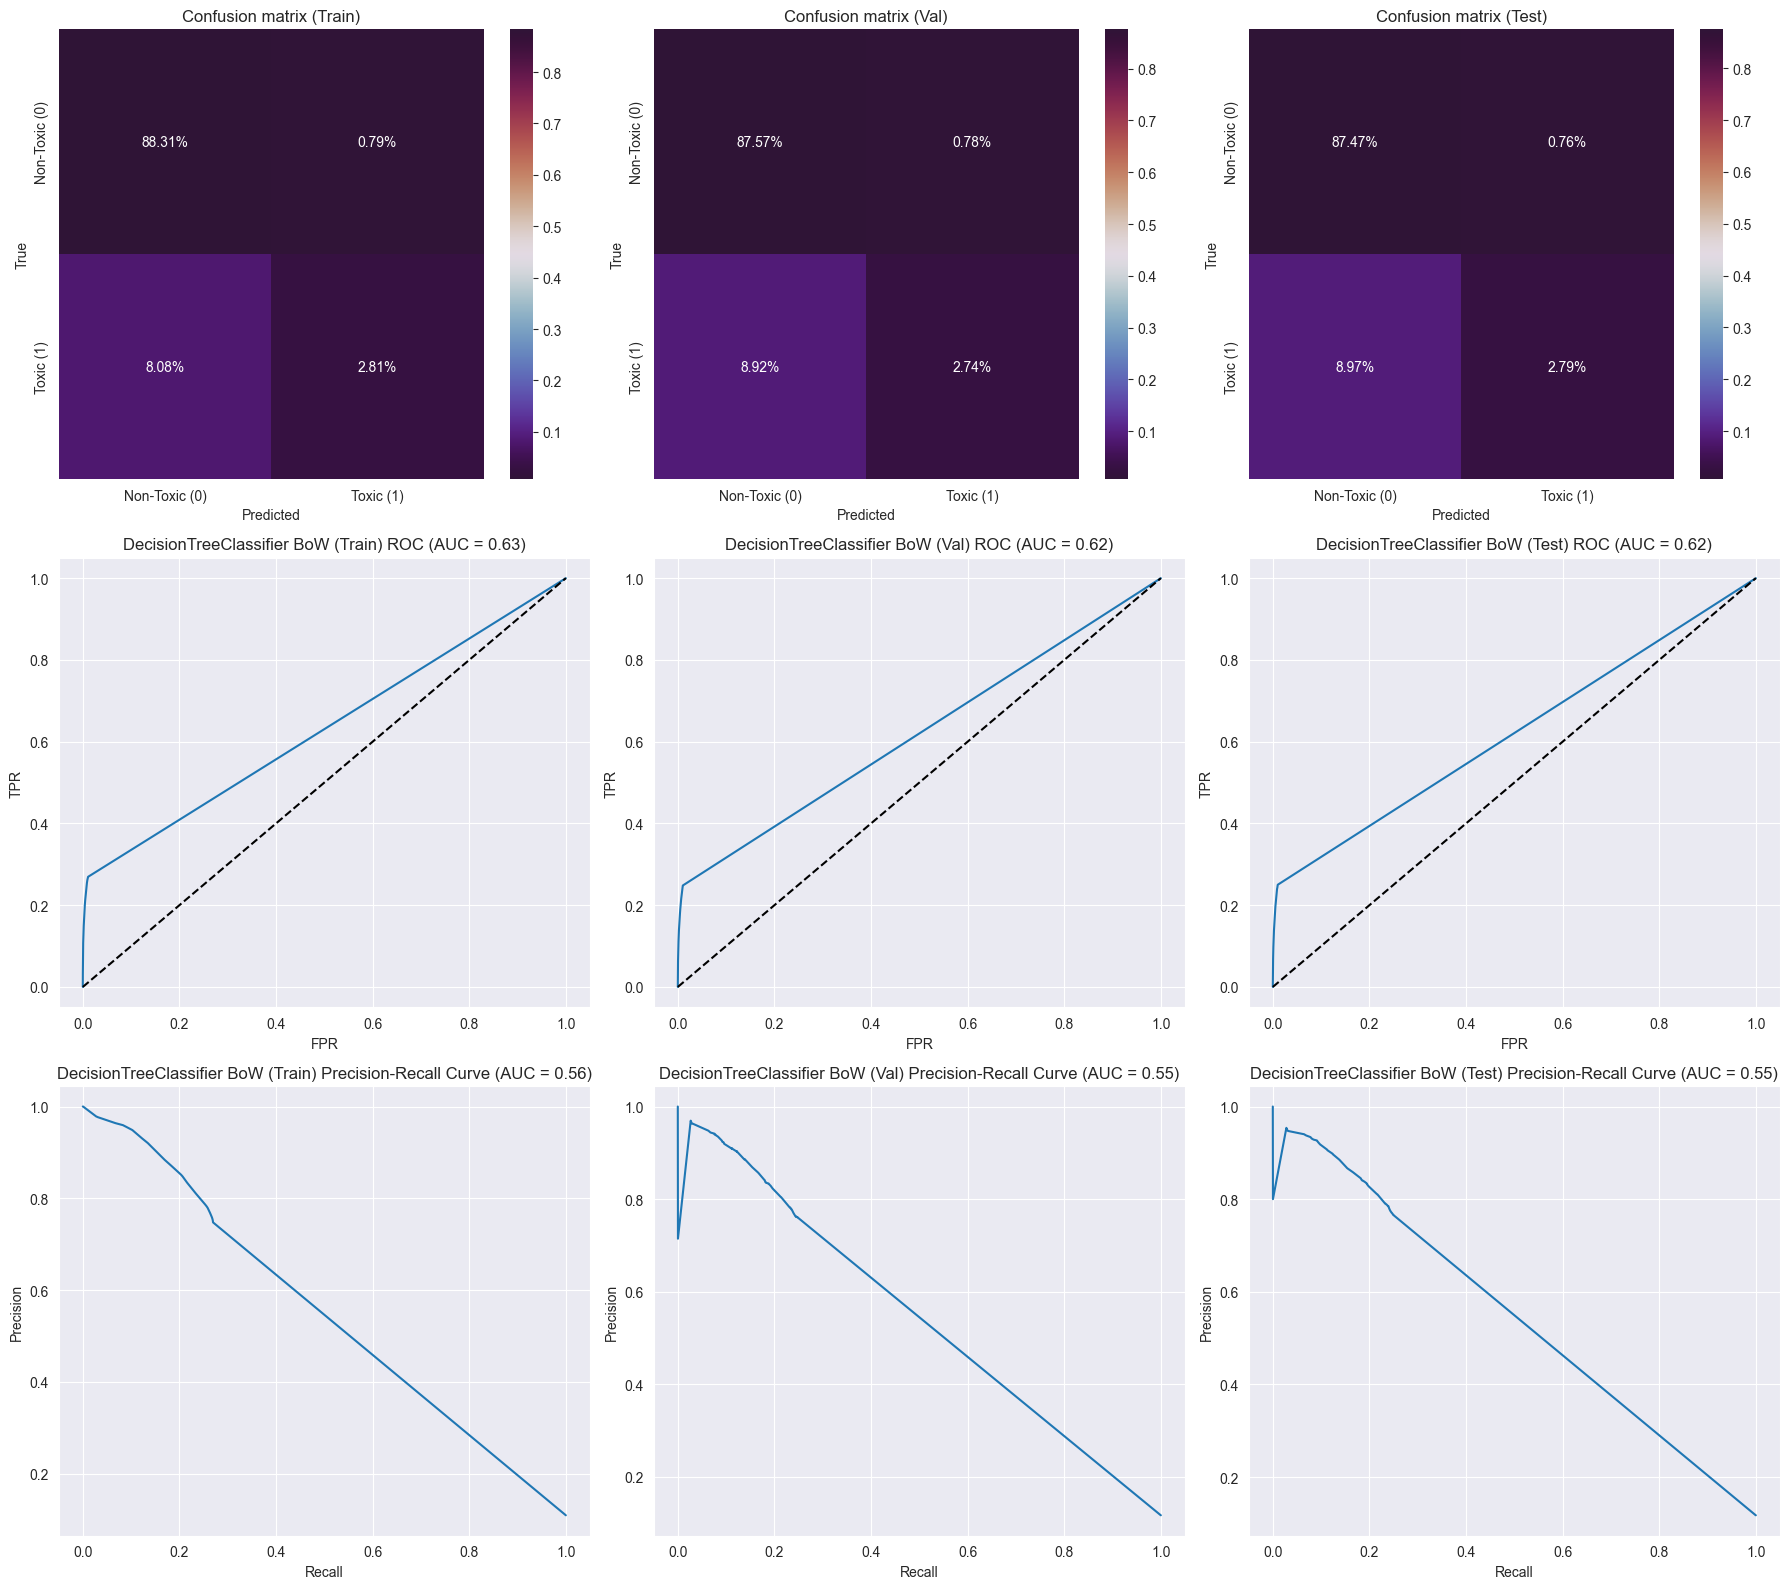

In [53]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train = y_decision_tree_bow_pred_train,
    y_pred_val = y_decision_tree_bow_pred_val,
    y_pred_test = y_decision_tree_bow_pred_test,
    y_pred_proba_train = y_decision_tree_bow_pred_proba_train,
    y_pred_proba_val = y_decision_tree_bow_pred_proba_val,
    y_pred_proba_test = y_decision_tree_bow_pred_proba_test,
    title='DecisionTreeClassifier BoW'
)

In [37]:
best_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, decision_tree_objective, n_trials=30)
(y_decision_tree_tfidf_pred_train,
 y_decision_tree_tfidf_pred_val,
 y_decision_tree_tfidf_pred_test,
 y_decision_tree_tfidf_pred_proba_train,
 y_decision_tree_tfidf_pred_proba_val,
 y_decision_tree_tfidf_pred_proba_test
 ) = train_and_predict_toxicity(
    model=DecisionTreeClassifier(**best_params, random_state=42),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2025-02-27 03:34:13,653] A new study created in memory with name: no-name-2fd2792e-91f2-4cc9-81f8-3c4e2a22ab67
[I 2025-02-27 03:34:18,399] Trial 0 finished with value: 0.12440672287676587 and parameters: {'max_depth': 1, 'criterion': 'entropy', 'min_samples_split': 17, 'min_samples_leaf': 12}. Best is trial 0 with value: 0.12440672287676587.
[I 2025-02-27 03:34:31,644] Trial 1 finished with value: 0.25039643971558645 and parameters: {'max_depth': 4, 'criterion': 'entropy', 'min_samples_split': 14, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.25039643971558645.
[I 2025-02-27 03:34:39,761] Trial 2 finished with value: 0.22206543326016515 and parameters: {'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 13, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.25039643971558645.
[I 2025-02-27 03:34:59,164] Trial 3 finished with value: 0.3049729197439685 and parameters: {'max_depth': 7, 'criterion': 'gini', 'min_samples_split': 5, 'min_samples_leaf': 15}. Best is tria

DecisionTreeClassifier TFIDF

Precision		Recall			F1

Train: 0.81		Train: 0.24		Train: 0.37
Val: 0.80		Val: 0.23		Val: 0.35
Test: 0.80		Test: 0.23		Test: 0.36


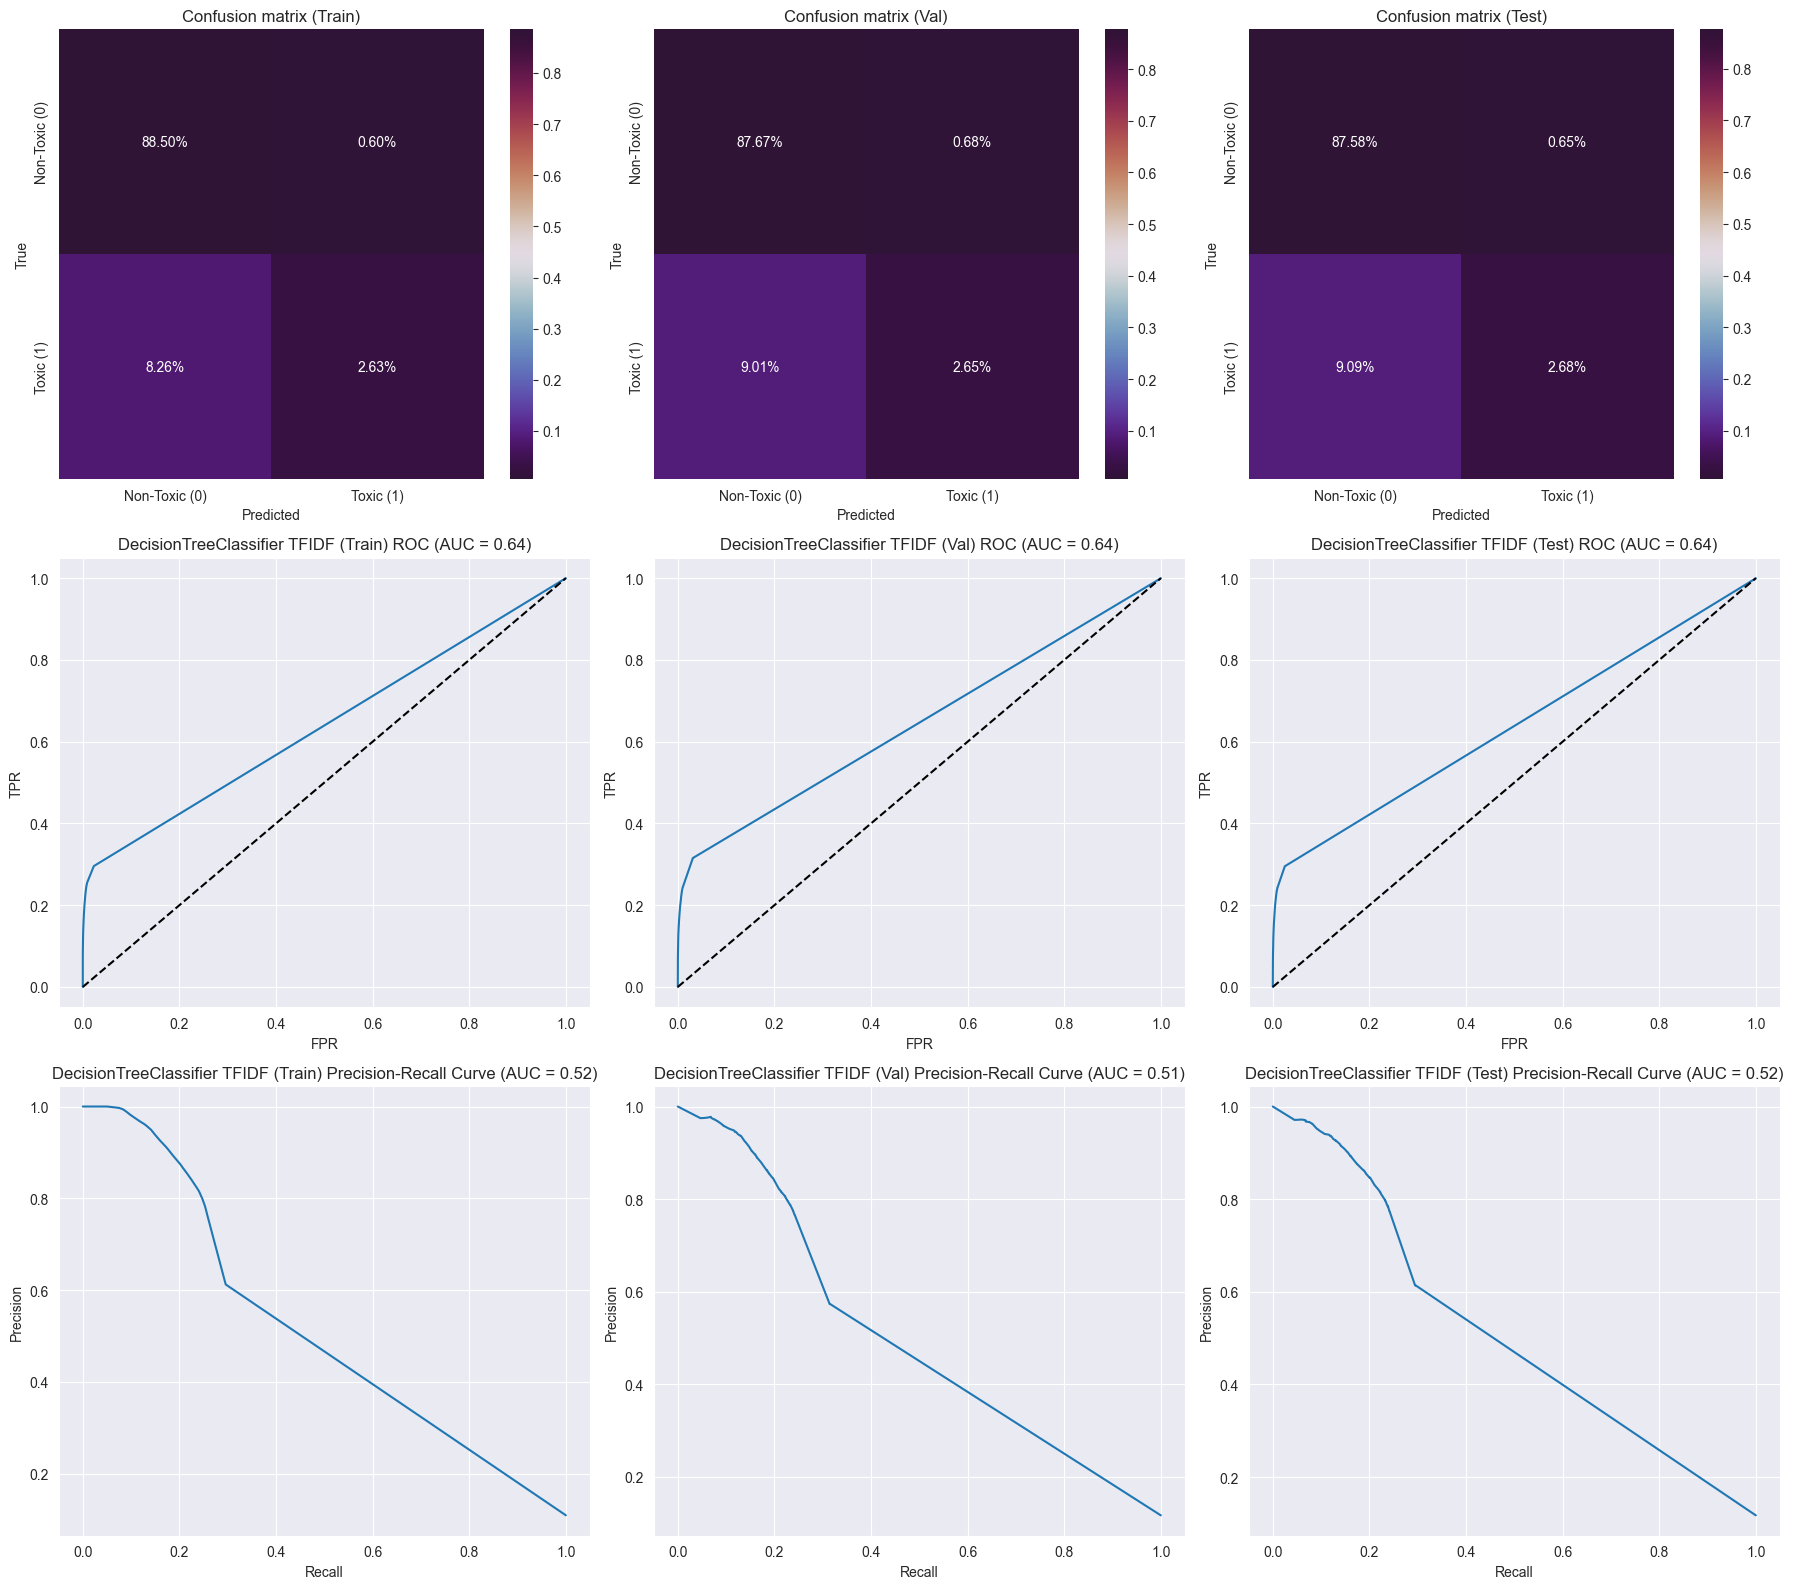

In [38]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train = y_decision_tree_tfidf_pred_train,
    y_pred_val = y_decision_tree_tfidf_pred_val,
    y_pred_test = y_decision_tree_tfidf_pred_test,
    y_pred_proba_train = y_decision_tree_tfidf_pred_proba_train,
    y_pred_proba_val = y_decision_tree_tfidf_pred_proba_val,
    y_pred_proba_test = y_decision_tree_tfidf_pred_proba_test,
    title='DecisionTreeClassifier TFIDF'
)

In [54]:
def random_forest_objective(trial, X_train, X_val, y_train, y_val):
    n_estimators = trial.suggest_int('n_estimators', 50, 80)  # Количество деревьев
    max_depth = trial.suggest_int('max_depth', 5, 20)  # Максимальная глубина деревьев
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Минимальное количество образцов для разделения
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Минимальное количество образцов в листе

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,  # Используем все ядра процессора
        class_weight="balanced",
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred)

In [62]:
best_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, random_forest_objective, n_trials=30)
(y_random_forest_bow_pred_train,
 y_random_forest_bow_pred_val,
 y_random_forest_bow_pred_test,
 y_random_forest_bow_pred_proba_train,
 y_random_forest_bow_pred_proba_val,
 y_random_forest_bow_pred_proba_test
 ) = train_and_predict_toxicity(
    model=RandomForestClassifier(**best_params, class_weight='balanced', random_state=42),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2025-02-27 04:18:55,706] A new study created in memory with name: no-name-669dd006-e5b3-4e9f-a7b8-90054ae75560
[I 2025-02-27 04:18:59,382] Trial 0 finished with value: 0.4364267716868873 and parameters: {'n_estimators': 68, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.4364267716868873.
[I 2025-02-27 04:19:06,487] Trial 1 finished with value: 0.4719413903604838 and parameters: {'n_estimators': 62, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.4719413903604838.
[I 2025-02-27 04:19:12,383] Trial 2 finished with value: 0.4716588608067596 and parameters: {'n_estimators': 64, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.4719413903604838.
[I 2025-02-27 04:19:16,685] Trial 3 finished with value: 0.49163817084299993 and parameters: {'n_estimators': 74, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.

RandomForestClassifier BOW

Precision		Recall			F1

Train: 0.39		Train: 0.68		Train: 0.50
Val: 0.39		Val: 0.68		Val: 0.50
Test: 0.40		Test: 0.67		Test: 0.50


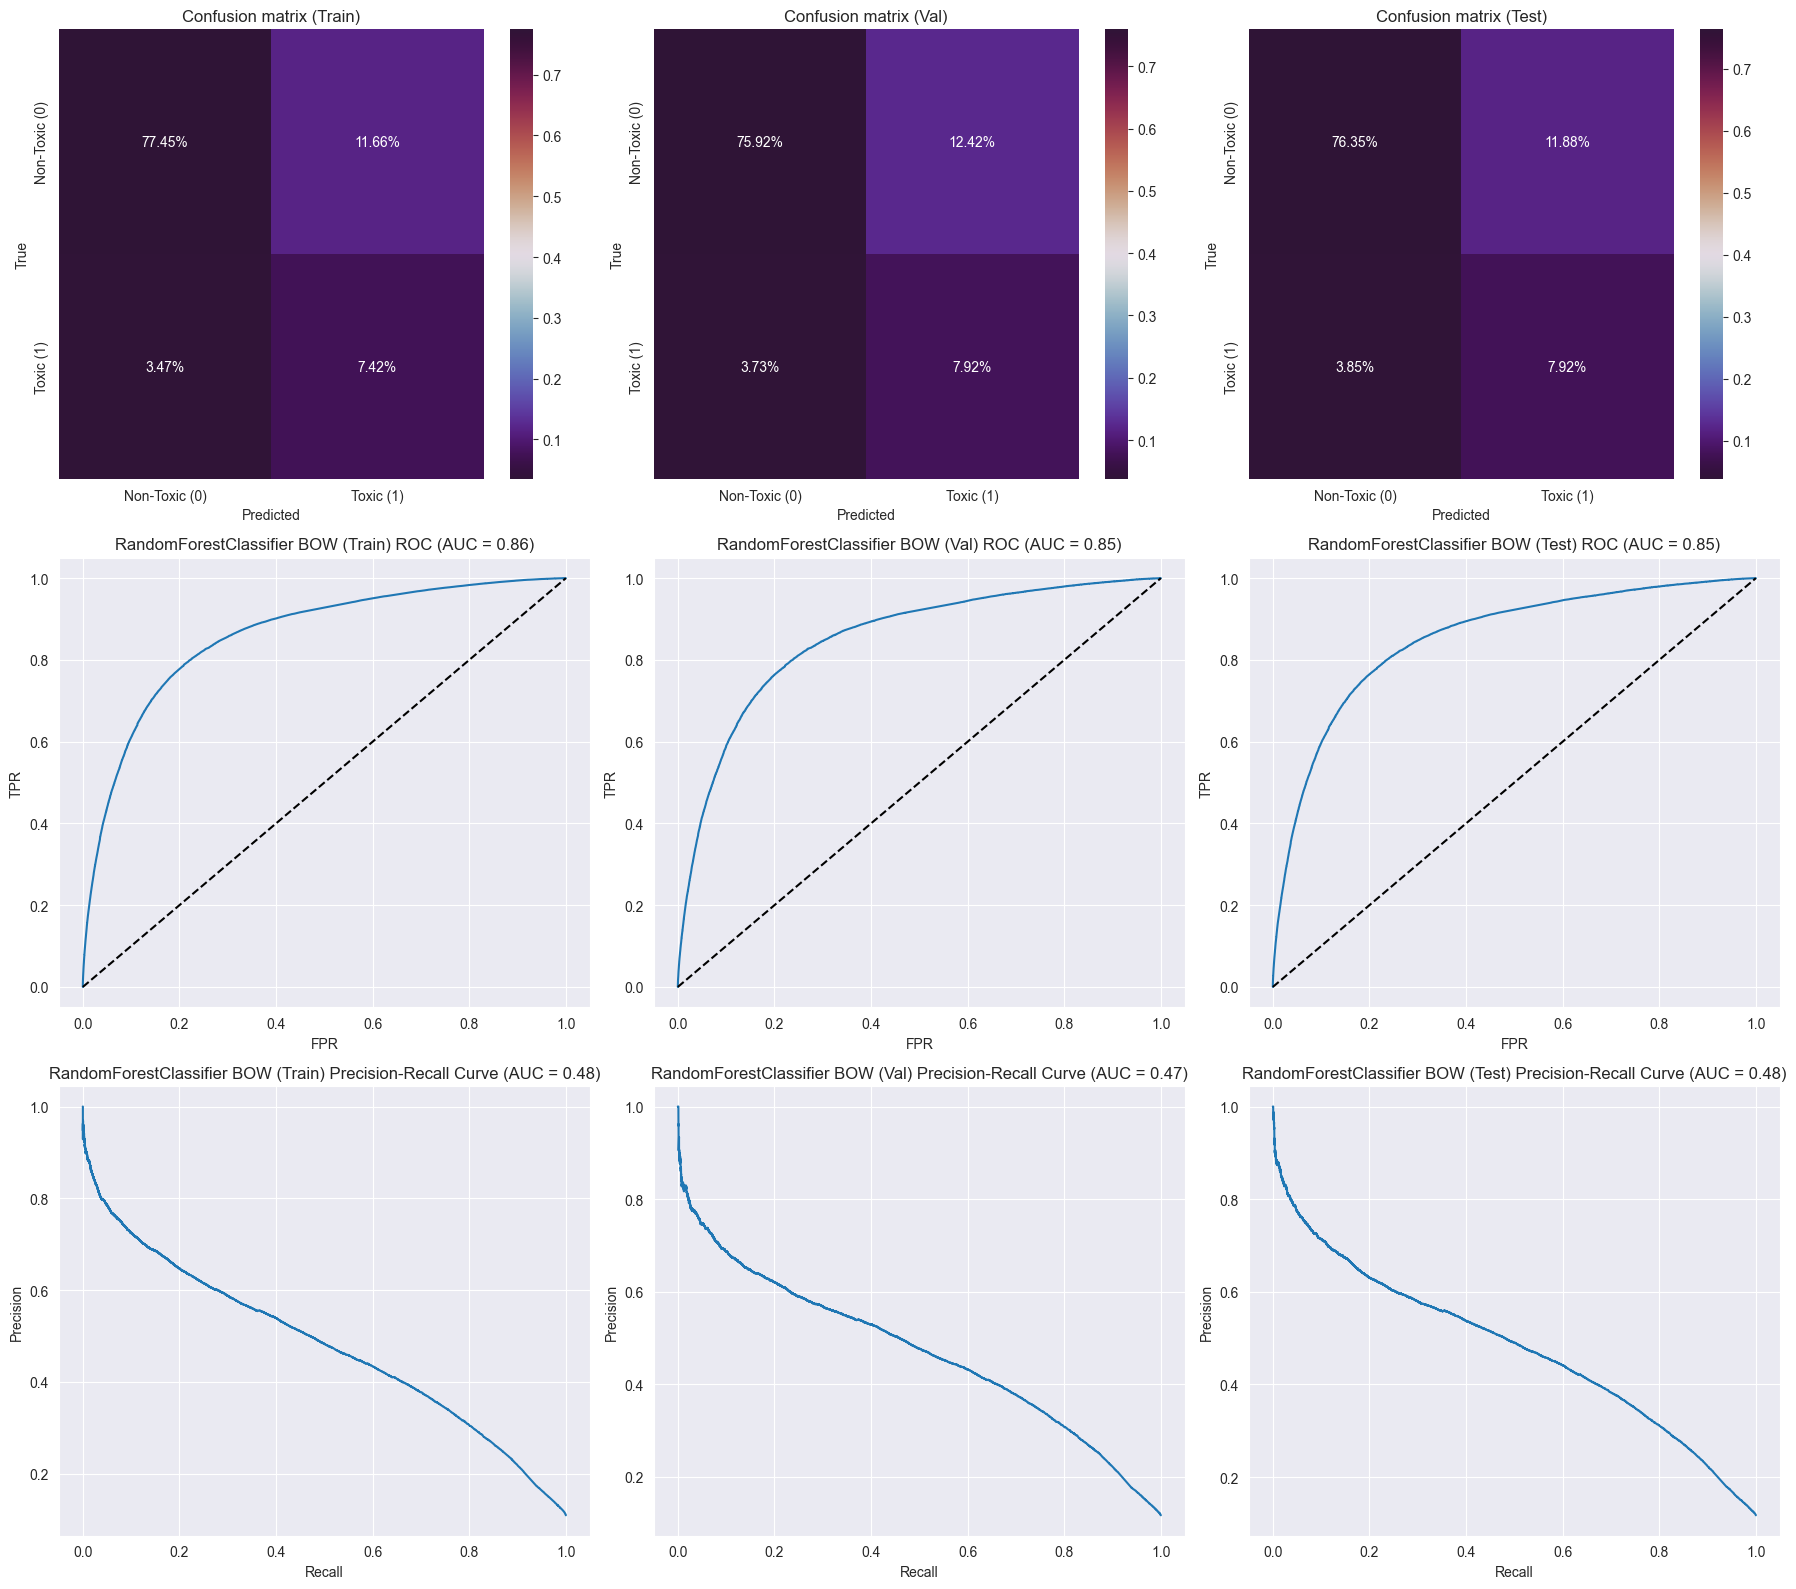

In [63]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train = y_random_forest_bow_pred_train,
    y_pred_val = y_random_forest_bow_pred_val,
    y_pred_test = y_random_forest_bow_pred_test,
    y_pred_proba_train = y_random_forest_bow_pred_proba_train,
    y_pred_proba_val = y_random_forest_bow_pred_proba_val,
    y_pred_proba_test = y_random_forest_bow_pred_proba_test,
    title='RandomForestClassifier BOW'
)

In [64]:
best_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, random_forest_objective, n_trials=30)
(y_random_forest_tfidf_pred_train,
 y_random_forest_tfidf_pred_val,
 y_random_forest_tfidf_pred_test,
 y_random_forest_tfidf_pred_proba_train,
 y_random_forest_tfidf_pred_proba_val,
 y_random_forest_tfidf_pred_proba_test
 ) = train_and_predict_toxicity(
    model=RandomForestClassifier(**best_params, class_weight='balanced', random_state=42),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2025-02-27 04:22:05,026] A new study created in memory with name: no-name-9102e0b7-88c2-45b7-aef5-f8c19c83b427
[I 2025-02-27 04:22:16,113] Trial 0 finished with value: 0.5259569117682618 and parameters: {'n_estimators': 53, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.5259569117682618.
[I 2025-02-27 04:22:19,695] Trial 1 finished with value: 0.5015616520952668 and parameters: {'n_estimators': 80, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.5259569117682618.
[I 2025-02-27 04:22:22,487] Trial 2 finished with value: 0.48576620230163536 and parameters: {'n_estimators': 52, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.5259569117682618.
[I 2025-02-27 04:22:38,181] Trial 3 finished with value: 0.529094953752488 and parameters: {'n_estimators': 77, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.52

RandomForestClassifier TFIDF

Precision		Recall			F1

Train: 0.44		Train: 0.69		Train: 0.54
Val: 0.44		Val: 0.68		Val: 0.53
Test: 0.45		Test: 0.67		Test: 0.54


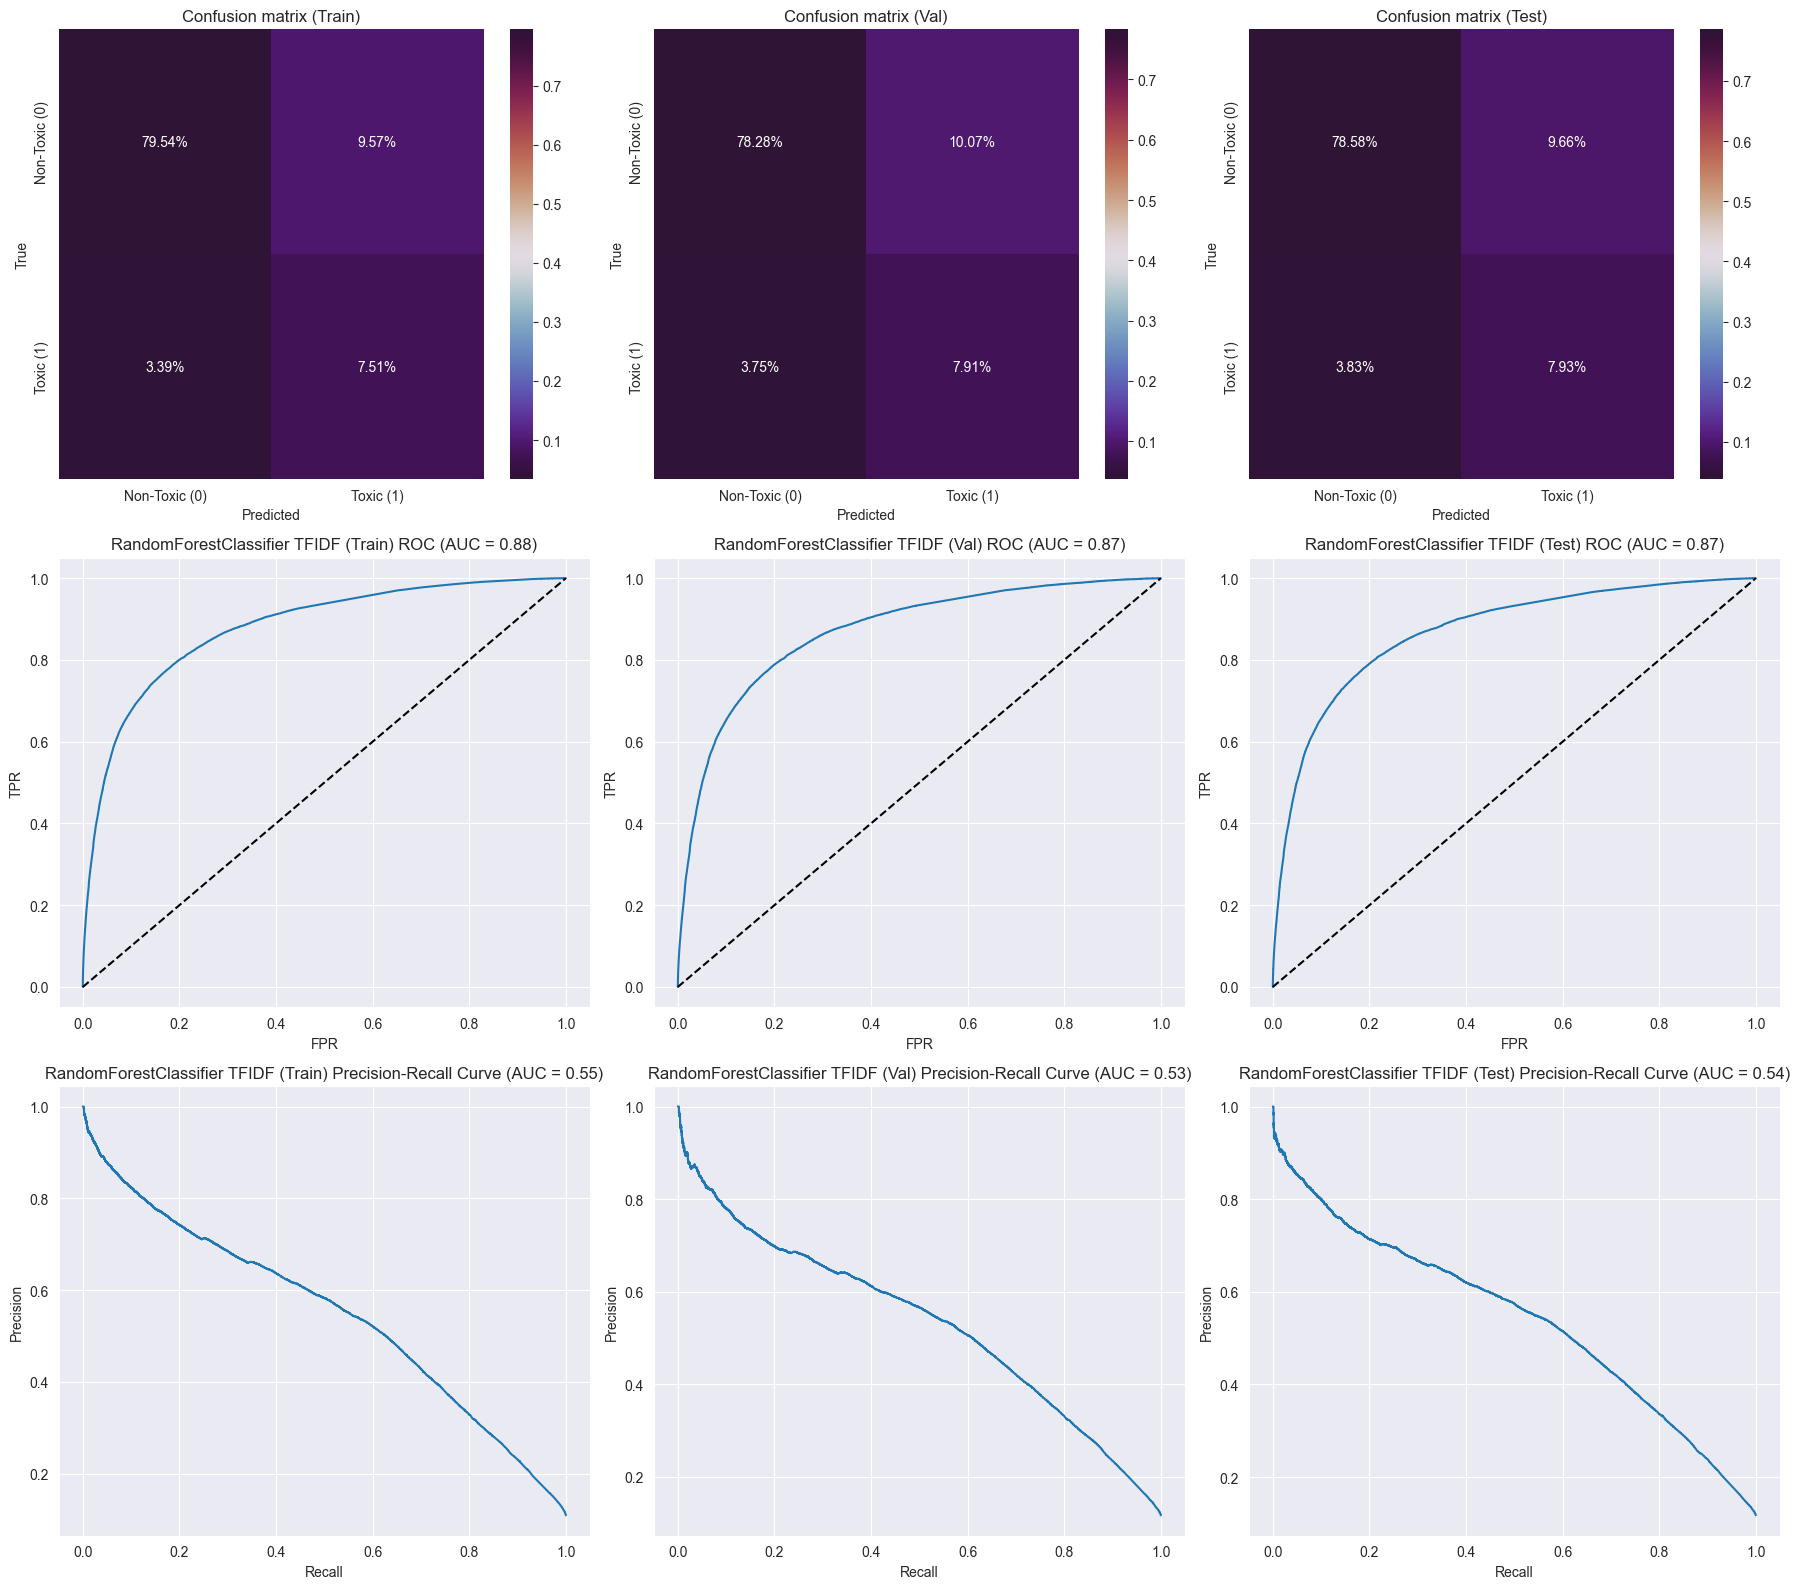

In [65]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train = y_random_forest_tfidf_pred_train,
    y_pred_val = y_random_forest_tfidf_pred_val,
    y_pred_test = y_random_forest_tfidf_pred_test,
    y_pred_proba_train = y_random_forest_tfidf_pred_proba_train,
    y_pred_proba_val = y_random_forest_tfidf_pred_proba_val,
    y_pred_proba_test = y_random_forest_tfidf_pred_proba_test,
    title='RandomForestClassifier TFIDF'
)

# Выводы

На текущий момент наилучшим образом для наших задач среди классичесеих моделей показала себя модель `Linear_SVC` по метрикам `recall` и `F-1`. Однако использование более продвинутых моделей машинного обучения по типу `XGBoost` хоть и не показывают наиболее высокие показатели метрик `precision` и `recall`, но имеют между этими метриками неплохой баланс, что по итогу дает более высокие показатели метрики `F-1` у этих моделей. По итогу можно сделать вывод, что для будущего построения сервиса для бинарной классификации основанного на ML методах наиболее подходящими моделями являются модели градиентного бустинга или возможно другие продвинутые модели ML.